# HERA Auto-Correlation GAN Practice
### Joseph Shy

HERA data importing guided from "io_example.ipynb" in HERA_CAL/scripts
GAN model functions inspired by 'tensorflow-practice-2-updated-quadratic-meeting.ipynb' in mylustre/machine_learning

### Version 3.0
- Removed the `plot_history` and `summarize performance` function from notebook, as they were integrated into the `train` function.
- Cleaned up cells
- Added updates to docstrings
- Commented code
### NOTE: THESE VERSION UPDATES ARE OUTDATED, BEFORE THE SCRIPT WAS ATTACHED TO A GIT REPOSITORY. PLEASE FINE NEW VERSION NOTES IN THE GIT MESSAGE FOR CURRENT COMMIT.

## Important Notes about GAN Modeling
- all auto-correlations are normalized (therefore could remove any utility magnitude may play in antenna-quality classification
- only 'ee' data is used, need to consider a possibly semi-supervised model to delineate between the two

The goal of this notebook is to integrate the machine learning techniques gathered from my previus machine learning practice with the `H4C` auto-correlation data on the observation julian date of `2459122`. The good `"ee"` auto-correlations for each and antenna and integration time is used as part of the detector training set for real values. **It is important to know whether to train `"ee"` and `"nn"` together or separately (or only one or the other) for the future.**

## 1. Organize Auto-Correlation Data

This section separates the `"ee"` auto-correlation data for the good antennas on the night of `2459122`. This type of data is `H4C`, which is a newer configuration of data for HERA. It was advised by Tyler Cox and Dr. Aaron Parsons to use this data categorization/type for preliminary training/practice for the GAN. The bad antennas for this night was derived from [https://docs.google.com/spreadsheets/d/1xFo2PLVUhXHe-yqHHl0WrRe5pXZF2zC8Z1fLqPZbPZ8/edit#gid=418790055](URL), which flags the bad antennas from manual validation processes. 

### Import Libraries

In [1]:
# import libraries from 'io_example.ipynb' that was used for importing/interfacing with HERA datatypes
from __future__ import absolute_import, division, print_function
import numpy as np
import os
from hera_cal.io import HERAData, HERACal
from hera_cal.data import DATA_PATH
import matplotlib.pyplot as plt

### Configure filepaths to auto-correlations
Below, list comprehension is used to create filepaths for each auto-correlation file for the night of `2459122`. The list `filename` is available at the bottom of this notebook (due to its large size crowding the rest of the notebook) containing each desired filename. The filenames were retrieved though the command line `ls` within the path `/lustre/aoc/projects/hera/H4C/2459122` within the NRAO servers. The filenames, in the configuration of a text file, is saved (at bottom of notebook due to it not being necessary for recurring use of the notebook) to the current directory for ease of access. The filepaths created below are also saved to a text file.

The following two cells were used when intially loading in data and saving.

In [5]:
#filepath = ['/lustre/aoc/projects/hera/H4C/2459122/{}'.format(k) for k in filename] # create filepath to each auto-crre;ati

In [6]:
# save list to text file
# with open("filepaths-autos_2459122.txt", "w") as f: # open a text file
#     for s in filepath: # iterate through all pathes
#         f.write(str(s) +",\n") # append filepath to text file

The two cells below are always ran when initializing the notebook for use.

In [19]:
# load in text file to list
filepath = open("filepaths-autos_2459122.txt", "r") # open file
filepath = filepath.readlines() # read in file line by line
filepath = [k.replace(',\n','') for k in filepath] # correct formatting, so list is ready for indexing and using

In [9]:
filepath # check to make sure list was created properly

['/lustre/aoc/projects/hera/H4C/2459122/zen.2459122.25108.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/H4C/2459122/zen.2459122.45934.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/H4C/2459122/zen.2459122.25131.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/H4C/2459122/zen.2459122.45957.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/H4C/2459122/zen.2459122.25153.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/H4C/2459122/zen.2459122.45979.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/H4C/2459122/zen.2459122.25175.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/H4C/2459122/zen.2459122.46002.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/H4C/2459122/zen.2459122.25198.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/H4C/2459122/zen.2459122.46024.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/H4C/2459122/zen.2459122.25220.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/H4C/2459122/zen.2459122.46046.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/H4C/2459122/zen.2459122.25243.sum.autos.uvh5',
 '/lustre/aoc/projects/he

### Load in auto-correlation data
Below, all the auto-correlation data is loaded in for each integration time within the night of `2459122`. 

In [20]:
hd = HERAData(filepath) # read in all data files
data, flags, nsamples = hd.read() # call data from files

### Create auto-correlation data keys for bad antennas
Below, the loop creates key tuples in the standard of the keys within the HERA data containers. The `bad_ants` list is at the bottom of this notebook, just above the `filename`. It contains the integer labels of every manually flagged bad antenna for the given observation night. This list was retrieved from [https://docs.google.com/spreadsheets/d/1xFo2PLVUhXHe-yqHHl0WrRe5pXZF2zC8Z1fLqPZbPZ8/edit#gid=418790055](URL) which contains the manual bad antenna identification for the `H4C` auto-correlations.

The below cell was used when initially creating the list of good antenna keys. It is not used for all runs of the notebook.

In [17]:
# bad_key = [] # intialize list
# for ii, key in enumerate(bad_ants): # loop through bad antennas
#     # create tuple keys in HERA format
#     bad_key.append((key,key,'ee'))
#     bad_key.append((key,key,'nn'))

In [18]:
# bad_key # diplay list to make sure it loaded correctly 

[(0, 0, 'ee'),
 (0, 0, 'nn'),
 (1, 1, 'ee'),
 (1, 1, 'nn'),
 (2, 2, 'ee'),
 (2, 2, 'nn'),
 (11, 11, 'ee'),
 (11, 11, 'nn'),
 (12, 12, 'ee'),
 (12, 12, 'nn'),
 (13, 13, 'ee'),
 (13, 13, 'nn'),
 (14, 14, 'ee'),
 (14, 14, 'nn'),
 (23, 23, 'ee'),
 (23, 23, 'nn'),
 (24, 24, 'ee'),
 (24, 24, 'nn'),
 (25, 25, 'ee'),
 (25, 25, 'nn'),
 (26, 26, 'ee'),
 (26, 26, 'nn'),
 (37, 37, 'ee'),
 (37, 37, 'nn'),
 (38, 38, 'ee'),
 (38, 38, 'nn'),
 (39, 39, 'ee'),
 (39, 39, 'nn'),
 (44, 44, 'ee'),
 (44, 44, 'nn'),
 (45, 45, 'ee'),
 (45, 45, 'nn'),
 (46, 46, 'ee'),
 (46, 46, 'nn'),
 (51, 51, 'ee'),
 (51, 51, 'nn'),
 (52, 52, 'ee'),
 (52, 52, 'nn'),
 (59, 59, 'ee'),
 (59, 59, 'nn'),
 (65, 65, 'ee'),
 (65, 65, 'nn'),
 (67, 67, 'ee'),
 (67, 67, 'nn'),
 (73, 73, 'ee'),
 (73, 73, 'nn'),
 (75, 75, 'ee'),
 (75, 75, 'nn'),
 (81, 81, 'ee'),
 (81, 81, 'nn'),
 (84, 84, 'ee'),
 (84, 84, 'nn'),
 (86, 86, 'ee'),
 (86, 86, 'nn'),
 (87, 87, 'ee'),
 (87, 87, 'nn'),
 (88, 88, 'ee'),
 (88, 88, 'nn'),
 (89, 89, 'ee'),
 (89, 89,

### Organize good antenna keys
Below, the results from the section above is used to separate the bad keys from the good keys.

The below cell was used when first creating the list of good antenna keys. It was saved as a text file and loaded in for later runs.

In [19]:
# good_key = [] # initialize list
# for ii, key in enumerate(data.keys()): # loop through all data keys in HERA data container for specific time of observation
#     if key not in bad_key: # any tuple key that isnt bad, append to good key list
#         good_key.append(key)

In [20]:
# good_key # display list to make sure it loaded correctly

[(36, 36, 'ee'),
 (36, 36, 'nn'),
 (50, 50, 'ee'),
 (50, 50, 'nn'),
 (53, 53, 'ee'),
 (53, 53, 'nn'),
 (58, 58, 'ee'),
 (58, 58, 'nn'),
 (66, 66, 'ee'),
 (66, 66, 'nn'),
 (68, 68, 'ee'),
 (68, 68, 'nn'),
 (82, 82, 'ee'),
 (82, 82, 'nn'),
 (83, 83, 'ee'),
 (83, 83, 'nn'),
 (85, 85, 'ee'),
 (85, 85, 'nn'),
 (91, 91, 'ee'),
 (91, 91, 'nn'),
 (92, 92, 'ee'),
 (92, 92, 'nn'),
 (98, 98, 'ee'),
 (98, 98, 'nn'),
 (99, 99, 'ee'),
 (99, 99, 'nn'),
 (100, 100, 'ee'),
 (100, 100, 'nn'),
 (102, 102, 'ee'),
 (102, 102, 'nn'),
 (103, 103, 'ee'),
 (103, 103, 'nn'),
 (104, 104, 'ee'),
 (104, 104, 'nn'),
 (105, 105, 'ee'),
 (105, 105, 'nn'),
 (108, 108, 'ee'),
 (108, 108, 'nn'),
 (109, 109, 'ee'),
 (109, 109, 'nn'),
 (117, 117, 'ee'),
 (117, 117, 'nn'),
 (118, 118, 'ee'),
 (118, 118, 'nn'),
 (120, 120, 'ee'),
 (120, 120, 'nn'),
 (124, 124, 'ee'),
 (124, 124, 'nn'),
 (127, 127, 'ee'),
 (127, 127, 'nn'),
 (128, 128, 'ee'),
 (128, 128, 'nn'),
 (129, 129, 'ee'),
 (129, 129, 'nn'),
 (130, 130, 'ee'),
 (130, 

In [25]:
# # save list to text file
# with open("good-ant-keys_2459122.txt", "w") as f:
#     for s in good_key:
#         f.write(str(s) +",\n")

Load in good antenna key tuples for indexing into HERA `H4C` data,

In [2]:
# load in text file to list
good_key = open("good-ant-keys_2459122.txt", "r")
good_key = good_key.readlines()
good_key = [eval(k.replace(',\n','')) for k in good_key]

### Organize `"ee"` data
Below, the `"ee"` data is separate into its own list, as only the `"ee"` data is being used to train, for the time being.

In [3]:
good_key_ee = [] # intialize list
for ii, key in enumerate(good_key): # iterate through good antenna keys
    # only append the 'ee' keys
    if key[2] == 'ee':
        good_key_ee.append(key)

### Concatenate all auto-corr. data and save
Below, all the auto-correlation datas are concatenated together for ease of sparsing through and accessing for GAN work. Now the above data import using `HERAData` should not be needed, as the data is now locally accessible.

In [16]:
freqs = np.array(data.freqs) # make frequency data into an array
np.save('HERA_auto-corr_freqs.npy',freqs) # save frequency data

In [21]:
auto_data = np.array(data[good_key_ee[0]])
for ii in range(1,len(good_key_ee)):
    auto_data = np.vstack((auto_data,data[good_key_ee[ii]]))

In [22]:
auto_data.shape

(167580, 1536)

In [38]:
np.save('2459122_good_auto-corrs.npy',auto_data)

Checking to make sure data is organized as expected.

In [27]:
x = np.vstack((data[good_key_ee[0]],data[good_key_ee[1]]))
x.shape

(7448, 1536)

In [32]:
len(good_key_ee)

45

In [19]:
good_key_ee[10][1]

92

### Split data into training, validation, and testing sets.
The below cells shouldn't need to be run again, as the data can be accessed locally now.

In [23]:
import sklearn.model_selection as sk # used to split auto-correlations into sets

In [24]:
auto_data_train, auto_data_valid = sk.train_test_split(auto_data, test_size = 0.15, random_state=42) # split data randomly into training and validation set
# 15% validation size, as the auto-corr. data is extremely large (>160,000 signals), so a smaller fraction can be used than standard

In [44]:
np.save('2459122_good_auto-corrs_train.npy',auto_data_train) 
np.save('2459122_good_auto-corrs_valid.npy',auto_data_valid) 

In [6]:
# auto_data_train = np.load('2459122_good_auto-corrs_train.npy')
# auto_data_valid = np.load('2459122_good_auto-corrs_valid.npy')
# freqs = np.load('HERA_auto-corr_freqs.npy')

In [25]:
auto_data_valid, auto_data_test = sk.train_test_split(auto_data_valid, test_size = 0.25, random_state=42) # split validation to validation and test data
np.save('2459122_good_auto-corrs_valid.npy',auto_data_valid) 
np.save('2459122_good_auto-corrs_test.npy',auto_data_test) 
np.save('2459122_good_auto-corrs_train.npy',auto_data_train) 

In [28]:
auto_data_valid.shape

(18852, 1536)

In [4]:
auto_data_train = np.load('2459122_good_auto-corrs_train.npy')
auto_data_valid = np.load('2459122_good_auto-corrs_valid.npy')
auto_data_test = np.load('2459122_good_auto-corrs_test.npy')
freqs = np.load('HERA_auto-corr_freqs.npy')

In [10]:
auto_data_v.shape

(10604, 1536)

### Get standard deviation of signal
Using the radiometer equation in [https://casper.ssl.berkeley.edu/astrobaki/index.php/Radiometer_Equation](URL), we can calculated the standard deviation of the auto-correlation gaussian randomness of each signal at each frequency.

In [5]:
hd = HERAData('/lustre/aoc/projects/hera/H4C/2459122/zen.2459122.25108.sum.autos.uvh5') # read in all data files
data, flags, nsamples = hd.read() # call data from files

meta = hd.get_metadata_dict()

BW = np.median(np.diff(meta['freqs']))

int_time = np.median(np.diff(meta['times']))*24*3600

stddev = 1/np.sqrt(BW*int_time)
print(stddev)

0.0009207119165799618


## 2. Generative Adversarial Neural Network

In this section of the notebook, the functions from the parabolic GAN training practice are modified and integrated into this notebook. The goal is to train a generator to create realistic auto-correlations from the data organized in the previous section. The detector is also going to be trained to become increasingly better at detecting fake data that (hopefully) closely resembles real auto-correlations. If this can be accomplished with confidence and robustness, the detector should be able to detect an auto-correlations that deviate slightly from the expected norm, allowing automatic identification of bad antennas through their auto-correlations. Additionally, we will have a generator than can produce mock auto-correlations that could be used for a variety of simulations or practices.

### Import necessary libraries

In [6]:
import tensorflow as tf # import the tensflow library - necessary for any machine-learning task
import matplotlib.pyplot as plt # import matplotlib library for plotting purposes
import numpy as np # import numpy for array usage
from tensorflow import keras # import keras, the main sub-section of tensorflow being used

# import possible keras layers for use
from tensorflow.keras.models import Sequential # model type
from tensorflow.keras.layers import Dense # model layering
from tensorflow.keras.layers import Dropout # model layering
from tensorflow.keras.layers import GaussianNoise # model layering
from tensorflow.keras.layers import LeakyReLU # model layering
from tensorflow.keras.layers import Conv1D # model layering
from tensorflow.keras.layers import Input # model layering
from tensorflow.keras.layers import Conv1DTranspose # model layering
from tensorflow.keras.layers import Flatten # model layering
from tensorflow.keras.layers import Reshape # model layering
from tensorflow.keras import activations # layer activation models
from tensorflow.keras.optimizers import Adam # "Adam" optimization technique for model compile
from tensorflow.keras.layers import AveragePooling1D # pooling layer
from tensorflow.keras.layers import BatchNormalization # normalization layer
from tensorflow.keras.layers import LayerNormalization # normalization layer
from tensorflow.keras.layers import Multiply, Add # used to multiply outputs of multiple layers

from tensorflow.keras.utils import plot_model # plots sequential layered structure of NN models

from datetime import datetime # datetime module 

# jupyter notebook specific command to show plots inline 
%matplotlib inline 

### Configure GPUs
GPUs need to be assigned to tasks from this notebook, as tensorflow operates at higher rates with one or more dedicated GPUs.

In [ ]:
# command to configure a GPU for use in machine learning 
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
tf_device='/gpu:0'

### Build detector NN
Below, the detector neural network is created. Convolutional layers `(Conv1D)` make up the majority of the sequential layers in this model, as convolutional layers do well in picking out features of plots and images. Given the large number of minute features in auto-correlations, convolutional layers are the preferred/primary form of layering. `LeakyRelU` activation layers are used for the `Conv1D` layers, as advised by [https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/](URL). It seems to be becoming a more common practice to use this type of activation layers for GANs. `Dropouts` are integrated in order to avoid over-fitting to the training set. Lastly, a `Dense` mapping layer, assigns the auto-correlations to a `0` or a `1` (fake or real, respectively) using `sigmoid` activation. The model is compiled with `binary_crossentropy`, as this is best for binary classification NNs. **Note: Various parameters within the layers are changed (and sometimes layers are removed or rearranged) and documented for different training attempts.**

In [7]:
# build detector function
def define_detector(n_inputs,batch_size):
    """Build a detector NN that detects if a one-dimensional dataset at a explicit linearly spaced channels (x-axis) is a "real" or "fake" dataset based upon a training.
    
    Arguments:
    n_inputs (int) -- amount of values in a single one-dimensional dataset
    batch_size (int) -- number of datasets fed into detector at each training call
    
    Returns:
    model (tensorflow.python.keras.engine.sequential.Sequential) -- tensorflow keras compiled sequentially-layered model
    
    """
    model = Sequential(
        [
            
#             Conv1D(8, 3, padding='same', strides=1,input_shape=(n_inputs,1),batch_size=batch_size),
#             LeakyReLU(alpha=0.2),
#             Conv1D(8, 3, padding='same', strides=1), 
#             LeakyReLU(alpha=0.2),
#             AveragePooling1D(pool_size=2, padding='same'),
            
            Conv1D(16, 3, padding='same', strides=1,input_shape=(n_inputs,1),batch_size=batch_size),
            LeakyReLU(alpha=0.2),
            Conv1D(16, 3, padding='same', strides=1), 
            LeakyReLU(alpha=0.2),
            AveragePooling1D(pool_size=2, padding='same'),

            Conv1D(32, 5, padding='same', strides=1),
            LeakyReLU(alpha=0.2),
            Conv1D(32, 5, padding='same', strides=1), 
            LeakyReLU(alpha=0.2),
            AveragePooling1D(pool_size=2, padding='same'),
            
            Conv1D(64, 7, padding='same', strides=1),
            LeakyReLU(alpha=0.2),
            Conv1D(64, 7, padding='same', strides=1), 
            LeakyReLU(alpha=0.2),
            AveragePooling1D(pool_size=4, padding='same'),
            
            # flatten in order to allow dense layer map all data to one value
            Flatten(),
            
            Dense(512),
            LeakyReLU(alpha=0.2),
            
            Dense(64),
            LeakyReLU(alpha=0.2),
            
            Dense(16),
            LeakyReLU(alpha=0.2),

            # dense layer with sigmoid activation, allowing the data to be mapped to a 0 or 1 (or somewhere in between)
            # fake = 0, real = 1, in-between = not a confident decision from the detector
            Dense(1,activation='sigmoid')
                   
        ]
    )
    
    # compile detector model 
    # binary_crossentropy is best for a binary classification NN such as this
    #model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001)) # -- original
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy']) # -- modified
    return model

### Build generator NN
Below, the generator neural network is built. It uses paired convolutional `(Conv1D)` layers and convolutional transpose `(Conv1DTranspose)` layers. `LeakyRelU` activation layers are used for all layers besides the last `Dense` mapping layer. For the final layer, the `Dense` layer uses `linear` activation to generated 1536 values that correspond to auto-correlation fluxes at each HERA frequency channel. **Note: Various parameters within the layers are changed (and sometimes layers are removed or rearranged) and documented for different training attempts.**

In [8]:
def define_generator(n_inputs,latent_dim,batch_size):
    """Build generator NN that produces a fake dataset one-dimensional dataset at explicit linearly-spaced channels (x-axis) in same .  
    
    Arguments:
    n_inputs (int) -- amount of values in a single one-dimensional dataset
    latent_dim (int) -- number of latent dimensions for generator to create a dataset from
    batch_size (int) -- number of datasets fed into detector at each training call
    
    Returns:
    model (tensorflow.python.keras.engine.sequential.Sequential) -- tensorflow keras uncompiled sequentially-layered model 
    
    """
    model = Sequential(
        [
            
#             Dense(64, input_shape=(1,latent_dim),batch_size=batch_size),
#             LeakyReLU(alpha=0.2),
            
#             Dense(512),
#             LeakyReLU(alpha=0.2),
            
            Dense(n_inputs, input_shape=(1,latent_dim),batch_size=batch_size),
            LeakyReLU(alpha=0.2),
            
            Reshape((int(n_inputs/64),64)), 
            
#             Conv1DTranspose(64,7,padding='same',strides=2),
#             LeakyReLU(alpha=0.2),
#             Conv1DTranspose(64,7,padding='same',strides=2),
#             LeakyReLU(alpha=0.2),

            Conv1DTranspose(32,5,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            Conv1DTranspose(32,5,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            
            Conv1DTranspose(16,3,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            Conv1DTranspose(16,3,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            
            Conv1DTranspose(8,3,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            Conv1DTranspose(8,3,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            
            Conv1DTranspose(1,3,padding='same'),
            LeakyReLU(alpha=0.2),
            
            # flatten values to allow for mapping to a single dense layer
            Flatten(),
            
            # map values to a dataset of a desired length, to represent a fake dataset attempting to resemble the real data
            Dense(n_inputs),
            LeakyReLU(alpha=0.2),
            
            # reshape output to be in the format of the detector model input
            Reshape((n_inputs,1))
            
        ]
    )
    return model

### Build GAN
Below, the GAN is built. It stacks the generator as the first model and the detector second. This way, values can be generated and flagged as real (although they are fake) and sent through the detector. Due to the disagreement between the generated values and their assigned flags, the detector should return certain losses and accuracy values, which can be used to train the generator (in order to increase the accuracy of the GAN, by tricking the detector into believing the fake values are real). It is important to make the detector non-trainable in the GAN, or that would lead to bias detector training, as the fake values fed into the gain are flagged as real. The model is compiled with the same loss function as the detector, as we are interested in what the detector returns, in order to train the generator. 

In [9]:
def define_gan(generator, detector, stddev, latent_dim, batch_size, n_inputs):
    """Build Generative Adversarial NN that updates generator model weights based off of detector results of falsified trainign data.
    
    Arguments:
    generator -- tensorflow keras uncompiled model that creates fake data
    detector -- tensorflow keras compiled model that delinates between real and fake data
    
    Returns:
    model (tensorflow.python.keras.engine.sequential.Sequential) -- tensorflow keras compiled model that combines an untrainable detector with a trainable generator
    
    """
    detector.trainable = False # make detector weights not trainable, only need detector results in order to update the generator
    
    inp = Input(shape=(1,latent_dim))
    gen_layer = generator(inp)
    #noise_ones ="" Input(tensor=tf.ones((batch_size,n_inputs,1)))
    noise = GaussianNoise(stddev=stddev)(tf.ones((batch_size,n_inputs,1)))
    mult_layer = Multiply()([gen_layer,noise])
    det_layer = detector(mult_layer)
    model = tf.keras.Model(inputs=inp, outputs=det_layer)
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5)) # -- original
    return model

### Generate real values
This function grabs good auto-correlations randomly from any loaded in file and antenna. It makes a training batch of any specified size. It also returns a list of flags that pair with the data returned. The flags are all `1`, as it represents real data to train on. The real values were initially scaled down by `1e7`, as it was noticed that the models would not train to values of such large magnitudes. By now a more robust normalization present within the `tensorflow-keras` package is used. Also, only the `real` components of the auto-correlations are used, as it does not have an `imaginary` component (only present in data due to HERA data organizaton standards).

In [10]:
# define function to create arrays of real numbers and flags at each index
def generate_real_values(batch_size,data):
    """Grabs real auto-correlations from loaded in HERA data and organizes into batches for NN model training.
    
    Arguments:
    batch_size (int) -- number of datasets fed into detector at each training call
    data (hera_cal.datacontainer.DataContainer) -- HERA auto-correlation data
    
    Returns:
    X(numpy array) -- first dimension associates to a specific dataset in larger batch; second dimension is a single dataset of values output from HERA auto-correlation data at specific fequency channels
    y (numpy array) -- first dimension associates to a specific dataset in larger batch; second dimension indicates to the detector model that the values are flagged as "real" data
    
    """
    X = []
    for ii in range(batch_size):
        signal = data[np.random.randint(1,len(data)+1)-1].real
        sig_norm = signal/np.median(signal)
        X.append(sig_norm) # calls a random integer for any index in the auto-correlation data list
 
    X = np.array(X) # convert list to numpy array
    X = X.reshape((batch_size,1536,1)) # reshape to agree with keras convolutional layer input standard
    Y = np.ones((batch_size,1)) # associated real flags for each retrieved auto-correlations
   # X = tf.keras.utils.normalize(X, axis=1) # normalization of data for quicker, less-computational IMPORTANT ASPECT
    
    
    return X, Y

In [22]:
x,y = generate_real_values(512,auto_data_train) # test function to make sure it grabs and organizing seemingly valid data

Below is some experimental statistic work done with Dr. Parsons

In [23]:
var = np.random.normal(size=(int(1e4),1000))
sum1 = np.sum(np.abs(var)**2,axis=0) 
np.sqrt(np.mean((sum1 - 1e4)**2))/1e2/np.sqrt(2)

0.9817429446129057

### Generate latent dimensions
The following function creates random latent dimensions of any size and batch. It creates a random gaussian noise vector of `mean = 0` and `variance = 1`. It is used to feed into the generator, as the generator is meant to produce realistic values from latent noise vectors.

In [11]:
def generate_latent(latent_dim, batch_size):
    """Generate latent values for input into the generator model.
    
    Arguments:
    latent_dim (int) -- number of latent dimensions for generator to create a dataset from
    batch_size (int) -- number of datasets fed into detector at each training call
    
    Returns:
    x_input (numpy array) -- first dimension corresponds to a specific batch; second dimension are the randomly generated latent values for a specific batch
    
    """
    x_input = np.random.randn(batch_size,1,latent_dim)
    return x_input

### Generate fake values 
This function generates fake auto-correlations from predictions from a (preferably) trained generator NN. 

In [12]:
# generate n fake samples and plot results
def generate_fake(generator, latent_dim, batch_size):
    """Generates a fake datasets to be fed into the detector for training.
    
    Arguments:
    generator -- tensorflow keras uncompiled model that creates fake data
    latent_dim (int) -- number of latent dimensions for generator to create a dataset from
    batch_size (int) -- number of datasets fed into detector at each training call
    
    Returns:
    X(numpy array) -- first dimension associates to a specific dataset in larger batch; second dimension is a single dataset of fake values (corresponding to "x_inputs" from "generate_real_values" function) output from the generator 
    y (numpy array) -- first dimension associates to a specific dataset in larger batch; second dimension indicates to the detector model that the values are flagged as "fake" data
    
    """
    x_input = generate_latent(latent_dim, batch_size)
    X = generator.predict(x_input,batch_size)
    y = np.zeros((batch_size,1))
    return X, y

### Generate Validation Set
This function generates the validation auto-correlation set and normalizes it

In [13]:
def generate_validation(val_data):
    """Generates normalized validation data set of auto-correlations
    
    Arguments:
    val_data (numpy array) -- raw auto-correlation validation array, shape is (# of signals, frequencies)
    
    Returns:
    X (numpy array) -- normalized and reshaped auto-correlation validation array, shape is (# of signals, frequencies, 1)
    y (numpy array) -- flags signifying real signal of the same length as the 0th dimension of X
    
    """
    for ii in range(len(val_data)):
        val_data[ii] = (val_data[ii].real/np.median(val_data[ii].real))
    X = val_data.reshape((len(val_data),len(val_data[0]),1))
  #  X = tf.keras.utils.normalize(X, axis=1)
    y = np.ones((len(X),1))
    return X, y

In [83]:
var = generate_validation(auto_data_train)
var[0][:][0]


array([[0.26754921+0.j],
       [0.27344251+0.j],
       [0.27961904+0.j],
       ...,
       [0.73599462+0.j],
       [0.72944941+0.j],
       [0.72226156+0.j]])

In [71]:
auto_data_valid[0]

array([0.25066348+0.j, 0.25541596+0.j, 0.25993394+0.j, ...,
       0.65364551+0.j, 0.6475208 +0.j, 0.64238051+0.j])

In [72]:
auto_data_valid[0]/np.median(auto_data_valid[0])

array([0.25066348+0.j, 0.25541596+0.j, 0.25993394+0.j, ...,
       0.65364551+0.j, 0.6475208 +0.j, 0.64238051+0.j])

In [85]:
np.max(auto_data_train)

(15.344195092380692+0j)

Casting complex values to real discards the imaginary part


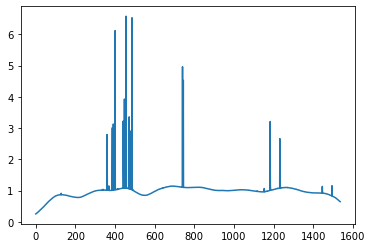

In [79]:
plt.plot(auto_data_valid[0])

### Train Models
The below function trains the detector and GAN. It trains the detector at each epoch for a desired batch size of real and fake auto-correlations. It trains the GAN at a each epoch too. It is important to note that the GAN is sometimes formatted to train at a specific ratio to the detector. This was done, as it was noticed that the detector sometimes seems to train faster than the GAN can. Additionally, this function calls the two funcitions above to analyze the training success.
Additionally, this function (if desired) saves all important information about a specific run in a predetermined and consistent format. It also plots and save random auto-correlations from the training set and generator output at progressive epoch steps. Additionally, the loss and accuracy of the detector and gan is save in a plot at the end of the run.

In [14]:
def train(generator, detector, gan, latent_dim, n_inputs, n_epochs, 
          n_eval, batch_size,ratio, good_key, data, val_data, freqs, save_run=False, dir_name='', filepath_to_save='',
          date_time='', model_comments='', reference_notes='', detector_layout='', generator_layout='', 
          gan_layout='', run_num='',commit=''):
    """Trains the detector for delinating between real and increasingly more realistic fake values. Trains the generator to produce more realistic fake data. Also, saves helpful summary/analysis files for model-training analysis. 
    
    Arguments:
    generator -- tensorflow keras uncompiled model that creates fake data
    detector -- tensorflow keras compiled model that delinates between real and fake data
    gan -- tensorflow keras compiled model that combines generator and detector into a GAN
    latent_dim (int) -- number of latent dimensions for generator to create a dataset from
    n_inputs (int) -- amount of values in a single one-dimensional dataset
    n_epochs (int) -- number of intervals between "summarize_performance" function call 
    batch_size (int) -- number of datasets fed into detector at each training call
    good_key (list of tuples) -- HERA data keys for antennas that have good auto-correlations
    data (hera_cal.datacontainer.DataContainer) -- HERA auto-correlation data
    val_data (np.array) -- array of auto-correlations separated from training set for use in model validation
    freqs (np.array) -- array of frequencies for H4C auto-correlationd data
    save_run (boolean) -- save training data option; save run == True, do not save run == False
    dir_name (string) -- name of directory to save keras models, epoch-progression plots, and analysis plots
    filepath_to_save (string) -- filepath to directory to where training run data will be saved to 
    date_time (string) -- date and time of training execution
    model_comments (string) -- any comments about the current keras models to be input into the READ-ME
    reference_notes (string) -- any comments about the currnt operating notebook this function is ran in and what data is being used to train with
    detector_layout (string) -- description or architecture of current detector layers (preferably a copy of the direct code used to create the model)
    generator_layout (string) -- description or architecture of current generator layers (preferably a copy of the direct code used to create the model)
    gan_layout (string) -- description or architecture of current GAN layers (preferably a copy of the direct code used to create the model)
    run_num (string) -- current training run identification number
    commit (string) -- current commit that the model is trained from

    Returns:
    None
    
    """
    # if saving training data is desired
    if save_run == True:
        
        # creates filepath/directory for saved data
        dir_path = os.path.join(filepath_to_save, dir_name)
        os.mkdir(dir_path)
        epoch_dir_path = os.path.join(dir_path,'training-snapshots') # filepath/directory creation for epoch progress plots
        os.mkdir(epoch_dir_path)

        # create and append READ-ME for current run
        read_me = open(os.path.join(dir_path,'READ-ME.txt'),'w+')
        read_me.write('HERA Auto-Correlation GAN Training Run ID-{} \n'.format(run_num))
        read_me.write('Time of Execution: {} \n'.format(date_time))
        read_me.write('Code written and ran by Joseph C. Shy \n')
        read_me.write('Code executed from Commit - {}. NN hyperparamters and inputs may vary but are documented below. \n\n'.format(commit))
        read_me.write("The folder 'training-snapshots' contains random generator output at a specific incremental epoch. \n")
        read_me.write("The file 'training_loss-accuracy_analysis.png' shows various losses and accuracies of the model training. \n\n")
        read_me.write('Manually Input Comments\n{}\n\n\n'.format('-'*23))
        read_me.write('Data and Code Version Reference \n{}{}\n\n'.format('-'*32,reference_notes))
        read_me.write('Training/Model Comments \n{}'.format('-'*23))
        read_me.write('{} \n\n'.format(model_comments))
        read_me.write('Training Input Parameters: \n{}\n'.format('-'*26))
        read_me.write('Latent Dimensions = {} \nFrequency Channels = {} \nTotal Epochs in this run = {} \nBatch Size = {} \nGan-to-Detector Training Ratio per Epoch = {} \n\n'.format(latent_dim, n_inputs, n_epochs, batch_size, ratio))
        read_me.write('Detector Layout: \n{}'.format('-'*16))
        read_me.write('{} \n \n'.format(detector_layout))
        read_me.write('Generator Layout: \n{}'.format('-'*17))
        read_me.write('{} \n \n'.format(generator_layout))
        read_me.write('Gan Layout: \n{}'.format('-'*11))
        read_me.write('{} \n \n'.format(gan_layout))
        read_me.close()
                      
    d1_hist, d2_hist, g_hist, a1_hist, a2_hist, v1_hist, v1_acc = [],[],[],[],[],[],[] # initalizing loss and accuracy lists
    # d1_hist = detector training real value loss
    # d2_hist = detector training fake value loss
    # g_hist = gan fake training loss
    # a1_hist = detector training real value accuracy
    # a2_hist = detector training real value loss
    # v1_hist = detector validation set loss
    # v1_acc = detector validation set accuracyr 
    
    # iterate through range of epochs and train detector and gan
    for ii in range(n_epochs):
        x_real, y_real = generate_real_values(batch_size=batch_size, data=data) # grab real data
        x_fake, y_fake = generate_fake(generator=generator, latent_dim=latent_dim, batch_size=batch_size) # generate fake data
        loss_real, acc_real = detector.train_on_batch(x_real, y_real) # train detector on real data
        loss_fake, acc_fake = detector.train_on_batch(x_fake * np.random.normal(loc=1,scale=stddev,size=(batch_size,n_inputs,1)), y_fake) # train detector on generated fake data with noise
        x_val, y_val = generate_validation(val_data)
        loss_val, acc_val = detector.test_on_batch(x_val, y_val)
        
        #original
        # if GAN:detector training ratio is desired, new for loop is entered
        for jj in range(ratio):
            x_gan = generate_latent(latent_dim=latent_dim, batch_size=batch_size) # generate latent dimensions for gan training
            y_gan = np.ones((batch_size,1)) # create false identifiers for fake data to trick gan
            gan_loss = gan.train_on_batch(x_gan, y_gan) # train gan with falsely identified fake data]
            g_hist.append(gan_loss)

        # based on epoch interval desired progress benchmarks, print generator output snapshots
        if (ii+1) % n_eval ==0:
#             x_real, y_real = generate_real_values(batch_size=batch_size, good_key=good_key, data=data) # generate real values
#             x_fake, y_fake = generate_fake(generator=generator, latent_dim=latent_dim,batch_size=batch_size) # generate fake values
#             loss_real_eval, acc_real_eval = detector.evaluate(x_real, y_real, batch_size=batch_size,verbose=0) # evaluate detectors on real data
#             loss_fake_eval, acc_fake_eval = detector.evaluate(x_fake, y_fake, batch_size=batch_size,verbose=0) # evaluate detector on fake data
            print('Epoch: {} \nTraining Data - Acc_Real: {} | Acc_Fake: {}\nValidation Data - Acc: {}'.format(ii+1, acc_real, acc_fake, acc_val)) # print evaluation results
            
            # plot random real and fake data
            fig = plt.figure()
            plt.plot(freqs, x_real[0,:,0], color='red',label='Real')
            plt.plot(freqs, x_fake[0,:,0], color='blue',label='Fake')
            plt.title('Auto-Correlation @ Epoch: {}'.format(ii+1))
            plt.xlabel('Frequency [Hz]')
            plt.ylabel('Normalized Visibility')
            plt.legend()
            plt.show()
            
            # save plot if desired
            if save_run == True:
                fig.savefig(os.path.join(epoch_dir_path,'generator-output_epoch-{}.png'.format(ii+1)),dpi=200)
                plt.close()
        
        # append analysis values to list
        d1_hist.append(loss_real)
        d2_hist.append(loss_fake)
        a1_hist.append(acc_real)
        a2_hist.append(acc_fake)
        v1_hist.append(loss_val)
        v1_acc.append(acc_val)
            
    # at end of training, plot loss and accuracy values over the training process
    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=5, ncols=1, constrained_layout=True,figsize=(16, 16))

    # training vs. loss
    ax1.plot(d1_hist, label='Training')
    ax1.plot(v1_hist, label='Validation')
    ax1.legend()
    ax1.set_title('Detector Loss - Training vs. Validation (Real Values)')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    
    # detector loss for fake
    ax2.plot(d2_hist, label='Fake')
    ax2.legend()
    ax2.set_title('Detector Loss for Fake Values')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    
    # GAN loss
    ax3.plot(g_hist)
    ax3.set_title('Generator Loss')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Loss')
     
    # detector accuracy for real values
    ax4.plot(a1_hist,label='Training')
    ax4.plot(v1_acc, label='Validation')
    ax4.set_title('Detector Accuracy')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Accuracy')

    # detector accuracy for fake values
    ax5.plot(a2_hist)
    ax5.set_title('Detector Accuracy - Fake')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('Accuracy')
                  
    plt.show()
    
    # if saving is desired, save analysis plot and trained models
    if save_run == True:
        fig.savefig(os.path.join(dir_path,'training_loss-accuracy_analysis.png'),dpi=200)
        plt.close()
                  
        detector.save(os.path.join(dir_path,'detector.h5'),overwrite=True)
        with open(os.path.join(dir_path,'detector_summary.txt'), 'w') as f:
            detector.summary(print_fn=lambda x: f.write(x + '\n'))
                  
        generator.save(os.path.join(dir_path,'generator.h5'),overwrite=True)
        with open(os.path.join(dir_path,'generator_summary.txt'), 'w') as f:
            generator.summary(print_fn=lambda x: f.write(x + '\n'))
                  
        gan.save(os.path.join(dir_path,'gan.h5'),overwrite=True)
        with open(os.path.join(dir_path,'gan_summary.txt'), 'w') as f:
            gan.summary(print_fn=lambda x: f.write(x + '\n'))                 
    

### Create and train models

Intialize the input variables into the `train` function. Initialize documentation for READ-ME output from `train` function.

In [15]:
# model building variables
n_inputs = 1536 # number of data values in one dataset - specific to HERA data
latent_dim = 22 # number of latent dimensions - more for more complex plots
batch_size = 64 # number of datasets in one batch 

# training/analysis variables
n_epochs = 5000 # number of epochs for model building
n_eval = 25 # when to present a plot
ratio = 1 # ratio of GAN to detector training per epoch

# file save variables
save_run = False # boolean to determine whether or not a save run is required 
run_num = '4.1' # run identification
dir_name = 'training_ID-{}'.format(run_num) # directory name for current model and training analysis results
filepath_to_save = '/users/jshy/mylustre/machine_learning/2459122-H4C_Machine-Learning_Practice/training-analysis'# directory in which to save folders to for current models 
date_time = datetime.now().strftime("%m/%d/%Y %H:%M:%S") # current date and time
commit = ''

model_comments = '''
This is a training run of the auto-correlation training on the "ee" data from night of 2459122.
The main focus is to see how the GAN trains deep into about 5,000 epochs

Modifications from previous runs:
- made training set np.log
- changed radiometer noise to log noise (differs from run #4 for this reason)
'''

reference_notes = '''
The notebook used to generate this model is "hera_data_practice_v3.ipynb" with modified model definitions (model layouts associated to this run are printed below).
It is the first real training run for 5,000 epochs.
The auto-correlation ("ee") training set was randomly chosen from all good antennas flagged on the night of 2459122 for all integration time files located in the H4C directory in HERA lustre. 
Reference the text files in the parent directory for filepaths to auto-correlation data and good/bad antenna categorization.
The training set is grabbed from '2459122_good_auto-corrs_train.npy'.
The validation set is grabbed from '2459122_good_auto-corrs_valid.npy'.
'''

detector_layout = '''
    model = Sequential(
        [
            
#             Conv1D(8, 3, padding='same', strides=1,input_shape=(n_inputs,1),batch_size=batch_size),
#             LeakyReLU(alpha=0.2),
#             Conv1D(8, 3, padding='same', strides=1), 
#             LeakyReLU(alpha=0.2),
#             AveragePooling1D(pool_size=2, padding='same'),
            
            Conv1D(16, 3, padding='same', strides=1,input_shape=(n_inputs,1),batch_size=batch_size),
            LeakyReLU(alpha=0.2),
            Conv1D(16, 3, padding='same', strides=1), 
            LeakyReLU(alpha=0.2),
            AveragePooling1D(pool_size=2, padding='same'),

            Conv1D(32, 5, padding='same', strides=1),
            LeakyReLU(alpha=0.2),
            Conv1D(32, 5, padding='same', strides=1), 
            LeakyReLU(alpha=0.2),
            AveragePooling1D(pool_size=2, padding='same'),
            
            Conv1D(64, 7, padding='same', strides=1),
            LeakyReLU(alpha=0.2),
            Conv1D(64, 7, padding='same', strides=1), 
            LeakyReLU(alpha=0.2),
            AveragePooling1D(pool_size=4, padding='same'),
            
            # flatten in order to allow dense layer map all data to one value
            Flatten(),
            
            Dense(512),
            LeakyReLU(alpha=0.2),
            
            Dense(64),
            LeakyReLU(alpha=0.2),
            
            Dense(16),
            LeakyReLU(alpha=0.2),

            # dense layer with sigmoid activation, allowing the data to be mapped to a 0 or 1 (or somewhere in between)
            # fake = 0, real = 1, in-between = not a confident decision from the detector
            Dense(1,activation='sigmoid')
                   
        ]
    )
    
    # compile detector model 
    # binary_crossentropy is best for a binary classification NN such as this
    #model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001)) # -- original
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy']) # -- modified
'''

generator_layout = '''
    model = Sequential(
        [
            
#             Dense(64, input_shape=(1,latent_dim),batch_size=batch_size),
#             LeakyReLU(alpha=0.2),
            
#             Dense(512),
#             LeakyReLU(alpha=0.2),
            
            Dense(n_inputs, input_shape=(1,latent_dim),batch_size=batch_size),
            LeakyReLU(alpha=0.2),
            
            Reshape((int(n_inputs/64),64)), 
            
#             Conv1DTranspose(64,7,padding='same',strides=2),
#             LeakyReLU(alpha=0.2),
#             Conv1DTranspose(64,7,padding='same',strides=2),
#             LeakyReLU(alpha=0.2),

            Conv1DTranspose(32,5,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            Conv1DTranspose(32,5,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            
            Conv1DTranspose(16,3,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            Conv1DTranspose(16,3,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            
            Conv1DTranspose(8,3,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            Conv1DTranspose(8,3,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            
            Conv1DTranspose(1,3,padding='same'),
            LeakyReLU(alpha=0.2),
            
            # flatten values to allow for mapping to a single dense layer
            Flatten(),
            
            # map values to a dataset of a desired length, to represent a fake dataset attempting to resemble the real data
            Dense(n_inputs),
            LeakyReLU(alpha=0.2),
            
            # reshape output to be in the format of the detector model input
            Reshape((n_inputs,1))
            
        ]
    )
'''

gan_layout = '''
    detector.trainable = False # make detector weights not trainable, only need detector results in order to update the generator
    
    inp = Input(shape=(1,latent_dim))
    gen_layer = generator(inp)
    #noise_ones ="" Input(tensor=tf.ones((batch_size,n_inputs,1)))
    noise = GaussianNoise(stddev=stddev)(tf.ones((batch_size,n_inputs,1)))
    #mult_layer = Multiply()([gen_layer,noise])
    mult_layer = Add()([gen_layer,np.log(noise)])
    det_layer = detector(mult_layer)
    model = tf.keras.Model(inputs=inp, outputs=det_layer)
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5)) # -- original
'''

Define the detector, generator, and GAN models if not being loaded in

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (64, 1536, 16)            64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (64, 1536, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (64, 1536, 16)            784       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (64, 1536, 16)            0         
_________________________________________________________________
average_pooling1d (AveragePo (64, 768, 16)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (64, 768, 32)             2592      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (64, 768, 32)             0

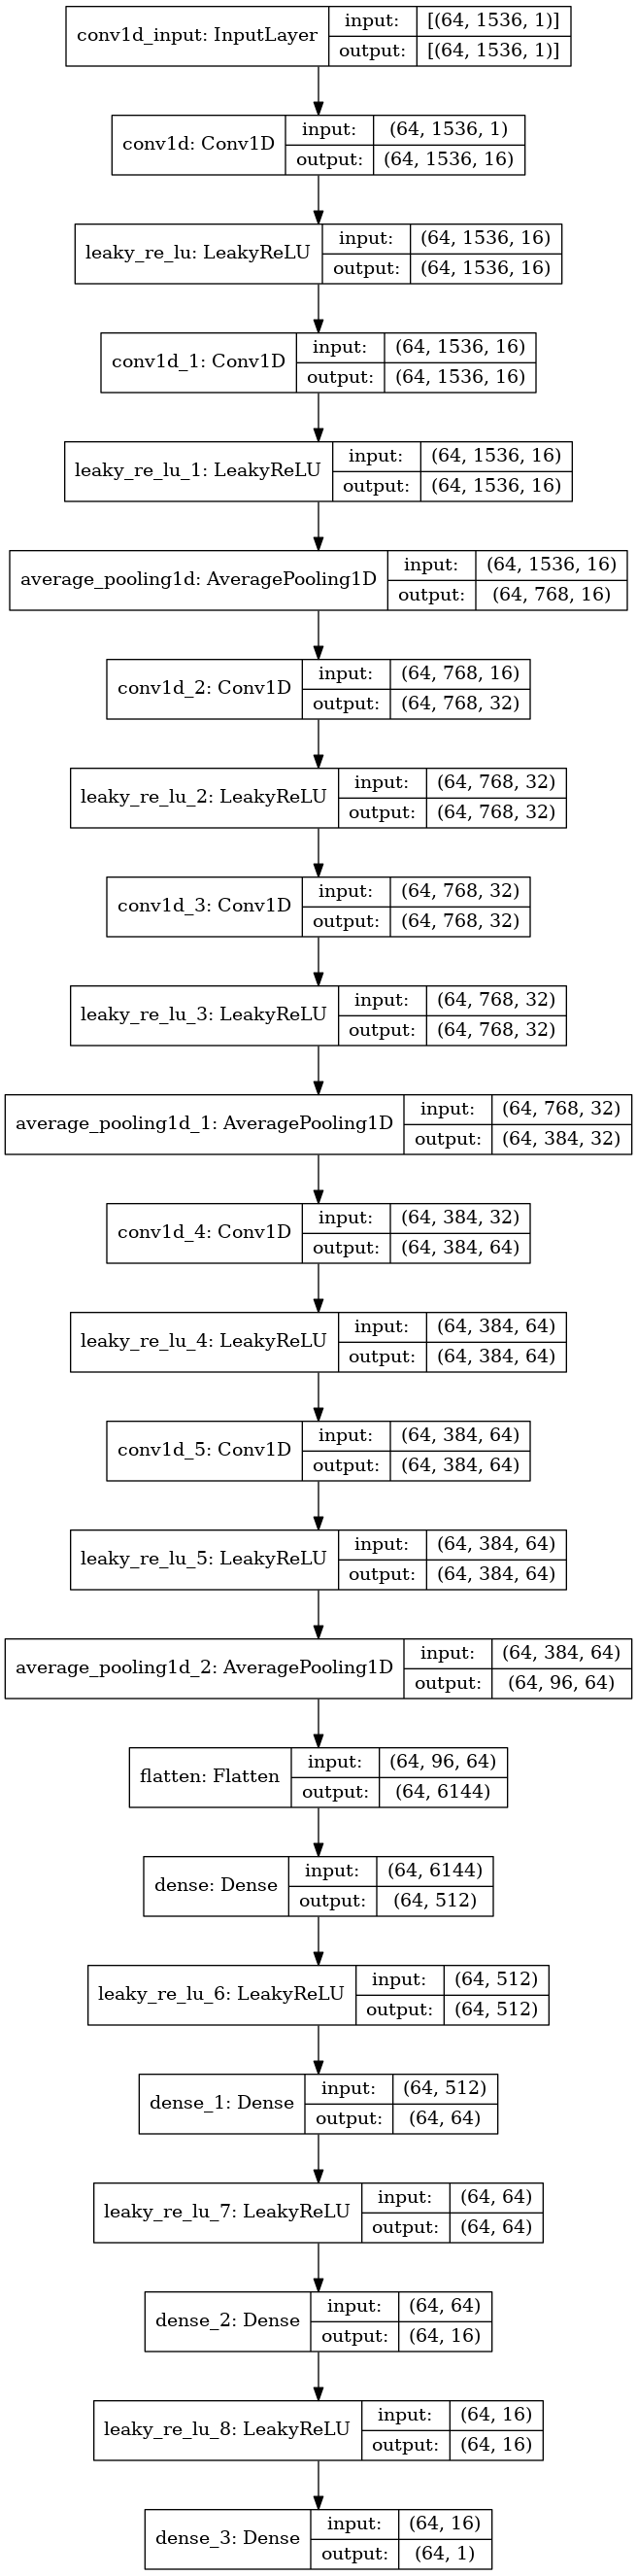

In [16]:
detector = define_detector(n_inputs=n_inputs,batch_size=batch_size)
detector.summary()
plot_model(detector, show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (64, 1, 1536)             35328     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (64, 1, 1536)             0         
_________________________________________________________________
reshape (Reshape)            (64, 24, 64)              0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (64, 48, 32)              10272     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (64, 48, 32)              0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (64, 96, 32)              5152      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (64, 96, 32)             

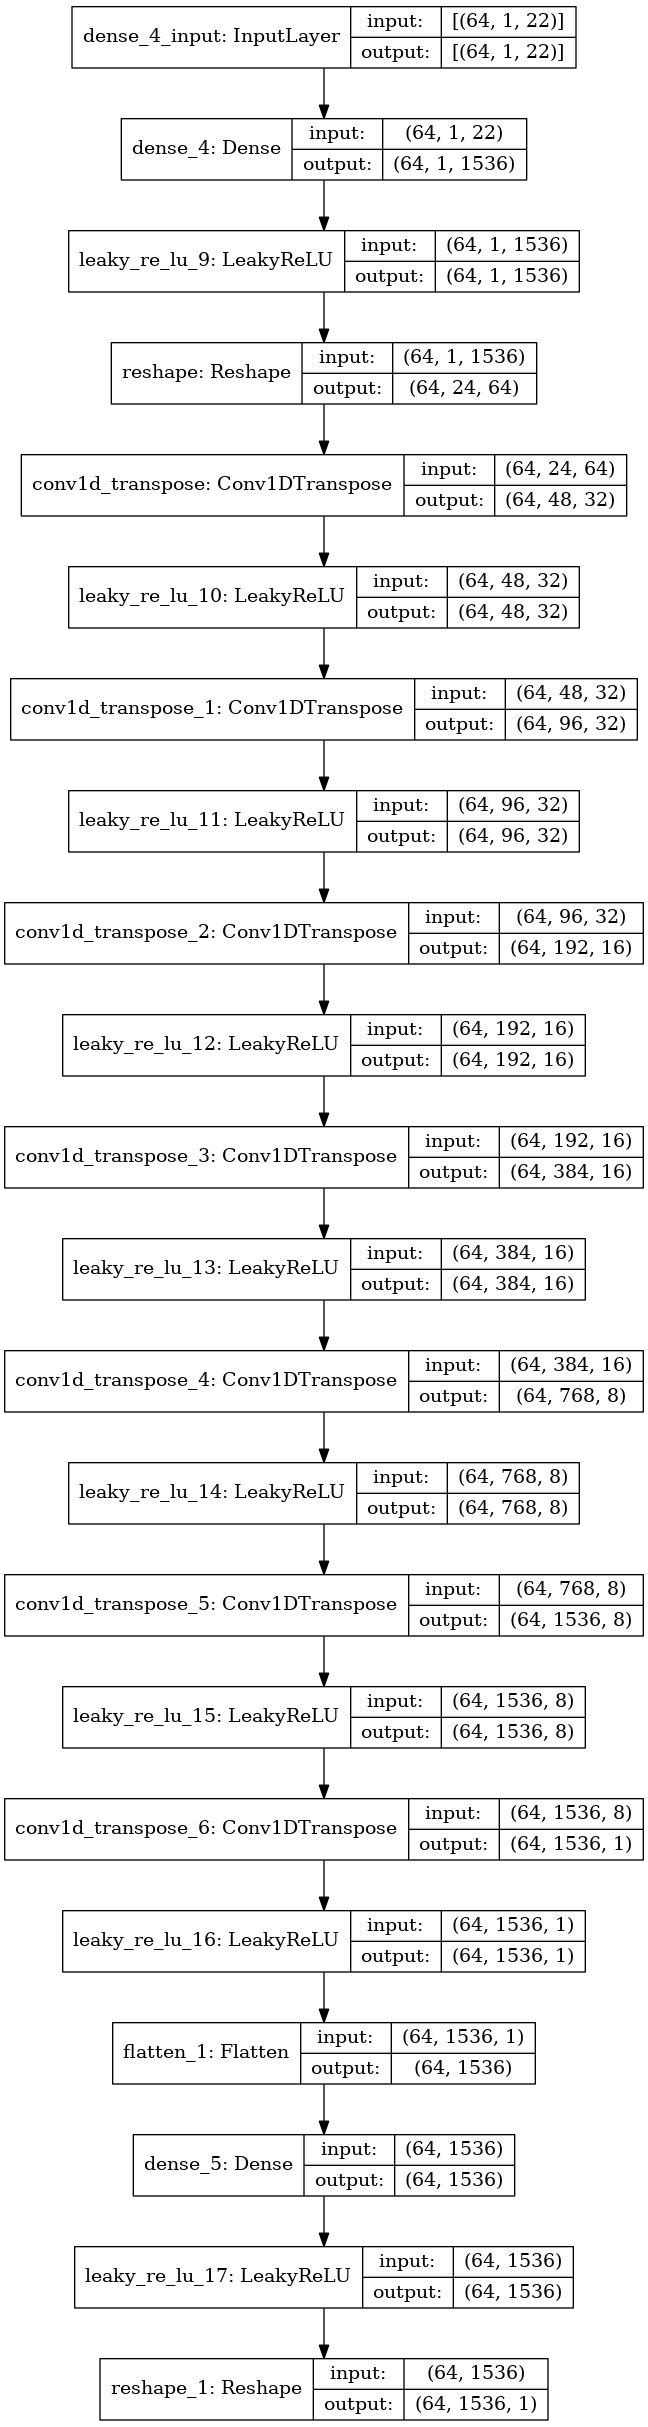

In [17]:
generator = define_generator(n_inputs=n_inputs,latent_dim=latent_dim,batch_size=batch_size)
generator.summary()
plot_model(generator, show_shapes=True, show_layer_names=True)

In [18]:
gan = define_gan(generator=generator, detector=detector, stddev=stddev, latent_dim=latent_dim,  
                      batch_size=batch_size, n_inputs=n_inputs)
gan.summary()
#plot_model(gan, show_shapes=True, show_layer_names=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 22)]           0         
_________________________________________________________________
sequential_1 (Sequential)    (64, 1536, 1)             2414537   
_________________________________________________________________
multiply (Multiply)          (64, 1536, 1)             0         
_________________________________________________________________
sequential (Sequential)      (64, 1)                   3231857   
Total params: 5,646,394
Trainable params: 2,414,537
Non-trainable params: 3,231,857
_________________________________________________________________


Train the models for all `"ee"` auto-correlations of good antennas for night of `2459122`.

Epoch: 25 
Training Data - Acc_Real: 1.0 | Acc_Fake: 1.0
Validation Data - Acc: 1.0


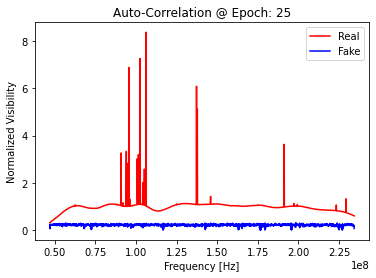

Epoch: 50 
Training Data - Acc_Real: 1.0 | Acc_Fake: 0.0
Validation Data - Acc: 1.0


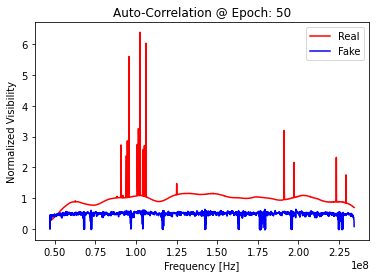

Epoch: 75 
Training Data - Acc_Real: 1.0 | Acc_Fake: 0.0
Validation Data - Acc: 1.0


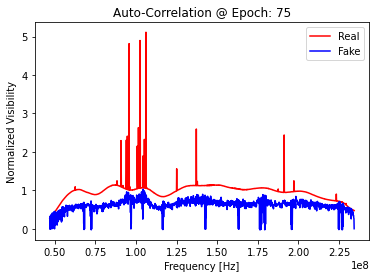

Epoch: 100 
Training Data - Acc_Real: 1.0 | Acc_Fake: 0.0
Validation Data - Acc: 1.0


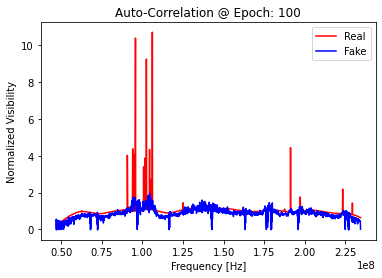

Epoch: 125 
Training Data - Acc_Real: 0.953125 | Acc_Fake: 0.546875
Validation Data - Acc: 0.8878633379936218


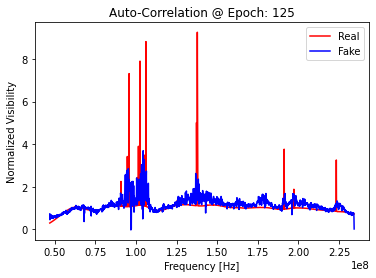

Epoch: 150 
Training Data - Acc_Real: 0.109375 | Acc_Fake: 1.0
Validation Data - Acc: 0.04927859082818031


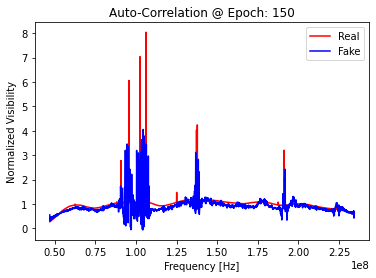

Epoch: 175 
Training Data - Acc_Real: 0.4375 | Acc_Fake: 0.71875
Validation Data - Acc: 0.4934754967689514


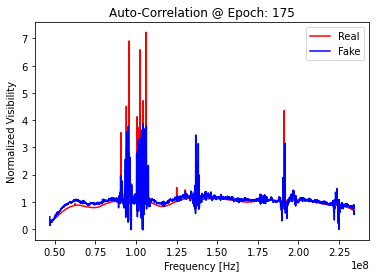

Epoch: 200 
Training Data - Acc_Real: 0.625 | Acc_Fake: 1.0
Validation Data - Acc: 0.5863038301467896


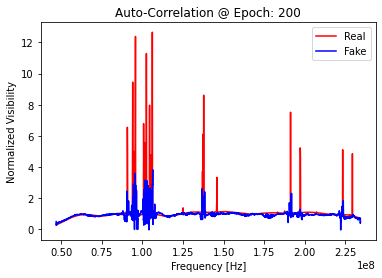

Epoch: 225 
Training Data - Acc_Real: 0.765625 | Acc_Fake: 1.0
Validation Data - Acc: 0.7631551027297974


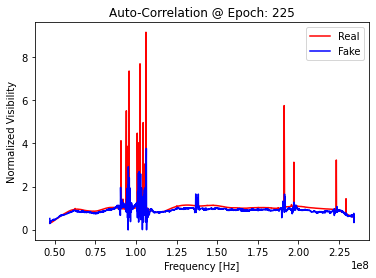

Epoch: 250 
Training Data - Acc_Real: 0.484375 | Acc_Fake: 1.0
Validation Data - Acc: 0.4069064259529114


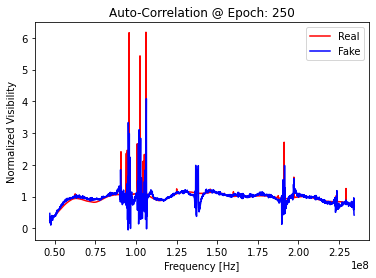

Epoch: 275 
Training Data - Acc_Real: 0.859375 | Acc_Fake: 1.0
Validation Data - Acc: 0.8358264565467834


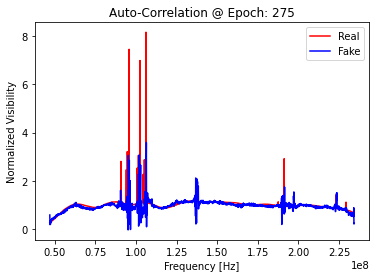

Epoch: 300 
Training Data - Acc_Real: 0.921875 | Acc_Fake: 1.0
Validation Data - Acc: 0.7954593896865845


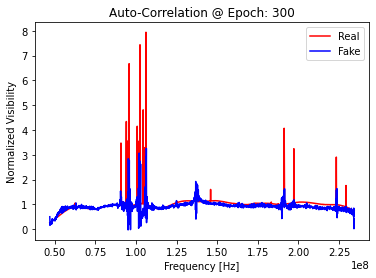

Epoch: 325 
Training Data - Acc_Real: 0.828125 | Acc_Fake: 1.0
Validation Data - Acc: 0.8486102223396301


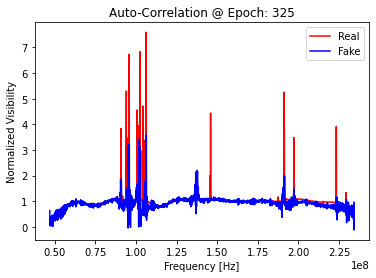

Epoch: 350 
Training Data - Acc_Real: 0.953125 | Acc_Fake: 1.0
Validation Data - Acc: 0.9377254247665405


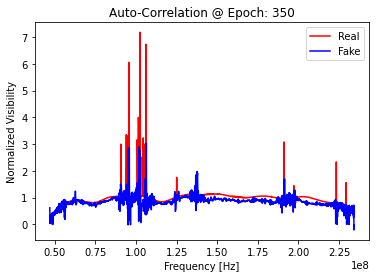

Epoch: 375 
Training Data - Acc_Real: 0.9375 | Acc_Fake: 1.0
Validation Data - Acc: 0.9334288239479065


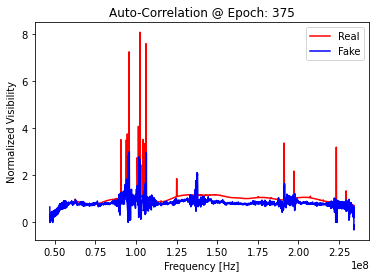

Epoch: 400 
Training Data - Acc_Real: 1.0 | Acc_Fake: 1.0
Validation Data - Acc: 0.9405367970466614


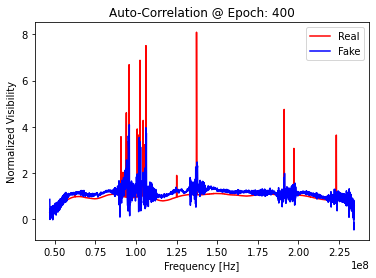

Epoch: 425 
Training Data - Acc_Real: 0.921875 | Acc_Fake: 1.0
Validation Data - Acc: 0.9596859812736511


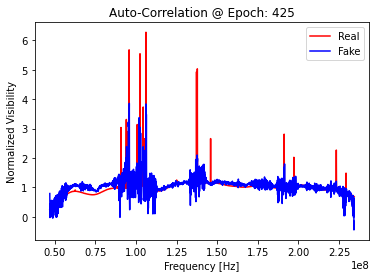

Epoch: 450 
Training Data - Acc_Real: 0.859375 | Acc_Fake: 1.0
Validation Data - Acc: 0.8898259997367859


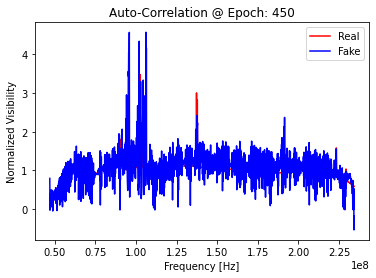

Epoch: 475 
Training Data - Acc_Real: 0.9375 | Acc_Fake: 1.0
Validation Data - Acc: 0.9705601334571838


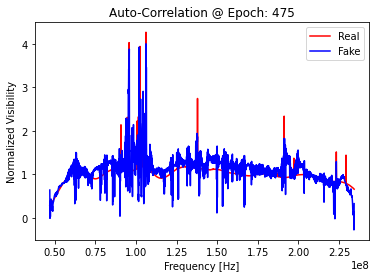

Epoch: 500 
Training Data - Acc_Real: 0.96875 | Acc_Fake: 1.0
Validation Data - Acc: 0.9630277752876282


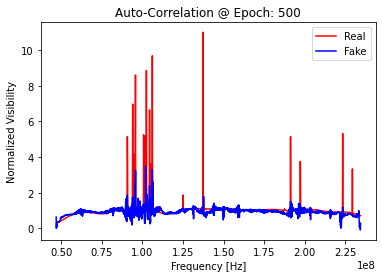

Epoch: 525 
Training Data - Acc_Real: 0.921875 | Acc_Fake: 1.0
Validation Data - Acc: 0.9165605902671814


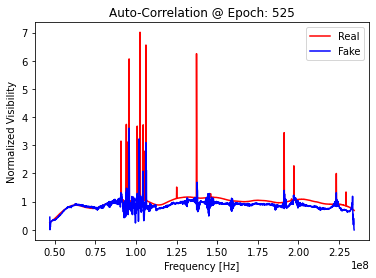

Epoch: 550 
Training Data - Acc_Real: 0.796875 | Acc_Fake: 0.796875
Validation Data - Acc: 0.7633142471313477


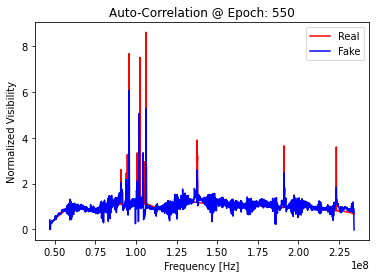

Epoch: 575 
Training Data - Acc_Real: 0.9375 | Acc_Fake: 0.953125
Validation Data - Acc: 0.8869615793228149


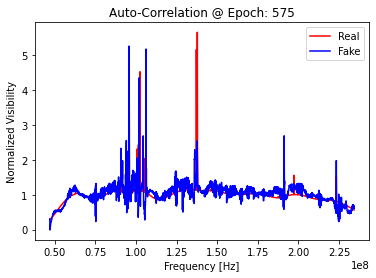

Epoch: 600 
Training Data - Acc_Real: 0.921875 | Acc_Fake: 1.0
Validation Data - Acc: 0.9054211974143982


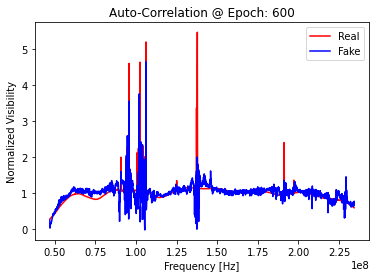

Epoch: 625 
Training Data - Acc_Real: 0.96875 | Acc_Fake: 1.0
Validation Data - Acc: 0.970666229724884


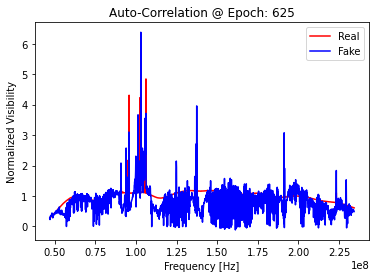

Epoch: 650 
Training Data - Acc_Real: 1.0 | Acc_Fake: 1.0
Validation Data - Acc: 0.9923615455627441


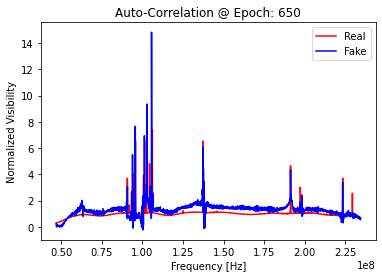

Epoch: 675 
Training Data - Acc_Real: 0.96875 | Acc_Fake: 1.0
Validation Data - Acc: 0.8932209014892578


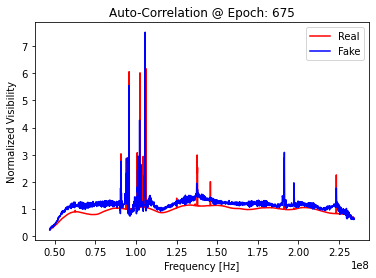

Epoch: 700 
Training Data - Acc_Real: 0.921875 | Acc_Fake: 1.0
Validation Data - Acc: 0.9649904370307922


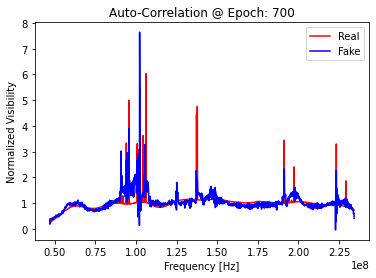

Epoch: 725 
Training Data - Acc_Real: 0.328125 | Acc_Fake: 0.0
Validation Data - Acc: 0.9857839941978455


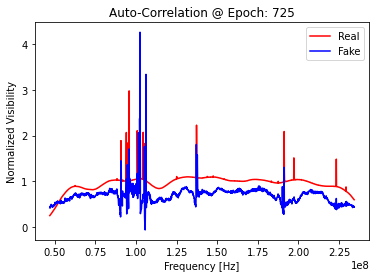

Epoch: 750 
Training Data - Acc_Real: 0.375 | Acc_Fake: 0.84375
Validation Data - Acc: 0.42605558037757874


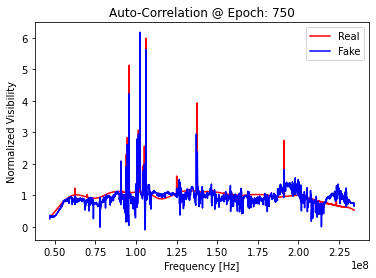

Epoch: 775 
Training Data - Acc_Real: 0.390625 | Acc_Fake: 1.0
Validation Data - Acc: 0.5095480680465698


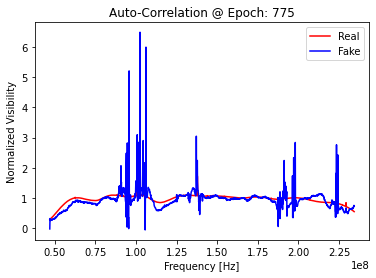

Epoch: 800 
Training Data - Acc_Real: 0.015625 | Acc_Fake: 1.0
Validation Data - Acc: 0.0


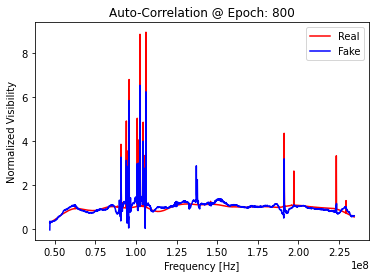

Epoch: 825 
Training Data - Acc_Real: 0.46875 | Acc_Fake: 0.921875
Validation Data - Acc: 0.4826543629169464


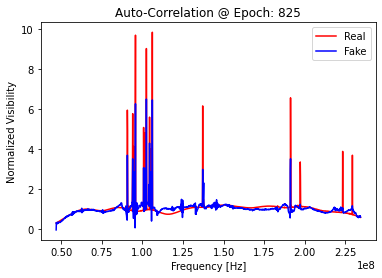

Epoch: 850 
Training Data - Acc_Real: 0.375 | Acc_Fake: 0.578125
Validation Data - Acc: 0.09240398555994034


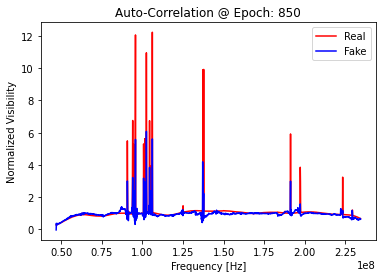

Epoch: 875 
Training Data - Acc_Real: 0.46875 | Acc_Fake: 0.546875
Validation Data - Acc: 0.06848079711198807


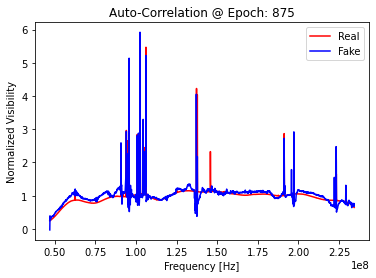

Epoch: 900 
Training Data - Acc_Real: 0.046875 | Acc_Fake: 1.0
Validation Data - Acc: 0.024294504895806313


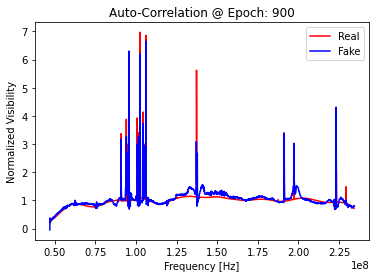

Epoch: 925 
Training Data - Acc_Real: 0.109375 | Acc_Fake: 0.96875
Validation Data - Acc: 0.14072777330875397


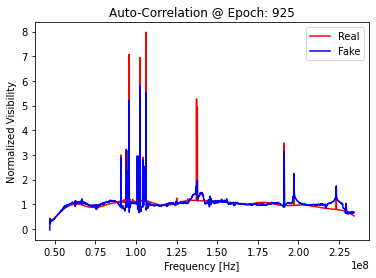

Epoch: 950 
Training Data - Acc_Real: 0.0 | Acc_Fake: 0.984375
Validation Data - Acc: 0.05956927686929703


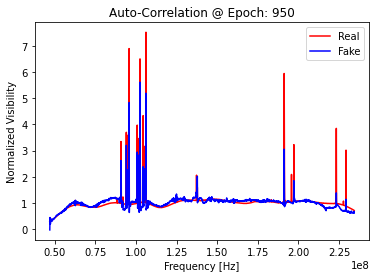

Epoch: 975 
Training Data - Acc_Real: 0.078125 | Acc_Fake: 0.78125
Validation Data - Acc: 0.06317631900310516


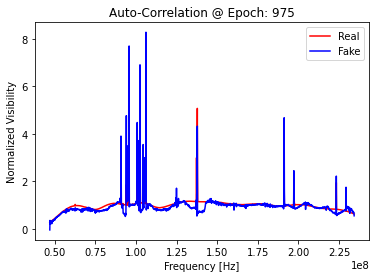

Epoch: 1000 
Training Data - Acc_Real: 0.1875 | Acc_Fake: 0.984375
Validation Data - Acc: 0.1831105500459671


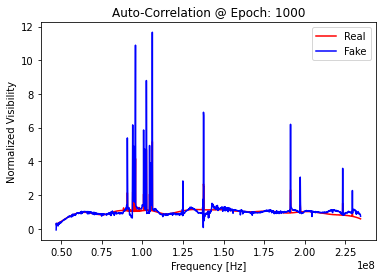

Epoch: 1025 
Training Data - Acc_Real: 0.046875 | Acc_Fake: 0.96875
Validation Data - Acc: 0.035805217921733856


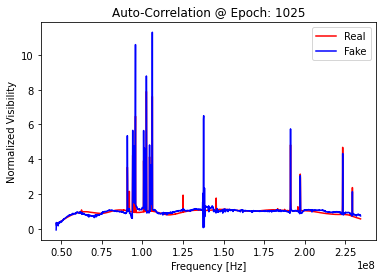

Epoch: 1050 
Training Data - Acc_Real: 0.046875 | Acc_Fake: 0.875
Validation Data - Acc: 0.03686611354351044


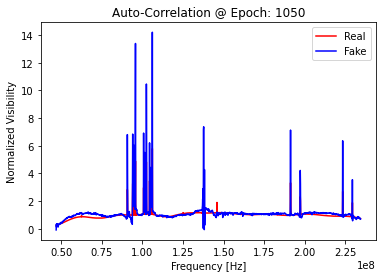

Epoch: 1075 
Training Data - Acc_Real: 0.25 | Acc_Fake: 0.921875
Validation Data - Acc: 0.1660301238298416


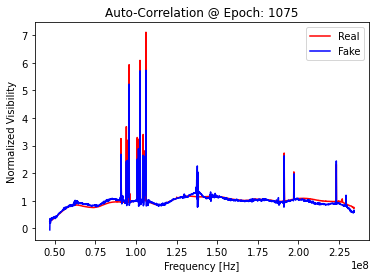

Epoch: 1100 
Training Data - Acc_Real: 0.265625 | Acc_Fake: 0.84375
Validation Data - Acc: 0.15860386192798615


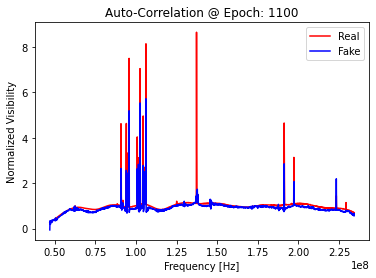

Epoch: 1125 
Training Data - Acc_Real: 0.234375 | Acc_Fake: 0.96875
Validation Data - Acc: 0.3291958272457123


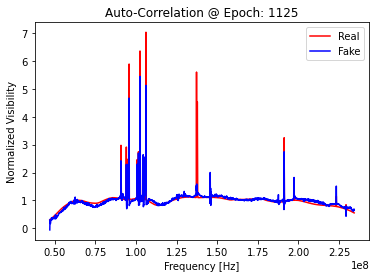

Epoch: 1150 
Training Data - Acc_Real: 0.46875 | Acc_Fake: 0.796875
Validation Data - Acc: 0.49204328656196594


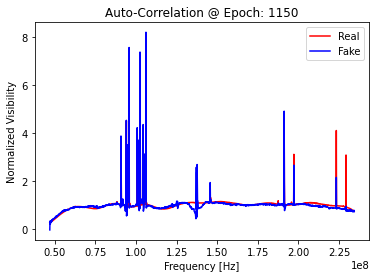

Epoch: 1175 
Training Data - Acc_Real: 0.46875 | Acc_Fake: 0.515625
Validation Data - Acc: 0.39226606488227844


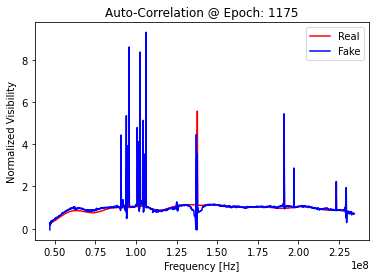

Epoch: 1200 
Training Data - Acc_Real: 0.21875 | Acc_Fake: 1.0
Validation Data - Acc: 0.13155102729797363


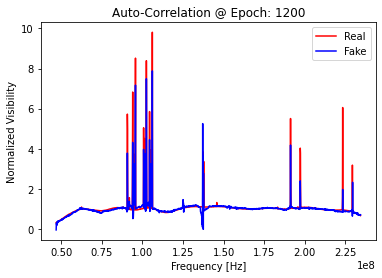

Epoch: 1225 
Training Data - Acc_Real: 0.34375 | Acc_Fake: 0.96875
Validation Data - Acc: 0.30893275141716003


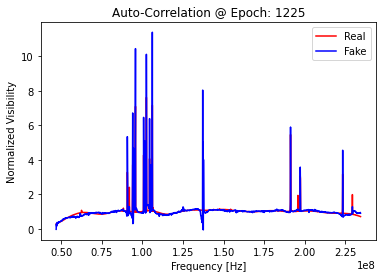

Epoch: 1250 
Training Data - Acc_Real: 0.5625 | Acc_Fake: 0.875
Validation Data - Acc: 0.4225015938282013


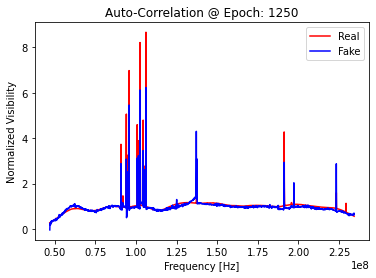

Epoch: 1275 
Training Data - Acc_Real: 0.5 | Acc_Fake: 0.890625
Validation Data - Acc: 0.5185656547546387


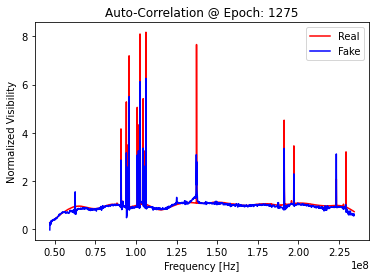

Epoch: 1300 
Training Data - Acc_Real: 0.734375 | Acc_Fake: 1.0
Validation Data - Acc: 0.7786971926689148


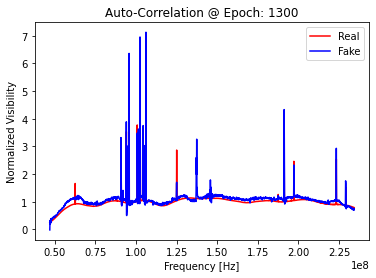

Epoch: 1325 
Training Data - Acc_Real: 0.609375 | Acc_Fake: 0.859375
Validation Data - Acc: 0.6311266422271729


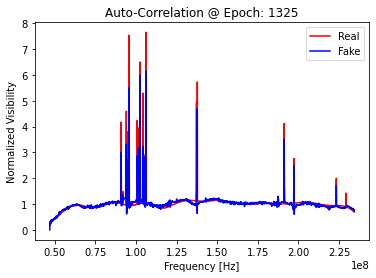

Epoch: 1350 
Training Data - Acc_Real: 0.84375 | Acc_Fake: 0.75
Validation Data - Acc: 0.6669849157333374


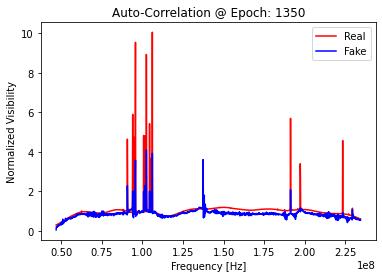

Epoch: 1375 
Training Data - Acc_Real: 0.75 | Acc_Fake: 0.875
Validation Data - Acc: 0.7665499448776245


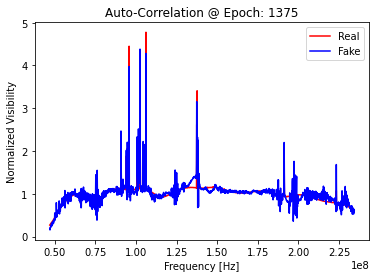

Epoch: 1400 
Training Data - Acc_Real: 0.703125 | Acc_Fake: 0.9375
Validation Data - Acc: 0.6092722415924072


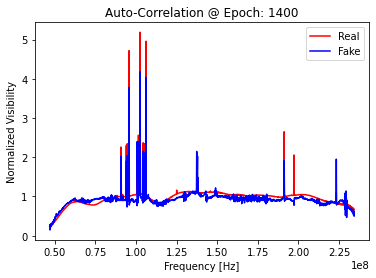

Epoch: 1425 
Training Data - Acc_Real: 0.671875 | Acc_Fake: 1.0
Validation Data - Acc: 0.7733396887779236


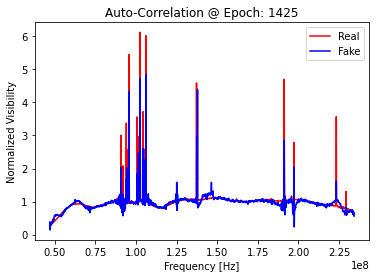

Epoch: 1450 
Training Data - Acc_Real: 0.703125 | Acc_Fake: 0.890625
Validation Data - Acc: 0.7984298467636108


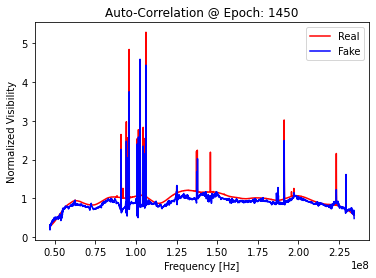

Epoch: 1475 
Training Data - Acc_Real: 0.78125 | Acc_Fake: 1.0
Validation Data - Acc: 0.7797050476074219


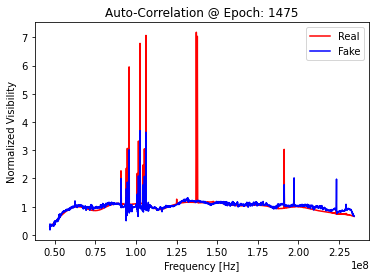

Epoch: 1500 
Training Data - Acc_Real: 0.984375 | Acc_Fake: 1.0
Validation Data - Acc: 0.9874283671379089


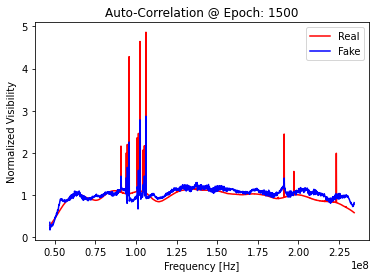

Epoch: 1525 
Training Data - Acc_Real: 0.828125 | Acc_Fake: 1.0
Validation Data - Acc: 0.7819329500198364


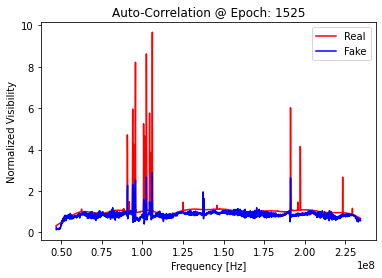

Epoch: 1550 
Training Data - Acc_Real: 0.859375 | Acc_Fake: 1.0
Validation Data - Acc: 0.8471249938011169


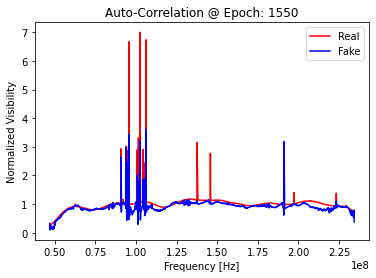

Epoch: 1575 
Training Data - Acc_Real: 0.765625 | Acc_Fake: 0.859375
Validation Data - Acc: 0.5506047010421753


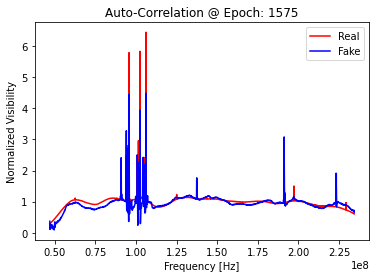

Epoch: 1600 
Training Data - Acc_Real: 0.71875 | Acc_Fake: 1.0
Validation Data - Acc: 0.662476122379303


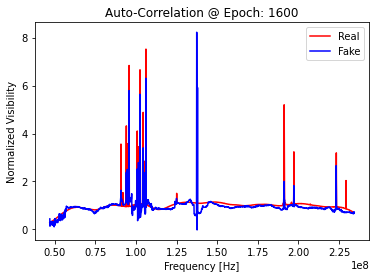

Epoch: 1625 
Training Data - Acc_Real: 0.515625 | Acc_Fake: 1.0
Validation Data - Acc: 0.531720757484436


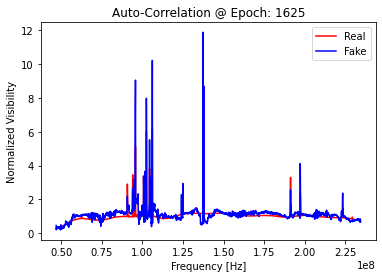

Epoch: 1650 
Training Data - Acc_Real: 0.21875 | Acc_Fake: 1.0
Validation Data - Acc: 0.2603967785835266


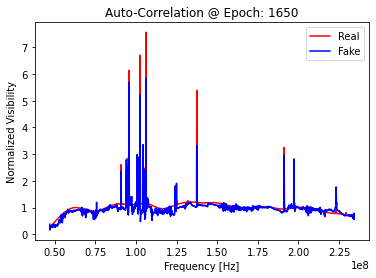

Epoch: 1675 
Training Data - Acc_Real: 0.53125 | Acc_Fake: 1.0
Validation Data - Acc: 0.5915022492408752


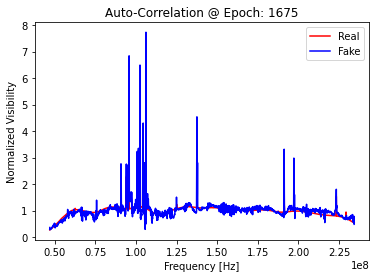

Epoch: 1700 
Training Data - Acc_Real: 0.21875 | Acc_Fake: 1.0
Validation Data - Acc: 0.11993422359228134


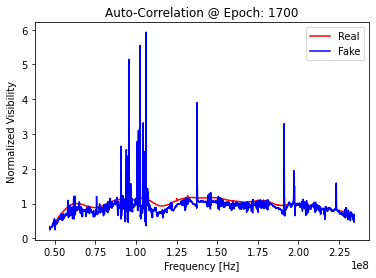

Epoch: 1725 
Training Data - Acc_Real: 0.03125 | Acc_Fake: 1.0
Validation Data - Acc: 0.06837470829486847


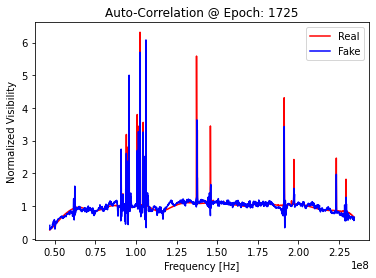

Epoch: 1750 
Training Data - Acc_Real: 0.46875 | Acc_Fake: 1.0
Validation Data - Acc: 0.4049437642097473


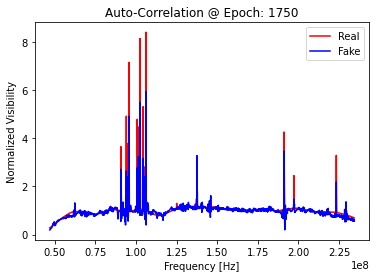

Epoch: 1775 
Training Data - Acc_Real: 0.4375 | Acc_Fake: 0.984375
Validation Data - Acc: 0.5039253234863281


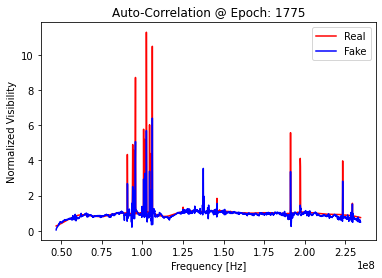

Epoch: 1800 
Training Data - Acc_Real: 0.53125 | Acc_Fake: 0.984375
Validation Data - Acc: 0.5358582735061646


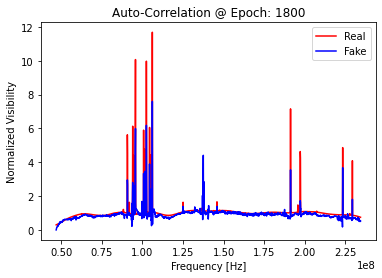

Epoch: 1825 
Training Data - Acc_Real: 0.46875 | Acc_Fake: 1.0
Validation Data - Acc: 0.5158073306083679


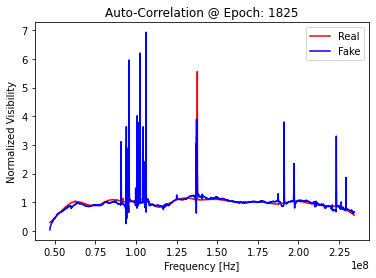

Epoch: 1850 
Training Data - Acc_Real: 0.515625 | Acc_Fake: 1.0
Validation Data - Acc: 0.5607892870903015


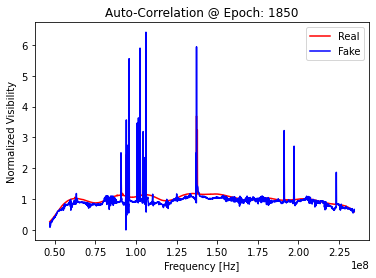

Epoch: 1875 
Training Data - Acc_Real: 0.34375 | Acc_Fake: 1.0
Validation Data - Acc: 0.2776893675327301


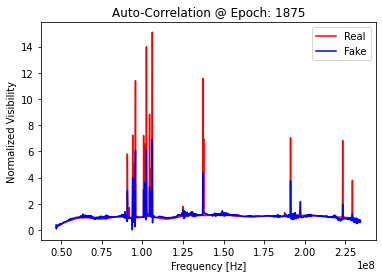

Epoch: 1900 
Training Data - Acc_Real: 0.640625 | Acc_Fake: 1.0
Validation Data - Acc: 0.7173774838447571


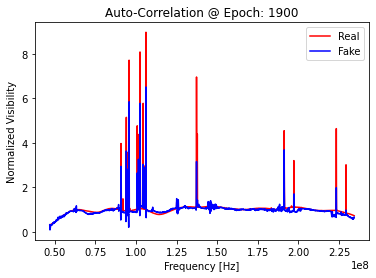

Epoch: 1925 
Training Data - Acc_Real: 0.75 | Acc_Fake: 1.0
Validation Data - Acc: 0.7803946733474731


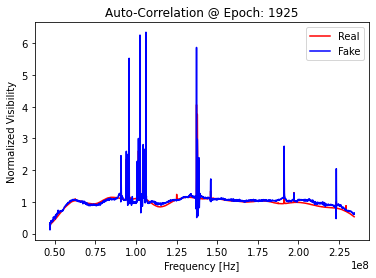

Epoch: 1950 
Training Data - Acc_Real: 0.90625 | Acc_Fake: 0.46875
Validation Data - Acc: 0.6136218905448914


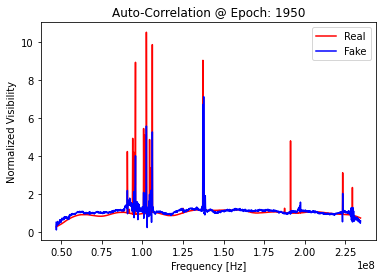

Epoch: 1975 
Training Data - Acc_Real: 0.71875 | Acc_Fake: 1.0
Validation Data - Acc: 0.7632081508636475


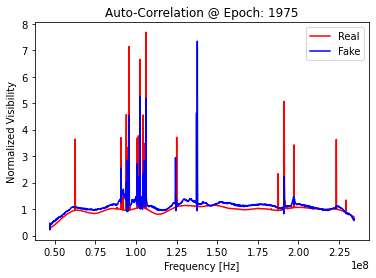

Epoch: 2000 
Training Data - Acc_Real: 0.828125 | Acc_Fake: 0.890625
Validation Data - Acc: 0.7117016911506653


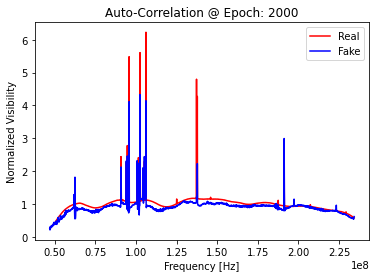

Epoch: 2025 
Training Data - Acc_Real: 0.515625 | Acc_Fake: 0.96875
Validation Data - Acc: 0.7567897439002991


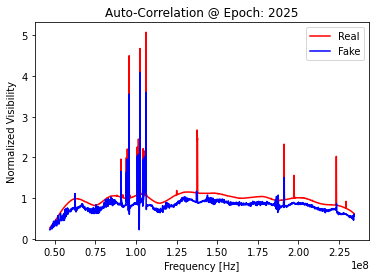

Epoch: 2050 
Training Data - Acc_Real: 0.8125 | Acc_Fake: 1.0
Validation Data - Acc: 0.7917462587356567


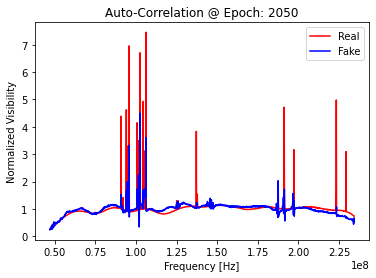

Epoch: 2075 
Training Data - Acc_Real: 0.71875 | Acc_Fake: 0.890625
Validation Data - Acc: 0.7572140693664551


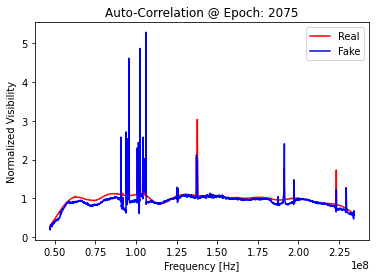

Epoch: 2100 
Training Data - Acc_Real: 0.8125 | Acc_Fake: 0.71875
Validation Data - Acc: 0.7117016911506653


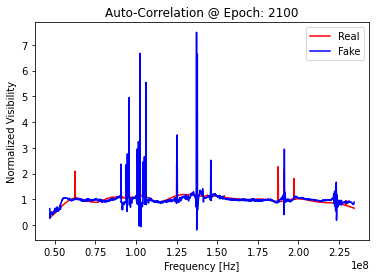

Epoch: 2125 
Training Data - Acc_Real: 0.734375 | Acc_Fake: 1.0
Validation Data - Acc: 0.7758328318595886


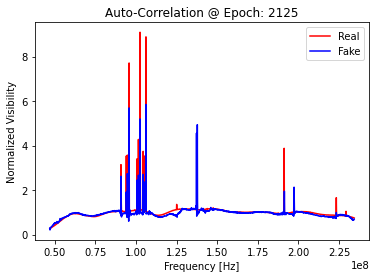

Epoch: 2150 
Training Data - Acc_Real: 0.671875 | Acc_Fake: 1.0
Validation Data - Acc: 0.7555166482925415


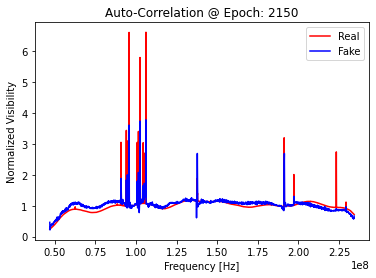

Epoch: 2175 
Training Data - Acc_Real: 0.625 | Acc_Fake: 0.796875
Validation Data - Acc: 0.6299066543579102


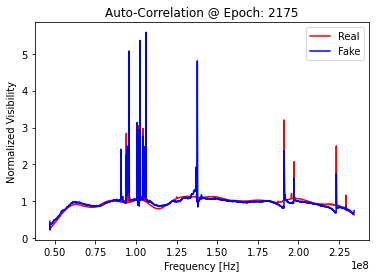

Epoch: 2200 
Training Data - Acc_Real: 0.59375 | Acc_Fake: 1.0
Validation Data - Acc: 0.6157967448234558


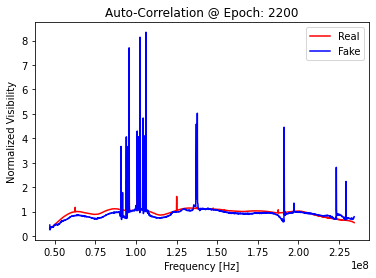

Epoch: 2225 
Training Data - Acc_Real: 0.703125 | Acc_Fake: 1.0
Validation Data - Acc: 0.7522809505462646


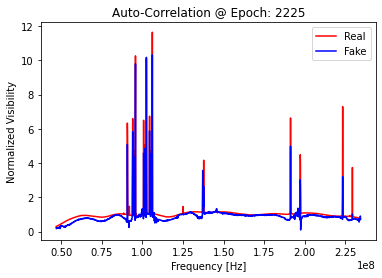

Epoch: 2250 
Training Data - Acc_Real: 0.71875 | Acc_Fake: 0.96875
Validation Data - Acc: 0.8367282152175903


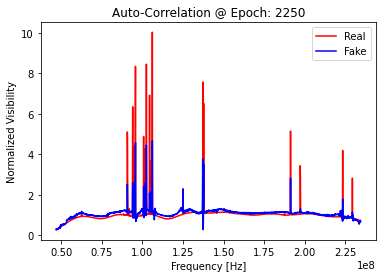

Epoch: 2275 
Training Data - Acc_Real: 0.515625 | Acc_Fake: 0.875
Validation Data - Acc: 0.6116061806678772


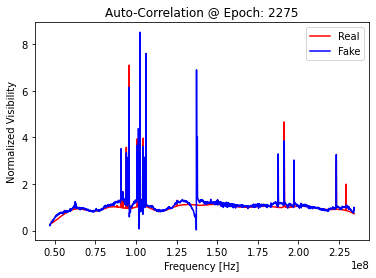

Epoch: 2300 
Training Data - Acc_Real: 0.453125 | Acc_Fake: 1.0
Validation Data - Acc: 0.5669425129890442


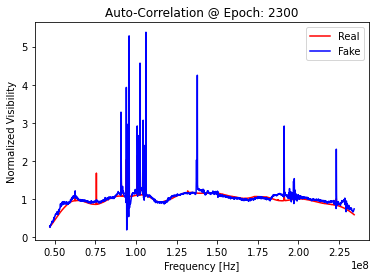

Epoch: 2325 
Training Data - Acc_Real: 0.625 | Acc_Fake: 1.0
Validation Data - Acc: 0.591343104839325


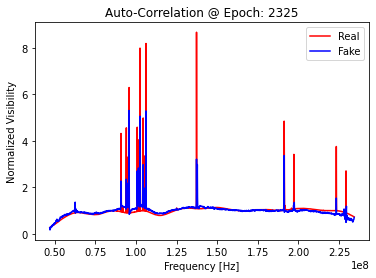

Epoch: 2350 
Training Data - Acc_Real: 0.765625 | Acc_Fake: 0.84375
Validation Data - Acc: 0.6875132322311401


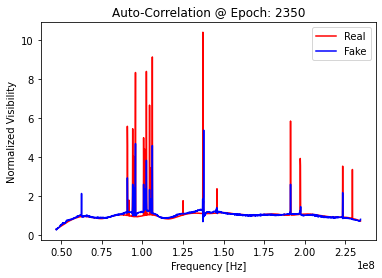

Epoch: 2375 
Training Data - Acc_Real: 0.78125 | Acc_Fake: 1.0
Validation Data - Acc: 0.765436053276062


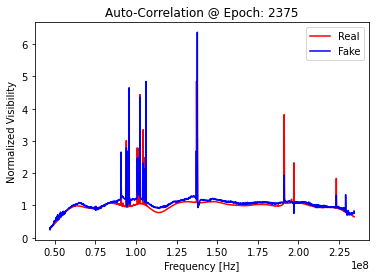

Epoch: 2400 
Training Data - Acc_Real: 0.5625 | Acc_Fake: 0.765625
Validation Data - Acc: 0.6356885433197021


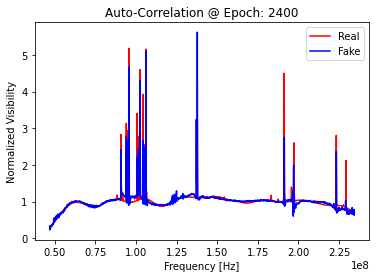

Epoch: 2425 
Training Data - Acc_Real: 0.84375 | Acc_Fake: 1.0
Validation Data - Acc: 0.8004986047744751


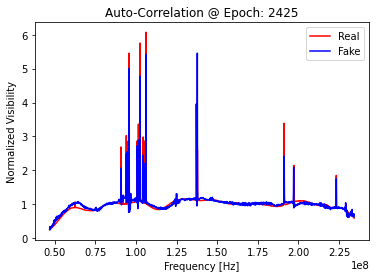

Epoch: 2450 
Training Data - Acc_Real: 0.828125 | Acc_Fake: 1.0
Validation Data - Acc: 0.8735942840576172


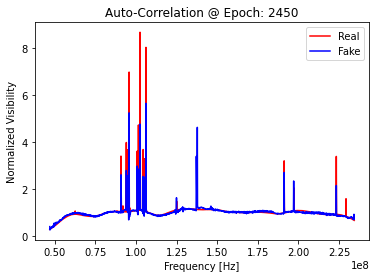

Epoch: 2475 
Training Data - Acc_Real: 0.75 | Acc_Fake: 1.0
Validation Data - Acc: 0.8890303373336792


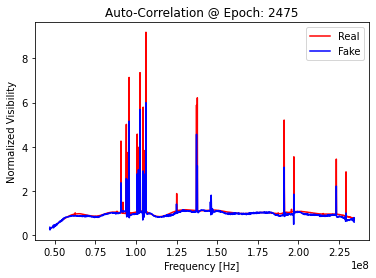

Epoch: 2500 
Training Data - Acc_Real: 0.9375 | Acc_Fake: 0.96875
Validation Data - Acc: 0.5718756914138794


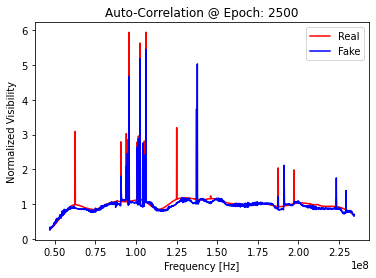

Epoch: 2525 
Training Data - Acc_Real: 0.515625 | Acc_Fake: 1.0
Validation Data - Acc: 0.7283046841621399


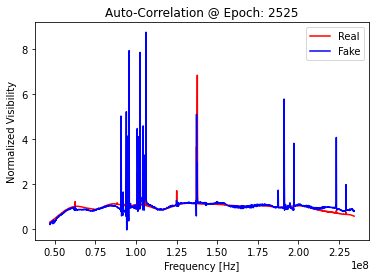

Epoch: 2550 
Training Data - Acc_Real: 0.484375 | Acc_Fake: 0.4375
Validation Data - Acc: 0.43517929315567017


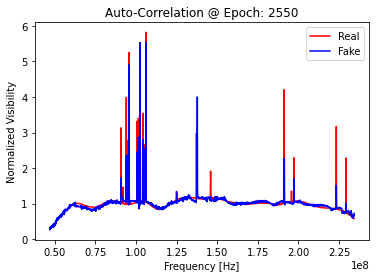

In [ ]:
train(generator=generator, detector=detector, gan=gan, latent_dim=latent_dim, 
      n_inputs=n_inputs, n_epochs=n_epochs, n_eval=n_eval, batch_size=batch_size
      ,ratio=ratio,good_key=good_key_ee,data=auto_data_train, val_data=auto_data_valid, freqs=freqs, save_run=save_run, dir_name=dir_name, filepath_to_save=filepath_to_save,
      date_time=date_time, model_comments=model_comments, reference_notes=reference_notes, detector_layout=detector_layout,
      generator_layout=generator_layout, gan_layout=gan_layout, run_num=run_num, commit=commit)

Cell below is used to load in previous models. Changes dependent on desired model.

In [ ]:
generator = keras.models.load_model('practice-training_ID-5.2/generator.h5')
detector = keras.models.load_model('practice-training_ID-5.2/detector.h5')
gan = keras.models.load_model('practice-training_ID-5.2/gan.h5')

In [62]:
generator.save('practice_training_ID-9/generator.h5')
detector.save('practice_training_ID-9/detector.h5')
gan.save('practice_training_ID-9/gan.h5')

## 3. Files and keys required for configuring data in Section 1 for GAN training.

Bad antennas for night of `2459122`.

In [15]:
bad_ants = [0, 1, 2, 11, 12, 13, 14, 23, 24, 25, 26, 37, 38, 39, 44, 45, 46, 51, 52, 59, 65, 67, 73, 75, 81, 84, 86, 87, 88, 89, 90, 93, 94, 101, 107, 110, 111, 112, 116, 119, 121, 122, 123, 136, 137, 138, 142, 145, 155, 161, 166, 177, 179, 180, 182, 183, 184, 186, 187]

Save files. Not used after initial file creations.

In [26]:
# with open("bad-ant-keys_2459122.txt", "w") as f:
#     for s in bad_key:
#         f.write(str(s) +",\n")

Load in files and read to list

In [5]:
bad_key = open("good-ant-keys_2459122.txt", "r")
bad_key = bad_key.readlines()
bad_key = [eval(k.replace(',\n','')) for k in bad_key]

In [26]:
bad_key # check if list is formatted properly

[(36, 36, 'ee'),
 (36, 36, 'nn'),
 (50, 50, 'ee'),
 (50, 50, 'nn'),
 (53, 53, 'ee'),
 (53, 53, 'nn'),
 (58, 58, 'ee'),
 (58, 58, 'nn'),
 (66, 66, 'ee'),
 (66, 66, 'nn'),
 (68, 68, 'ee'),
 (68, 68, 'nn'),
 (82, 82, 'ee'),
 (82, 82, 'nn'),
 (83, 83, 'ee'),
 (83, 83, 'nn'),
 (85, 85, 'ee'),
 (85, 85, 'nn'),
 (91, 91, 'ee'),
 (91, 91, 'nn'),
 (92, 92, 'ee'),
 (92, 92, 'nn'),
 (98, 98, 'ee'),
 (98, 98, 'nn'),
 (99, 99, 'ee'),
 (99, 99, 'nn'),
 (100, 100, 'ee'),
 (100, 100, 'nn'),
 (102, 102, 'ee'),
 (102, 102, 'nn'),
 (103, 103, 'ee'),
 (103, 103, 'nn'),
 (104, 104, 'ee'),
 (104, 104, 'nn'),
 (105, 105, 'ee'),
 (105, 105, 'nn'),
 (108, 108, 'ee'),
 (108, 108, 'nn'),
 (109, 109, 'ee'),
 (109, 109, 'nn'),
 (117, 117, 'ee'),
 (117, 117, 'nn'),
 (118, 118, 'ee'),
 (118, 118, 'nn'),
 (120, 120, 'ee'),
 (120, 120, 'nn'),
 (124, 124, 'ee'),
 (124, 124, 'nn'),
 (127, 127, 'ee'),
 (127, 127, 'nn'),
 (128, 128, 'ee'),
 (128, 128, 'nn'),
 (129, 129, 'ee'),
 (129, 129, 'nn'),
 (130, 130, 'ee'),
 (130, 

Files associated to auto-correlations from night of `24591221.`

In [8]:
filename = ['zen.2459122.25108.sum.autos.uvh5','zen.2459122.45934.sum.autos.uvh5',
'zen.2459122.25131.sum.autos.uvh5','zen.2459122.45957.sum.autos.uvh5',
'zen.2459122.25153.sum.autos.uvh5','zen.2459122.45979.sum.autos.uvh5',
'zen.2459122.25175.sum.autos.uvh5','zen.2459122.46002.sum.autos.uvh5',
'zen.2459122.25198.sum.autos.uvh5','zen.2459122.46024.sum.autos.uvh5',
'zen.2459122.25220.sum.autos.uvh5','zen.2459122.46046.sum.autos.uvh5',
'zen.2459122.25243.sum.autos.uvh5','zen.2459122.46069.sum.autos.uvh5',
'zen.2459122.25265.sum.autos.uvh5','zen.2459122.46091.sum.autos.uvh5',
'zen.2459122.25287.sum.autos.uvh5','zen.2459122.46113.sum.autos.uvh5',
'zen.2459122.25310.sum.autos.uvh5','zen.2459122.46136.sum.autos.uvh5',
'zen.2459122.25332.sum.autos.uvh5','zen.2459122.46158.sum.autos.uvh5',
'zen.2459122.25354.sum.autos.uvh5','zen.2459122.46181.sum.autos.uvh5',
'zen.2459122.25377.sum.autos.uvh5','zen.2459122.46203.sum.autos.uvh5',
'zen.2459122.25399.sum.autos.uvh5','zen.2459122.46225.sum.autos.uvh5',
'zen.2459122.25422.sum.autos.uvh5','zen.2459122.46248.sum.autos.uvh5',
'zen.2459122.25444.sum.autos.uvh5','zen.2459122.46270.sum.autos.uvh5',
'zen.2459122.25466.sum.autos.uvh5','zen.2459122.46292.sum.autos.uvh5',
'zen.2459122.25489.sum.autos.uvh5','zen.2459122.46315.sum.autos.uvh5',
'zen.2459122.25511.sum.autos.uvh5','zen.2459122.46337.sum.autos.uvh5',
'zen.2459122.25533.sum.autos.uvh5','zen.2459122.46360.sum.autos.uvh5',
'zen.2459122.25556.sum.autos.uvh5','zen.2459122.46382.sum.autos.uvh5',
'zen.2459122.25578.sum.autos.uvh5','zen.2459122.46404.sum.autos.uvh5',
'zen.2459122.25601.sum.autos.uvh5','zen.2459122.46427.sum.autos.uvh5',
'zen.2459122.25623.sum.autos.uvh5','zen.2459122.46449.sum.autos.uvh5',
'zen.2459122.25645.sum.autos.uvh5','zen.2459122.46471.sum.autos.uvh5',
'zen.2459122.25668.sum.autos.uvh5','zen.2459122.46494.sum.autos.uvh5',
'zen.2459122.25690.sum.autos.uvh5','zen.2459122.46516.sum.autos.uvh5',
'zen.2459122.25712.sum.autos.uvh5','zen.2459122.46538.sum.autos.uvh5',
'zen.2459122.25735.sum.autos.uvh5','zen.2459122.46561.sum.autos.uvh5',
'zen.2459122.25757.sum.autos.uvh5','zen.2459122.46583.sum.autos.uvh5',
'zen.2459122.25779.sum.autos.uvh5','zen.2459122.46606.sum.autos.uvh5',
'zen.2459122.25802.sum.autos.uvh5','zen.2459122.46628.sum.autos.uvh5',
'zen.2459122.25824.sum.autos.uvh5','zen.2459122.46650.sum.autos.uvh5',
'zen.2459122.25847.sum.autos.uvh5','zen.2459122.46673.sum.autos.uvh5',
'zen.2459122.25869.sum.autos.uvh5','zen.2459122.46695.sum.autos.uvh5',
'zen.2459122.25891.sum.autos.uvh5','zen.2459122.46717.sum.autos.uvh5',
'zen.2459122.25914.sum.autos.uvh5','zen.2459122.46740.sum.autos.uvh5',
'zen.2459122.25936.sum.autos.uvh5','zen.2459122.46762.sum.autos.uvh5',
'zen.2459122.25958.sum.autos.uvh5','zen.2459122.46785.sum.autos.uvh5',
'zen.2459122.25981.sum.autos.uvh5','zen.2459122.46807.sum.autos.uvh5',
'zen.2459122.26003.sum.autos.uvh5','zen.2459122.46829.sum.autos.uvh5',
'zen.2459122.26026.sum.autos.uvh5','zen.2459122.46852.sum.autos.uvh5',
'zen.2459122.26048.sum.autos.uvh5','zen.2459122.46874.sum.autos.uvh5',
'zen.2459122.26070.sum.autos.uvh5','zen.2459122.46896.sum.autos.uvh5',
'zen.2459122.26093.sum.autos.uvh5','zen.2459122.46919.sum.autos.uvh5',
'zen.2459122.26115.sum.autos.uvh5','zen.2459122.46941.sum.autos.uvh5',
'zen.2459122.26137.sum.autos.uvh5','zen.2459122.46963.sum.autos.uvh5',
'zen.2459122.26160.sum.autos.uvh5','zen.2459122.46986.sum.autos.uvh5',
'zen.2459122.26182.sum.autos.uvh5','zen.2459122.47008.sum.autos.uvh5',
'zen.2459122.26204.sum.autos.uvh5','zen.2459122.47031.sum.autos.uvh5',
'zen.2459122.26227.sum.autos.uvh5','zen.2459122.47053.sum.autos.uvh5',
'zen.2459122.26249.sum.autos.uvh5','zen.2459122.47075.sum.autos.uvh5',
'zen.2459122.26272.sum.autos.uvh5','zen.2459122.47098.sum.autos.uvh5',
'zen.2459122.26294.sum.autos.uvh5','zen.2459122.47120.sum.autos.uvh5',
'zen.2459122.26316.sum.autos.uvh5','zen.2459122.47142.sum.autos.uvh5',
'zen.2459122.26339.sum.autos.uvh5','zen.2459122.47165.sum.autos.uvh5',
'zen.2459122.26361.sum.autos.uvh5','zen.2459122.47187.sum.autos.uvh5',
'zen.2459122.26383.sum.autos.uvh5','zen.2459122.47210.sum.autos.uvh5',
'zen.2459122.26406.sum.autos.uvh5','zen.2459122.47232.sum.autos.uvh5',
'zen.2459122.26428.sum.autos.uvh5','zen.2459122.47254.sum.autos.uvh5',
'zen.2459122.26451.sum.autos.uvh5','zen.2459122.47277.sum.autos.uvh5',
'zen.2459122.26473.sum.autos.uvh5','zen.2459122.47299.sum.autos.uvh5',
'zen.2459122.26495.sum.autos.uvh5','zen.2459122.47321.sum.autos.uvh5',
'zen.2459122.26518.sum.autos.uvh5','zen.2459122.47344.sum.autos.uvh5',
'zen.2459122.26540.sum.autos.uvh5','zen.2459122.47366.sum.autos.uvh5',
'zen.2459122.26562.sum.autos.uvh5','zen.2459122.47389.sum.autos.uvh5',
'zen.2459122.26585.sum.autos.uvh5','zen.2459122.47411.sum.autos.uvh5',
'zen.2459122.26607.sum.autos.uvh5','zen.2459122.47433.sum.autos.uvh5',
'zen.2459122.26630.sum.autos.uvh5','zen.2459122.47456.sum.autos.uvh5',
'zen.2459122.26652.sum.autos.uvh5','zen.2459122.47478.sum.autos.uvh5',
'zen.2459122.26674.sum.autos.uvh5','zen.2459122.47500.sum.autos.uvh5',
'zen.2459122.26697.sum.autos.uvh5','zen.2459122.47523.sum.autos.uvh5',
'zen.2459122.26719.sum.autos.uvh5','zen.2459122.47545.sum.autos.uvh5',
'zen.2459122.26741.sum.autos.uvh5','zen.2459122.47567.sum.autos.uvh5',
'zen.2459122.26764.sum.autos.uvh5','zen.2459122.47590.sum.autos.uvh5',
'zen.2459122.26786.sum.autos.uvh5','zen.2459122.47612.sum.autos.uvh5',
'zen.2459122.26808.sum.autos.uvh5','zen.2459122.47635.sum.autos.uvh5',
'zen.2459122.26831.sum.autos.uvh5','zen.2459122.47657.sum.autos.uvh5',
'zen.2459122.26853.sum.autos.uvh5','zen.2459122.47679.sum.autos.uvh5',
'zen.2459122.26876.sum.autos.uvh5','zen.2459122.47702.sum.autos.uvh5',
'zen.2459122.26898.sum.autos.uvh5','zen.2459122.47724.sum.autos.uvh5',
'zen.2459122.26920.sum.autos.uvh5','zen.2459122.47746.sum.autos.uvh5',
'zen.2459122.26943.sum.autos.uvh5','zen.2459122.47769.sum.autos.uvh5',
'zen.2459122.26965.sum.autos.uvh5','zen.2459122.47791.sum.autos.uvh5',
'zen.2459122.26987.sum.autos.uvh5','zen.2459122.47814.sum.autos.uvh5',
'zen.2459122.27010.sum.autos.uvh5','zen.2459122.47836.sum.autos.uvh5',
'zen.2459122.27032.sum.autos.uvh5','zen.2459122.47858.sum.autos.uvh5',
'zen.2459122.27055.sum.autos.uvh5','zen.2459122.47881.sum.autos.uvh5',
'zen.2459122.27077.sum.autos.uvh5','zen.2459122.47903.sum.autos.uvh5',
'zen.2459122.27099.sum.autos.uvh5','zen.2459122.47925.sum.autos.uvh5',
'zen.2459122.27122.sum.autos.uvh5','zen.2459122.47948.sum.autos.uvh5',
'zen.2459122.27144.sum.autos.uvh5','zen.2459122.47970.sum.autos.uvh5',
'zen.2459122.27166.sum.autos.uvh5','zen.2459122.47992.sum.autos.uvh5',
'zen.2459122.27189.sum.autos.uvh5','zen.2459122.48015.sum.autos.uvh5',
'zen.2459122.27211.sum.autos.uvh5','zen.2459122.48037.sum.autos.uvh5',
'zen.2459122.27233.sum.autos.uvh5','zen.2459122.48060.sum.autos.uvh5',
'zen.2459122.27256.sum.autos.uvh5','zen.2459122.48082.sum.autos.uvh5',
'zen.2459122.27278.sum.autos.uvh5','zen.2459122.48104.sum.autos.uvh5',
'zen.2459122.27301.sum.autos.uvh5','zen.2459122.48127.sum.autos.uvh5',
'zen.2459122.27323.sum.autos.uvh5','zen.2459122.48149.sum.autos.uvh5',
'zen.2459122.27345.sum.autos.uvh5','zen.2459122.48171.sum.autos.uvh5',
'zen.2459122.27368.sum.autos.uvh5','zen.2459122.48194.sum.autos.uvh5',
'zen.2459122.27390.sum.autos.uvh5','zen.2459122.48216.sum.autos.uvh5',
'zen.2459122.27412.sum.autos.uvh5','zen.2459122.48239.sum.autos.uvh5',
'zen.2459122.27435.sum.autos.uvh5','zen.2459122.48261.sum.autos.uvh5',
'zen.2459122.27457.sum.autos.uvh5','zen.2459122.48283.sum.autos.uvh5',
'zen.2459122.27480.sum.autos.uvh5','zen.2459122.48306.sum.autos.uvh5',
'zen.2459122.27502.sum.autos.uvh5','zen.2459122.48328.sum.autos.uvh5',
'zen.2459122.27524.sum.autos.uvh5','zen.2459122.48350.sum.autos.uvh5',
'zen.2459122.27547.sum.autos.uvh5','zen.2459122.48373.sum.autos.uvh5',
'zen.2459122.27569.sum.autos.uvh5','zen.2459122.48395.sum.autos.uvh5',
'zen.2459122.27591.sum.autos.uvh5','zen.2459122.48418.sum.autos.uvh5',
'zen.2459122.27614.sum.autos.uvh5','zen.2459122.48440.sum.autos.uvh5',
'zen.2459122.27636.sum.autos.uvh5','zen.2459122.48462.sum.autos.uvh5',
'zen.2459122.27659.sum.autos.uvh5','zen.2459122.48485.sum.autos.uvh5',
'zen.2459122.27681.sum.autos.uvh5','zen.2459122.48507.sum.autos.uvh5',
'zen.2459122.27703.sum.autos.uvh5','zen.2459122.48529.sum.autos.uvh5',
'zen.2459122.27726.sum.autos.uvh5','zen.2459122.48552.sum.autos.uvh5',
'zen.2459122.27748.sum.autos.uvh5','zen.2459122.48574.sum.autos.uvh5',
'zen.2459122.27770.sum.autos.uvh5','zen.2459122.48596.sum.autos.uvh5',
'zen.2459122.27793.sum.autos.uvh5','zen.2459122.48619.sum.autos.uvh5',
'zen.2459122.27815.sum.autos.uvh5','zen.2459122.48641.sum.autos.uvh5',
'zen.2459122.27837.sum.autos.uvh5','zen.2459122.48664.sum.autos.uvh5',
'zen.2459122.27860.sum.autos.uvh5','zen.2459122.48686.sum.autos.uvh5',
'zen.2459122.27882.sum.autos.uvh5','zen.2459122.48708.sum.autos.uvh5',
'zen.2459122.27905.sum.autos.uvh5','zen.2459122.48731.sum.autos.uvh5',
'zen.2459122.27927.sum.autos.uvh5','zen.2459122.48753.sum.autos.uvh5',
'zen.2459122.27949.sum.autos.uvh5','zen.2459122.48775.sum.autos.uvh5',
'zen.2459122.27972.sum.autos.uvh5','zen.2459122.48798.sum.autos.uvh5',
'zen.2459122.27994.sum.autos.uvh5','zen.2459122.48820.sum.autos.uvh5',
'zen.2459122.28016.sum.autos.uvh5','zen.2459122.48843.sum.autos.uvh5',
'zen.2459122.28039.sum.autos.uvh5','zen.2459122.48865.sum.autos.uvh5',
'zen.2459122.28061.sum.autos.uvh5','zen.2459122.48887.sum.autos.uvh5',
'zen.2459122.28084.sum.autos.uvh5','zen.2459122.48910.sum.autos.uvh5',
'zen.2459122.28106.sum.autos.uvh5','zen.2459122.48932.sum.autos.uvh5',
'zen.2459122.28128.sum.autos.uvh5','zen.2459122.48954.sum.autos.uvh5',
'zen.2459122.28151.sum.autos.uvh5','zen.2459122.48977.sum.autos.uvh5',
'zen.2459122.28173.sum.autos.uvh5','zen.2459122.48999.sum.autos.uvh5',
'zen.2459122.28195.sum.autos.uvh5','zen.2459122.49022.sum.autos.uvh5',
'zen.2459122.28218.sum.autos.uvh5','zen.2459122.49044.sum.autos.uvh5',
'zen.2459122.28240.sum.autos.uvh5','zen.2459122.49066.sum.autos.uvh5',
'zen.2459122.28262.sum.autos.uvh5','zen.2459122.49089.sum.autos.uvh5',
'zen.2459122.28285.sum.autos.uvh5','zen.2459122.49111.sum.autos.uvh5',
'zen.2459122.28307.sum.autos.uvh5','zen.2459122.49133.sum.autos.uvh5',
'zen.2459122.28330.sum.autos.uvh5','zen.2459122.49156.sum.autos.uvh5',
'zen.2459122.28352.sum.autos.uvh5','zen.2459122.49178.sum.autos.uvh5',
'zen.2459122.28374.sum.autos.uvh5','zen.2459122.49200.sum.autos.uvh5',
'zen.2459122.28397.sum.autos.uvh5','zen.2459122.49223.sum.autos.uvh5',
'zen.2459122.28419.sum.autos.uvh5','zen.2459122.49245.sum.autos.uvh5',
'zen.2459122.28441.sum.autos.uvh5','zen.2459122.49268.sum.autos.uvh5',
'zen.2459122.28464.sum.autos.uvh5','zen.2459122.49290.sum.autos.uvh5',
'zen.2459122.28486.sum.autos.uvh5','zen.2459122.49312.sum.autos.uvh5',
'zen.2459122.28509.sum.autos.uvh5','zen.2459122.49335.sum.autos.uvh5',
'zen.2459122.28531.sum.autos.uvh5','zen.2459122.49357.sum.autos.uvh5',
'zen.2459122.28553.sum.autos.uvh5','zen.2459122.49379.sum.autos.uvh5',
'zen.2459122.28576.sum.autos.uvh5','zen.2459122.49402.sum.autos.uvh5',
'zen.2459122.28598.sum.autos.uvh5','zen.2459122.49424.sum.autos.uvh5',
'zen.2459122.28620.sum.autos.uvh5','zen.2459122.49447.sum.autos.uvh5',
'zen.2459122.28643.sum.autos.uvh5','zen.2459122.49469.sum.autos.uvh5',
'zen.2459122.28665.sum.autos.uvh5','zen.2459122.49491.sum.autos.uvh5',
'zen.2459122.28688.sum.autos.uvh5','zen.2459122.49514.sum.autos.uvh5',
'zen.2459122.28710.sum.autos.uvh5','zen.2459122.49536.sum.autos.uvh5',
'zen.2459122.28732.sum.autos.uvh5','zen.2459122.49558.sum.autos.uvh5',
'zen.2459122.28755.sum.autos.uvh5','zen.2459122.49581.sum.autos.uvh5',
'zen.2459122.28777.sum.autos.uvh5','zen.2459122.49603.sum.autos.uvh5',
'zen.2459122.28799.sum.autos.uvh5','zen.2459122.49625.sum.autos.uvh5',
'zen.2459122.28822.sum.autos.uvh5','zen.2459122.49648.sum.autos.uvh5',
'zen.2459122.28844.sum.autos.uvh5','zen.2459122.49670.sum.autos.uvh5',
'zen.2459122.28866.sum.autos.uvh5','zen.2459122.49693.sum.autos.uvh5',
'zen.2459122.28889.sum.autos.uvh5','zen.2459122.49715.sum.autos.uvh5',
'zen.2459122.28911.sum.autos.uvh5','zen.2459122.49737.sum.autos.uvh5',
'zen.2459122.28934.sum.autos.uvh5','zen.2459122.49760.sum.autos.uvh5',
'zen.2459122.28956.sum.autos.uvh5','zen.2459122.49782.sum.autos.uvh5',
'zen.2459122.28978.sum.autos.uvh5','zen.2459122.49804.sum.autos.uvh5',
'zen.2459122.29001.sum.autos.uvh5','zen.2459122.49827.sum.autos.uvh5',
'zen.2459122.29023.sum.autos.uvh5','zen.2459122.49849.sum.autos.uvh5',
'zen.2459122.29045.sum.autos.uvh5','zen.2459122.49872.sum.autos.uvh5',
'zen.2459122.29068.sum.autos.uvh5','zen.2459122.49894.sum.autos.uvh5',
'zen.2459122.29090.sum.autos.uvh5','zen.2459122.49916.sum.autos.uvh5',
'zen.2459122.29113.sum.autos.uvh5','zen.2459122.49939.sum.autos.uvh5',
'zen.2459122.29135.sum.autos.uvh5','zen.2459122.49961.sum.autos.uvh5',
'zen.2459122.29157.sum.autos.uvh5','zen.2459122.49983.sum.autos.uvh5',
'zen.2459122.29180.sum.autos.uvh5','zen.2459122.50006.sum.autos.uvh5',
'zen.2459122.29202.sum.autos.uvh5','zen.2459122.50028.sum.autos.uvh5',
'zen.2459122.29224.sum.autos.uvh5','zen.2459122.50051.sum.autos.uvh5',
'zen.2459122.29247.sum.autos.uvh5','zen.2459122.50073.sum.autos.uvh5',
'zen.2459122.29269.sum.autos.uvh5','zen.2459122.50095.sum.autos.uvh5',
'zen.2459122.29291.sum.autos.uvh5','zen.2459122.50118.sum.autos.uvh5',
'zen.2459122.29314.sum.autos.uvh5','zen.2459122.50140.sum.autos.uvh5',
'zen.2459122.29336.sum.autos.uvh5','zen.2459122.50162.sum.autos.uvh5',
'zen.2459122.29359.sum.autos.uvh5','zen.2459122.50185.sum.autos.uvh5',
'zen.2459122.29381.sum.autos.uvh5','zen.2459122.50207.sum.autos.uvh5',
'zen.2459122.29403.sum.autos.uvh5','zen.2459122.50229.sum.autos.uvh5',
'zen.2459122.29426.sum.autos.uvh5','zen.2459122.50252.sum.autos.uvh5',
'zen.2459122.29448.sum.autos.uvh5','zen.2459122.50274.sum.autos.uvh5',
'zen.2459122.29470.sum.autos.uvh5','zen.2459122.50297.sum.autos.uvh5',
'zen.2459122.29493.sum.autos.uvh5','zen.2459122.50319.sum.autos.uvh5',
'zen.2459122.29515.sum.autos.uvh5','zen.2459122.50341.sum.autos.uvh5',
'zen.2459122.29538.sum.autos.uvh5','zen.2459122.50364.sum.autos.uvh5',
'zen.2459122.29560.sum.autos.uvh5','zen.2459122.50386.sum.autos.uvh5',
'zen.2459122.29582.sum.autos.uvh5','zen.2459122.50408.sum.autos.uvh5',
'zen.2459122.29605.sum.autos.uvh5','zen.2459122.50431.sum.autos.uvh5',
'zen.2459122.29627.sum.autos.uvh5','zen.2459122.50453.sum.autos.uvh5',
'zen.2459122.29649.sum.autos.uvh5','zen.2459122.50476.sum.autos.uvh5',
'zen.2459122.29672.sum.autos.uvh5','zen.2459122.50498.sum.autos.uvh5',
'zen.2459122.29694.sum.autos.uvh5','zen.2459122.50520.sum.autos.uvh5',
'zen.2459122.29717.sum.autos.uvh5','zen.2459122.50543.sum.autos.uvh5',
'zen.2459122.29739.sum.autos.uvh5','zen.2459122.50565.sum.autos.uvh5',
'zen.2459122.29761.sum.autos.uvh5','zen.2459122.50587.sum.autos.uvh5',
'zen.2459122.29784.sum.autos.uvh5','zen.2459122.50610.sum.autos.uvh5',
'zen.2459122.29806.sum.autos.uvh5','zen.2459122.50632.sum.autos.uvh5',
'zen.2459122.29828.sum.autos.uvh5','zen.2459122.50654.sum.autos.uvh5',
'zen.2459122.29851.sum.autos.uvh5','zen.2459122.50677.sum.autos.uvh5',
'zen.2459122.29873.sum.autos.uvh5','zen.2459122.50699.sum.autos.uvh5',
'zen.2459122.29895.sum.autos.uvh5','zen.2459122.50722.sum.autos.uvh5',
'zen.2459122.29918.sum.autos.uvh5','zen.2459122.50744.sum.autos.uvh5',
'zen.2459122.29940.sum.autos.uvh5','zen.2459122.50766.sum.autos.uvh5',
'zen.2459122.29963.sum.autos.uvh5','zen.2459122.50789.sum.autos.uvh5',
'zen.2459122.29985.sum.autos.uvh5','zen.2459122.50811.sum.autos.uvh5',
'zen.2459122.30007.sum.autos.uvh5','zen.2459122.50833.sum.autos.uvh5',
'zen.2459122.30030.sum.autos.uvh5','zen.2459122.50856.sum.autos.uvh5',
'zen.2459122.30052.sum.autos.uvh5','zen.2459122.50878.sum.autos.uvh5',
'zen.2459122.30074.sum.autos.uvh5','zen.2459122.50901.sum.autos.uvh5',
'zen.2459122.30097.sum.autos.uvh5','zen.2459122.50923.sum.autos.uvh5',
'zen.2459122.30119.sum.autos.uvh5','zen.2459122.50945.sum.autos.uvh5',
'zen.2459122.30142.sum.autos.uvh5','zen.2459122.50968.sum.autos.uvh5',
'zen.2459122.30164.sum.autos.uvh5','zen.2459122.50990.sum.autos.uvh5',
'zen.2459122.30186.sum.autos.uvh5','zen.2459122.51012.sum.autos.uvh5',
'zen.2459122.30209.sum.autos.uvh5','zen.2459122.51035.sum.autos.uvh5',
'zen.2459122.30231.sum.autos.uvh5','zen.2459122.51057.sum.autos.uvh5',
'zen.2459122.30253.sum.autos.uvh5','zen.2459122.51080.sum.autos.uvh5',
'zen.2459122.30276.sum.autos.uvh5','zen.2459122.51102.sum.autos.uvh5',
'zen.2459122.30298.sum.autos.uvh5','zen.2459122.51124.sum.autos.uvh5',
'zen.2459122.30320.sum.autos.uvh5','zen.2459122.51147.sum.autos.uvh5',
'zen.2459122.30343.sum.autos.uvh5','zen.2459122.51169.sum.autos.uvh5',
'zen.2459122.30365.sum.autos.uvh5','zen.2459122.51191.sum.autos.uvh5',
'zen.2459122.30388.sum.autos.uvh5','zen.2459122.51214.sum.autos.uvh5',
'zen.2459122.30410.sum.autos.uvh5','zen.2459122.51236.sum.autos.uvh5',
'zen.2459122.30432.sum.autos.uvh5','zen.2459122.51258.sum.autos.uvh5',
'zen.2459122.30455.sum.autos.uvh5','zen.2459122.51281.sum.autos.uvh5',
'zen.2459122.30477.sum.autos.uvh5','zen.2459122.51303.sum.autos.uvh5',
'zen.2459122.30499.sum.autos.uvh5','zen.2459122.51326.sum.autos.uvh5',
'zen.2459122.30522.sum.autos.uvh5','zen.2459122.51348.sum.autos.uvh5',
'zen.2459122.30544.sum.autos.uvh5','zen.2459122.51370.sum.autos.uvh5',
'zen.2459122.30567.sum.autos.uvh5','zen.2459122.51393.sum.autos.uvh5',
'zen.2459122.30589.sum.autos.uvh5','zen.2459122.51415.sum.autos.uvh5',
'zen.2459122.30611.sum.autos.uvh5','zen.2459122.51437.sum.autos.uvh5',
'zen.2459122.30634.sum.autos.uvh5','zen.2459122.51460.sum.autos.uvh5',
'zen.2459122.30656.sum.autos.uvh5','zen.2459122.51482.sum.autos.uvh5',
'zen.2459122.30678.sum.autos.uvh5','zen.2459122.51505.sum.autos.uvh5',
'zen.2459122.30701.sum.autos.uvh5','zen.2459122.51527.sum.autos.uvh5',
'zen.2459122.30723.sum.autos.uvh5','zen.2459122.51549.sum.autos.uvh5',
'zen.2459122.30746.sum.autos.uvh5','zen.2459122.51572.sum.autos.uvh5',
'zen.2459122.30768.sum.autos.uvh5','zen.2459122.51594.sum.autos.uvh5',
'zen.2459122.30790.sum.autos.uvh5','zen.2459122.51616.sum.autos.uvh5',
'zen.2459122.30813.sum.autos.uvh5','zen.2459122.51639.sum.autos.uvh5',
'zen.2459122.30835.sum.autos.uvh5','zen.2459122.51661.sum.autos.uvh5',
'zen.2459122.30857.sum.autos.uvh5','zen.2459122.51683.sum.autos.uvh5',
'zen.2459122.30880.sum.autos.uvh5','zen.2459122.51706.sum.autos.uvh5',
'zen.2459122.30902.sum.autos.uvh5','zen.2459122.51728.sum.autos.uvh5',
'zen.2459122.30924.sum.autos.uvh5','zen.2459122.51751.sum.autos.uvh5',
'zen.2459122.30947.sum.autos.uvh5','zen.2459122.51773.sum.autos.uvh5',
'zen.2459122.30969.sum.autos.uvh5','zen.2459122.51795.sum.autos.uvh5',
'zen.2459122.30992.sum.autos.uvh5','zen.2459122.51818.sum.autos.uvh5',
'zen.2459122.31014.sum.autos.uvh5','zen.2459122.51840.sum.autos.uvh5',
'zen.2459122.31036.sum.autos.uvh5','zen.2459122.51862.sum.autos.uvh5',
'zen.2459122.31059.sum.autos.uvh5','zen.2459122.51885.sum.autos.uvh5',
'zen.2459122.31081.sum.autos.uvh5','zen.2459122.51907.sum.autos.uvh5',
'zen.2459122.31103.sum.autos.uvh5','zen.2459122.51930.sum.autos.uvh5',
'zen.2459122.31126.sum.autos.uvh5','zen.2459122.51952.sum.autos.uvh5',
'zen.2459122.31148.sum.autos.uvh5','zen.2459122.51974.sum.autos.uvh5',
'zen.2459122.31171.sum.autos.uvh5','zen.2459122.51997.sum.autos.uvh5',
'zen.2459122.31193.sum.autos.uvh5','zen.2459122.52019.sum.autos.uvh5',
'zen.2459122.31215.sum.autos.uvh5','zen.2459122.52041.sum.autos.uvh5',
'zen.2459122.31238.sum.autos.uvh5','zen.2459122.52064.sum.autos.uvh5',
'zen.2459122.31260.sum.autos.uvh5','zen.2459122.52086.sum.autos.uvh5',
'zen.2459122.31282.sum.autos.uvh5','zen.2459122.52109.sum.autos.uvh5',
'zen.2459122.31305.sum.autos.uvh5','zen.2459122.52131.sum.autos.uvh5',
'zen.2459122.31327.sum.autos.uvh5','zen.2459122.52153.sum.autos.uvh5',
'zen.2459122.31350.sum.autos.uvh5','zen.2459122.52176.sum.autos.uvh5',
'zen.2459122.31372.sum.autos.uvh5','zen.2459122.52198.sum.autos.uvh5',
'zen.2459122.31394.sum.autos.uvh5','zen.2459122.52220.sum.autos.uvh5',
'zen.2459122.31417.sum.autos.uvh5','zen.2459122.52243.sum.autos.uvh5',
'zen.2459122.31439.sum.autos.uvh5','zen.2459122.52265.sum.autos.uvh5',
'zen.2459122.31461.sum.autos.uvh5','zen.2459122.52287.sum.autos.uvh5',
'zen.2459122.31484.sum.autos.uvh5','zen.2459122.52310.sum.autos.uvh5',
'zen.2459122.31506.sum.autos.uvh5','zen.2459122.52332.sum.autos.uvh5',
'zen.2459122.31528.sum.autos.uvh5','zen.2459122.52355.sum.autos.uvh5',
'zen.2459122.31551.sum.autos.uvh5','zen.2459122.52377.sum.autos.uvh5',
'zen.2459122.31573.sum.autos.uvh5','zen.2459122.52399.sum.autos.uvh5',
'zen.2459122.31596.sum.autos.uvh5','zen.2459122.52422.sum.autos.uvh5',
'zen.2459122.31618.sum.autos.uvh5','zen.2459122.52444.sum.autos.uvh5',
'zen.2459122.31640.sum.autos.uvh5','zen.2459122.52466.sum.autos.uvh5',
'zen.2459122.31663.sum.autos.uvh5','zen.2459122.52489.sum.autos.uvh5',
'zen.2459122.31685.sum.autos.uvh5','zen.2459122.52511.sum.autos.uvh5',
'zen.2459122.31707.sum.autos.uvh5','zen.2459122.52534.sum.autos.uvh5',
'zen.2459122.31730.sum.autos.uvh5','zen.2459122.52556.sum.autos.uvh5',
'zen.2459122.31752.sum.autos.uvh5','zen.2459122.52578.sum.autos.uvh5',
'zen.2459122.31775.sum.autos.uvh5','zen.2459122.52601.sum.autos.uvh5',
'zen.2459122.31797.sum.autos.uvh5','zen.2459122.52623.sum.autos.uvh5',
'zen.2459122.31819.sum.autos.uvh5','zen.2459122.52645.sum.autos.uvh5',
'zen.2459122.31842.sum.autos.uvh5','zen.2459122.52668.sum.autos.uvh5',
'zen.2459122.31864.sum.autos.uvh5','zen.2459122.52690.sum.autos.uvh5',
'zen.2459122.31886.sum.autos.uvh5','zen.2459122.52712.sum.autos.uvh5',
'zen.2459122.31909.sum.autos.uvh5','zen.2459122.52735.sum.autos.uvh5',
'zen.2459122.31931.sum.autos.uvh5','zen.2459122.52757.sum.autos.uvh5',
'zen.2459122.31953.sum.autos.uvh5','zen.2459122.52780.sum.autos.uvh5',
'zen.2459122.31976.sum.autos.uvh5','zen.2459122.52802.sum.autos.uvh5',
'zen.2459122.31998.sum.autos.uvh5','zen.2459122.52824.sum.autos.uvh5',
'zen.2459122.32021.sum.autos.uvh5','zen.2459122.52847.sum.autos.uvh5',
'zen.2459122.32043.sum.autos.uvh5','zen.2459122.52869.sum.autos.uvh5',
'zen.2459122.32065.sum.autos.uvh5','zen.2459122.52891.sum.autos.uvh5',
'zen.2459122.32088.sum.autos.uvh5','zen.2459122.52914.sum.autos.uvh5',
'zen.2459122.32110.sum.autos.uvh5','zen.2459122.52936.sum.autos.uvh5',
'zen.2459122.32132.sum.autos.uvh5','zen.2459122.52959.sum.autos.uvh5',
'zen.2459122.32155.sum.autos.uvh5','zen.2459122.52981.sum.autos.uvh5',
'zen.2459122.32177.sum.autos.uvh5','zen.2459122.53003.sum.autos.uvh5',
'zen.2459122.32200.sum.autos.uvh5','zen.2459122.53026.sum.autos.uvh5',
'zen.2459122.32222.sum.autos.uvh5','zen.2459122.53048.sum.autos.uvh5',
'zen.2459122.32244.sum.autos.uvh5','zen.2459122.53070.sum.autos.uvh5',
'zen.2459122.32267.sum.autos.uvh5','zen.2459122.53093.sum.autos.uvh5',
'zen.2459122.32289.sum.autos.uvh5','zen.2459122.53115.sum.autos.uvh5',
'zen.2459122.32311.sum.autos.uvh5','zen.2459122.53138.sum.autos.uvh5',
'zen.2459122.32334.sum.autos.uvh5','zen.2459122.53160.sum.autos.uvh5',
'zen.2459122.32356.sum.autos.uvh5','zen.2459122.53182.sum.autos.uvh5',
'zen.2459122.32379.sum.autos.uvh5','zen.2459122.53205.sum.autos.uvh5',
'zen.2459122.32401.sum.autos.uvh5','zen.2459122.53227.sum.autos.uvh5',
'zen.2459122.32423.sum.autos.uvh5','zen.2459122.53249.sum.autos.uvh5',
'zen.2459122.32446.sum.autos.uvh5','zen.2459122.53272.sum.autos.uvh5',
'zen.2459122.32468.sum.autos.uvh5','zen.2459122.53294.sum.autos.uvh5',
'zen.2459122.32490.sum.autos.uvh5','zen.2459122.53316.sum.autos.uvh5',
'zen.2459122.32513.sum.autos.uvh5','zen.2459122.53339.sum.autos.uvh5',
'zen.2459122.32535.sum.autos.uvh5','zen.2459122.53361.sum.autos.uvh5',
'zen.2459122.32557.sum.autos.uvh5','zen.2459122.53384.sum.autos.uvh5',
'zen.2459122.32580.sum.autos.uvh5','zen.2459122.53406.sum.autos.uvh5',
'zen.2459122.32602.sum.autos.uvh5','zen.2459122.53428.sum.autos.uvh5',
'zen.2459122.32625.sum.autos.uvh5','zen.2459122.53451.sum.autos.uvh5',
'zen.2459122.32647.sum.autos.uvh5','zen.2459122.53473.sum.autos.uvh5',
'zen.2459122.32669.sum.autos.uvh5','zen.2459122.53495.sum.autos.uvh5',
'zen.2459122.32692.sum.autos.uvh5','zen.2459122.53518.sum.autos.uvh5',
'zen.2459122.32714.sum.autos.uvh5','zen.2459122.53540.sum.autos.uvh5',
'zen.2459122.32736.sum.autos.uvh5','zen.2459122.53563.sum.autos.uvh5',
'zen.2459122.32759.sum.autos.uvh5','zen.2459122.53585.sum.autos.uvh5',
'zen.2459122.32781.sum.autos.uvh5','zen.2459122.53607.sum.autos.uvh5',
'zen.2459122.32804.sum.autos.uvh5','zen.2459122.53630.sum.autos.uvh5',
'zen.2459122.32826.sum.autos.uvh5','zen.2459122.53652.sum.autos.uvh5',
'zen.2459122.32848.sum.autos.uvh5','zen.2459122.53674.sum.autos.uvh5',
'zen.2459122.32871.sum.autos.uvh5','zen.2459122.53697.sum.autos.uvh5',
'zen.2459122.32893.sum.autos.uvh5','zen.2459122.53719.sum.autos.uvh5',
'zen.2459122.32915.sum.autos.uvh5','zen.2459122.53741.sum.autos.uvh5',
'zen.2459122.32938.sum.autos.uvh5','zen.2459122.53764.sum.autos.uvh5',
'zen.2459122.32960.sum.autos.uvh5','zen.2459122.53786.sum.autos.uvh5',
'zen.2459122.32982.sum.autos.uvh5','zen.2459122.53809.sum.autos.uvh5',
'zen.2459122.33005.sum.autos.uvh5','zen.2459122.53831.sum.autos.uvh5',
'zen.2459122.33027.sum.autos.uvh5','zen.2459122.53853.sum.autos.uvh5',
'zen.2459122.33050.sum.autos.uvh5','zen.2459122.53876.sum.autos.uvh5',
'zen.2459122.33072.sum.autos.uvh5','zen.2459122.53898.sum.autos.uvh5',
'zen.2459122.33094.sum.autos.uvh5','zen.2459122.53920.sum.autos.uvh5',
'zen.2459122.33117.sum.autos.uvh5','zen.2459122.53943.sum.autos.uvh5',
'zen.2459122.33139.sum.autos.uvh5','zen.2459122.53965.sum.autos.uvh5',
'zen.2459122.33161.sum.autos.uvh5','zen.2459122.53988.sum.autos.uvh5',
'zen.2459122.33184.sum.autos.uvh5','zen.2459122.54010.sum.autos.uvh5',
'zen.2459122.33206.sum.autos.uvh5','zen.2459122.54032.sum.autos.uvh5',
'zen.2459122.33229.sum.autos.uvh5','zen.2459122.54055.sum.autos.uvh5',
'zen.2459122.33251.sum.autos.uvh5','zen.2459122.54077.sum.autos.uvh5',
'zen.2459122.33273.sum.autos.uvh5','zen.2459122.54099.sum.autos.uvh5',
'zen.2459122.33296.sum.autos.uvh5','zen.2459122.54122.sum.autos.uvh5',
'zen.2459122.33318.sum.autos.uvh5','zen.2459122.54144.sum.autos.uvh5',
'zen.2459122.33340.sum.autos.uvh5','zen.2459122.54167.sum.autos.uvh5',
'zen.2459122.33363.sum.autos.uvh5','zen.2459122.54189.sum.autos.uvh5',
'zen.2459122.33385.sum.autos.uvh5','zen.2459122.54211.sum.autos.uvh5',
'zen.2459122.33408.sum.autos.uvh5','zen.2459122.54234.sum.autos.uvh5',
'zen.2459122.33430.sum.autos.uvh5','zen.2459122.54256.sum.autos.uvh5',
'zen.2459122.33452.sum.autos.uvh5','zen.2459122.54278.sum.autos.uvh5',
'zen.2459122.33475.sum.autos.uvh5','zen.2459122.54301.sum.autos.uvh5',
'zen.2459122.33497.sum.autos.uvh5','zen.2459122.54323.sum.autos.uvh5',
'zen.2459122.33519.sum.autos.uvh5','zen.2459122.54345.sum.autos.uvh5',
'zen.2459122.33542.sum.autos.uvh5','zen.2459122.54368.sum.autos.uvh5',
'zen.2459122.33564.sum.autos.uvh5','zen.2459122.54390.sum.autos.uvh5',
'zen.2459122.33586.sum.autos.uvh5','zen.2459122.54413.sum.autos.uvh5',
'zen.2459122.33609.sum.autos.uvh5','zen.2459122.54435.sum.autos.uvh5',
'zen.2459122.33631.sum.autos.uvh5','zen.2459122.54457.sum.autos.uvh5',
'zen.2459122.33654.sum.autos.uvh5','zen.2459122.54480.sum.autos.uvh5',
'zen.2459122.33676.sum.autos.uvh5','zen.2459122.54502.sum.autos.uvh5',
'zen.2459122.33698.sum.autos.uvh5','zen.2459122.54524.sum.autos.uvh5',
'zen.2459122.33721.sum.autos.uvh5','zen.2459122.54547.sum.autos.uvh5',
'zen.2459122.33743.sum.autos.uvh5','zen.2459122.54569.sum.autos.uvh5',
'zen.2459122.33765.sum.autos.uvh5','zen.2459122.54592.sum.autos.uvh5',
'zen.2459122.33788.sum.autos.uvh5','zen.2459122.54614.sum.autos.uvh5',
'zen.2459122.33810.sum.autos.uvh5','zen.2459122.54636.sum.autos.uvh5',
'zen.2459122.33833.sum.autos.uvh5','zen.2459122.54659.sum.autos.uvh5',
'zen.2459122.33855.sum.autos.uvh5','zen.2459122.54681.sum.autos.uvh5',
'zen.2459122.33877.sum.autos.uvh5','zen.2459122.54703.sum.autos.uvh5',
'zen.2459122.33900.sum.autos.uvh5','zen.2459122.54726.sum.autos.uvh5',
'zen.2459122.33922.sum.autos.uvh5','zen.2459122.54748.sum.autos.uvh5',
'zen.2459122.33944.sum.autos.uvh5','zen.2459122.54770.sum.autos.uvh5',
'zen.2459122.33967.sum.autos.uvh5','zen.2459122.54793.sum.autos.uvh5',
'zen.2459122.33989.sum.autos.uvh5','zen.2459122.54815.sum.autos.uvh5',
'zen.2459122.34011.sum.autos.uvh5','zen.2459122.54838.sum.autos.uvh5',
'zen.2459122.34034.sum.autos.uvh5','zen.2459122.54860.sum.autos.uvh5',
'zen.2459122.34056.sum.autos.uvh5','zen.2459122.54882.sum.autos.uvh5',
'zen.2459122.34079.sum.autos.uvh5','zen.2459122.54905.sum.autos.uvh5',
'zen.2459122.34101.sum.autos.uvh5','zen.2459122.54927.sum.autos.uvh5',
'zen.2459122.34123.sum.autos.uvh5','zen.2459122.54949.sum.autos.uvh5',
'zen.2459122.34146.sum.autos.uvh5','zen.2459122.54972.sum.autos.uvh5',
'zen.2459122.34168.sum.autos.uvh5','zen.2459122.54994.sum.autos.uvh5',
'zen.2459122.34190.sum.autos.uvh5','zen.2459122.55017.sum.autos.uvh5',
'zen.2459122.34213.sum.autos.uvh5','zen.2459122.55039.sum.autos.uvh5',
'zen.2459122.34235.sum.autos.uvh5','zen.2459122.55061.sum.autos.uvh5',
'zen.2459122.34258.sum.autos.uvh5','zen.2459122.55084.sum.autos.uvh5',
'zen.2459122.34280.sum.autos.uvh5','zen.2459122.55106.sum.autos.uvh5',
'zen.2459122.34302.sum.autos.uvh5','zen.2459122.55128.sum.autos.uvh5',
'zen.2459122.34325.sum.autos.uvh5','zen.2459122.55151.sum.autos.uvh5',
'zen.2459122.34347.sum.autos.uvh5','zen.2459122.55173.sum.autos.uvh5',
'zen.2459122.34369.sum.autos.uvh5','zen.2459122.55196.sum.autos.uvh5',
'zen.2459122.34392.sum.autos.uvh5','zen.2459122.55218.sum.autos.uvh5',
'zen.2459122.34414.sum.autos.uvh5','zen.2459122.55240.sum.autos.uvh5',
'zen.2459122.34437.sum.autos.uvh5','zen.2459122.55263.sum.autos.uvh5',
'zen.2459122.34459.sum.autos.uvh5','zen.2459122.55285.sum.autos.uvh5',
'zen.2459122.34481.sum.autos.uvh5','zen.2459122.55307.sum.autos.uvh5',
'zen.2459122.34504.sum.autos.uvh5','zen.2459122.55330.sum.autos.uvh5',
'zen.2459122.34526.sum.autos.uvh5','zen.2459122.55352.sum.autos.uvh5',
'zen.2459122.34548.sum.autos.uvh5','zen.2459122.55374.sum.autos.uvh5',
'zen.2459122.34571.sum.autos.uvh5','zen.2459122.55397.sum.autos.uvh5',
'zen.2459122.34593.sum.autos.uvh5','zen.2459122.55419.sum.autos.uvh5',
'zen.2459122.34615.sum.autos.uvh5','zen.2459122.55442.sum.autos.uvh5',
'zen.2459122.34638.sum.autos.uvh5','zen.2459122.55464.sum.autos.uvh5',
'zen.2459122.34660.sum.autos.uvh5','zen.2459122.55486.sum.autos.uvh5',
'zen.2459122.34683.sum.autos.uvh5','zen.2459122.55509.sum.autos.uvh5',
'zen.2459122.34705.sum.autos.uvh5','zen.2459122.55531.sum.autos.uvh5',
'zen.2459122.34727.sum.autos.uvh5','zen.2459122.55553.sum.autos.uvh5',
'zen.2459122.34750.sum.autos.uvh5','zen.2459122.55576.sum.autos.uvh5',
'zen.2459122.34772.sum.autos.uvh5','zen.2459122.55598.sum.autos.uvh5',
'zen.2459122.34794.sum.autos.uvh5','zen.2459122.55621.sum.autos.uvh5',
'zen.2459122.34817.sum.autos.uvh5','zen.2459122.55643.sum.autos.uvh5',
'zen.2459122.34839.sum.autos.uvh5','zen.2459122.55665.sum.autos.uvh5',
'zen.2459122.34862.sum.autos.uvh5','zen.2459122.55688.sum.autos.uvh5',
'zen.2459122.34884.sum.autos.uvh5','zen.2459122.55710.sum.autos.uvh5',
'zen.2459122.34906.sum.autos.uvh5','zen.2459122.55732.sum.autos.uvh5',
'zen.2459122.34929.sum.autos.uvh5','zen.2459122.55755.sum.autos.uvh5',
'zen.2459122.34951.sum.autos.uvh5','zen.2459122.55777.sum.autos.uvh5',
'zen.2459122.34973.sum.autos.uvh5','zen.2459122.55799.sum.autos.uvh5',
'zen.2459122.34996.sum.autos.uvh5','zen.2459122.55822.sum.autos.uvh5',
'zen.2459122.35018.sum.autos.uvh5','zen.2459122.55844.sum.autos.uvh5',
'zen.2459122.35040.sum.autos.uvh5','zen.2459122.55867.sum.autos.uvh5',
'zen.2459122.35063.sum.autos.uvh5','zen.2459122.55889.sum.autos.uvh5',
'zen.2459122.35085.sum.autos.uvh5','zen.2459122.55911.sum.autos.uvh5',
'zen.2459122.35108.sum.autos.uvh5','zen.2459122.55934.sum.autos.uvh5',
'zen.2459122.35130.sum.autos.uvh5','zen.2459122.55956.sum.autos.uvh5',
'zen.2459122.35152.sum.autos.uvh5','zen.2459122.55978.sum.autos.uvh5',
'zen.2459122.35175.sum.autos.uvh5','zen.2459122.56001.sum.autos.uvh5',
'zen.2459122.35197.sum.autos.uvh5','zen.2459122.56023.sum.autos.uvh5',
'zen.2459122.35219.sum.autos.uvh5','zen.2459122.56046.sum.autos.uvh5',
'zen.2459122.35242.sum.autos.uvh5','zen.2459122.56068.sum.autos.uvh5',
'zen.2459122.35264.sum.autos.uvh5','zen.2459122.56090.sum.autos.uvh5',
'zen.2459122.35287.sum.autos.uvh5','zen.2459122.56113.sum.autos.uvh5',
'zen.2459122.35309.sum.autos.uvh5','zen.2459122.56135.sum.autos.uvh5',
'zen.2459122.35331.sum.autos.uvh5','zen.2459122.56157.sum.autos.uvh5',
'zen.2459122.35354.sum.autos.uvh5','zen.2459122.56180.sum.autos.uvh5',
'zen.2459122.35376.sum.autos.uvh5','zen.2459122.56202.sum.autos.uvh5',
'zen.2459122.35398.sum.autos.uvh5','zen.2459122.56225.sum.autos.uvh5',
'zen.2459122.35421.sum.autos.uvh5','zen.2459122.56247.sum.autos.uvh5',
'zen.2459122.35443.sum.autos.uvh5','zen.2459122.56269.sum.autos.uvh5',
'zen.2459122.35466.sum.autos.uvh5','zen.2459122.56292.sum.autos.uvh5',
'zen.2459122.35488.sum.autos.uvh5','zen.2459122.56314.sum.autos.uvh5',
'zen.2459122.35510.sum.autos.uvh5','zen.2459122.56336.sum.autos.uvh5',
'zen.2459122.35533.sum.autos.uvh5','zen.2459122.56359.sum.autos.uvh5',
'zen.2459122.35555.sum.autos.uvh5','zen.2459122.56381.sum.autos.uvh5',
'zen.2459122.35577.sum.autos.uvh5','zen.2459122.56403.sum.autos.uvh5',
'zen.2459122.35600.sum.autos.uvh5','zen.2459122.56426.sum.autos.uvh5',
'zen.2459122.35622.sum.autos.uvh5','zen.2459122.56448.sum.autos.uvh5',
'zen.2459122.35644.sum.autos.uvh5','zen.2459122.56471.sum.autos.uvh5',
'zen.2459122.35667.sum.autos.uvh5','zen.2459122.56493.sum.autos.uvh5',
'zen.2459122.35689.sum.autos.uvh5','zen.2459122.56515.sum.autos.uvh5',
'zen.2459122.35712.sum.autos.uvh5','zen.2459122.56538.sum.autos.uvh5',
'zen.2459122.35734.sum.autos.uvh5','zen.2459122.56560.sum.autos.uvh5',
'zen.2459122.35756.sum.autos.uvh5','zen.2459122.56582.sum.autos.uvh5',
'zen.2459122.35779.sum.autos.uvh5','zen.2459122.56605.sum.autos.uvh5',
'zen.2459122.35801.sum.autos.uvh5','zen.2459122.56627.sum.autos.uvh5',
'zen.2459122.35823.sum.autos.uvh5','zen.2459122.56650.sum.autos.uvh5',
'zen.2459122.35846.sum.autos.uvh5','zen.2459122.56672.sum.autos.uvh5',
'zen.2459122.35868.sum.autos.uvh5','zen.2459122.56694.sum.autos.uvh5',
'zen.2459122.35891.sum.autos.uvh5','zen.2459122.56717.sum.autos.uvh5',
'zen.2459122.35913.sum.autos.uvh5','zen.2459122.56739.sum.autos.uvh5',
'zen.2459122.35935.sum.autos.uvh5','zen.2459122.56761.sum.autos.uvh5',
'zen.2459122.35958.sum.autos.uvh5','zen.2459122.56784.sum.autos.uvh5',
'zen.2459122.35980.sum.autos.uvh5','zen.2459122.56806.sum.autos.uvh5',
'zen.2459122.36002.sum.autos.uvh5','zen.2459122.56828.sum.autos.uvh5',
'zen.2459122.36025.sum.autos.uvh5','zen.2459122.56851.sum.autos.uvh5',
'zen.2459122.36047.sum.autos.uvh5','zen.2459122.56873.sum.autos.uvh5',
'zen.2459122.36069.sum.autos.uvh5','zen.2459122.56896.sum.autos.uvh5',
'zen.2459122.36092.sum.autos.uvh5','zen.2459122.56918.sum.autos.uvh5',
'zen.2459122.36114.sum.autos.uvh5','zen.2459122.56940.sum.autos.uvh5',
'zen.2459122.36137.sum.autos.uvh5','zen.2459122.56963.sum.autos.uvh5',
'zen.2459122.36159.sum.autos.uvh5','zen.2459122.56985.sum.autos.uvh5',
'zen.2459122.36181.sum.autos.uvh5','zen.2459122.57007.sum.autos.uvh5',
'zen.2459122.36204.sum.autos.uvh5','zen.2459122.57030.sum.autos.uvh5',
'zen.2459122.36226.sum.autos.uvh5','zen.2459122.57052.sum.autos.uvh5',
'zen.2459122.36248.sum.autos.uvh5','zen.2459122.57075.sum.autos.uvh5',
'zen.2459122.36271.sum.autos.uvh5','zen.2459122.57097.sum.autos.uvh5',
'zen.2459122.36293.sum.autos.uvh5','zen.2459122.57119.sum.autos.uvh5',
'zen.2459122.36316.sum.autos.uvh5','zen.2459122.57142.sum.autos.uvh5',
'zen.2459122.36338.sum.autos.uvh5','zen.2459122.57164.sum.autos.uvh5',
'zen.2459122.36360.sum.autos.uvh5','zen.2459122.57186.sum.autos.uvh5',
'zen.2459122.36383.sum.autos.uvh5','zen.2459122.57209.sum.autos.uvh5',
'zen.2459122.36405.sum.autos.uvh5','zen.2459122.57231.sum.autos.uvh5',
'zen.2459122.36427.sum.autos.uvh5','zen.2459122.57254.sum.autos.uvh5',
'zen.2459122.36450.sum.autos.uvh5','zen.2459122.57276.sum.autos.uvh5',
'zen.2459122.36472.sum.autos.uvh5','zen.2459122.57298.sum.autos.uvh5',
'zen.2459122.36495.sum.autos.uvh5','zen.2459122.57321.sum.autos.uvh5',
'zen.2459122.36517.sum.autos.uvh5','zen.2459122.57343.sum.autos.uvh5',
'zen.2459122.36539.sum.autos.uvh5','zen.2459122.57365.sum.autos.uvh5',
'zen.2459122.36562.sum.autos.uvh5','zen.2459122.57388.sum.autos.uvh5',
'zen.2459122.36584.sum.autos.uvh5','zen.2459122.57410.sum.autos.uvh5',
'zen.2459122.36606.sum.autos.uvh5','zen.2459122.57432.sum.autos.uvh5',
'zen.2459122.36629.sum.autos.uvh5','zen.2459122.57455.sum.autos.uvh5',
'zen.2459122.36651.sum.autos.uvh5','zen.2459122.57477.sum.autos.uvh5',
'zen.2459122.36673.sum.autos.uvh5','zen.2459122.57500.sum.autos.uvh5',
'zen.2459122.36696.sum.autos.uvh5','zen.2459122.57522.sum.autos.uvh5',
'zen.2459122.36718.sum.autos.uvh5','zen.2459122.57544.sum.autos.uvh5',
'zen.2459122.36741.sum.autos.uvh5','zen.2459122.57567.sum.autos.uvh5',
'zen.2459122.36763.sum.autos.uvh5','zen.2459122.57589.sum.autos.uvh5',
'zen.2459122.36785.sum.autos.uvh5','zen.2459122.57611.sum.autos.uvh5',
'zen.2459122.36808.sum.autos.uvh5','zen.2459122.57634.sum.autos.uvh5',
'zen.2459122.36830.sum.autos.uvh5','zen.2459122.57656.sum.autos.uvh5',
'zen.2459122.36852.sum.autos.uvh5','zen.2459122.57679.sum.autos.uvh5',
'zen.2459122.36875.sum.autos.uvh5','zen.2459122.57701.sum.autos.uvh5',
'zen.2459122.36897.sum.autos.uvh5','zen.2459122.57723.sum.autos.uvh5',
'zen.2459122.36920.sum.autos.uvh5','zen.2459122.57746.sum.autos.uvh5',
'zen.2459122.36942.sum.autos.uvh5','zen.2459122.57768.sum.autos.uvh5',
'zen.2459122.36964.sum.autos.uvh5','zen.2459122.57790.sum.autos.uvh5',
'zen.2459122.36987.sum.autos.uvh5','zen.2459122.57813.sum.autos.uvh5',
'zen.2459122.37009.sum.autos.uvh5','zen.2459122.57835.sum.autos.uvh5',
'zen.2459122.37031.sum.autos.uvh5','zen.2459122.57858.sum.autos.uvh5',
'zen.2459122.37054.sum.autos.uvh5','zen.2459122.57880.sum.autos.uvh5',
'zen.2459122.37076.sum.autos.uvh5','zen.2459122.57902.sum.autos.uvh5',
'zen.2459122.37098.sum.autos.uvh5','zen.2459122.57925.sum.autos.uvh5',
'zen.2459122.37121.sum.autos.uvh5','zen.2459122.57947.sum.autos.uvh5',
'zen.2459122.37143.sum.autos.uvh5','zen.2459122.57969.sum.autos.uvh5',
'zen.2459122.37166.sum.autos.uvh5','zen.2459122.57992.sum.autos.uvh5',
'zen.2459122.37188.sum.autos.uvh5','zen.2459122.58014.sum.autos.uvh5',
'zen.2459122.37210.sum.autos.uvh5','zen.2459122.58036.sum.autos.uvh5',
'zen.2459122.37233.sum.autos.uvh5','zen.2459122.58059.sum.autos.uvh5',
'zen.2459122.37255.sum.autos.uvh5','zen.2459122.58081.sum.autos.uvh5',
'zen.2459122.37277.sum.autos.uvh5','zen.2459122.58104.sum.autos.uvh5',
'zen.2459122.37300.sum.autos.uvh5','zen.2459122.58126.sum.autos.uvh5',
'zen.2459122.37322.sum.autos.uvh5','zen.2459122.58148.sum.autos.uvh5',
'zen.2459122.37345.sum.autos.uvh5','zen.2459122.58171.sum.autos.uvh5',
'zen.2459122.37367.sum.autos.uvh5','zen.2459122.58193.sum.autos.uvh5',
'zen.2459122.37389.sum.autos.uvh5','zen.2459122.58215.sum.autos.uvh5',
'zen.2459122.37412.sum.autos.uvh5','zen.2459122.58238.sum.autos.uvh5',
'zen.2459122.37434.sum.autos.uvh5','zen.2459122.58260.sum.autos.uvh5',
'zen.2459122.37456.sum.autos.uvh5','zen.2459122.58283.sum.autos.uvh5',
'zen.2459122.37479.sum.autos.uvh5','zen.2459122.58305.sum.autos.uvh5',
'zen.2459122.37501.sum.autos.uvh5','zen.2459122.58327.sum.autos.uvh5',
'zen.2459122.37524.sum.autos.uvh5','zen.2459122.58350.sum.autos.uvh5',
'zen.2459122.37546.sum.autos.uvh5','zen.2459122.58372.sum.autos.uvh5',
'zen.2459122.37568.sum.autos.uvh5','zen.2459122.58394.sum.autos.uvh5',
'zen.2459122.37591.sum.autos.uvh5','zen.2459122.58417.sum.autos.uvh5',
'zen.2459122.37613.sum.autos.uvh5','zen.2459122.58439.sum.autos.uvh5',
'zen.2459122.37635.sum.autos.uvh5','zen.2459122.58461.sum.autos.uvh5',
'zen.2459122.37658.sum.autos.uvh5','zen.2459122.58484.sum.autos.uvh5',
'zen.2459122.37680.sum.autos.uvh5','zen.2459122.58506.sum.autos.uvh5',
'zen.2459122.37702.sum.autos.uvh5','zen.2459122.58529.sum.autos.uvh5',
'zen.2459122.37725.sum.autos.uvh5','zen.2459122.58551.sum.autos.uvh5',
'zen.2459122.37747.sum.autos.uvh5','zen.2459122.58573.sum.autos.uvh5',
'zen.2459122.37770.sum.autos.uvh5','zen.2459122.58596.sum.autos.uvh5',
'zen.2459122.37792.sum.autos.uvh5','zen.2459122.58618.sum.autos.uvh5',
'zen.2459122.37814.sum.autos.uvh5','zen.2459122.58640.sum.autos.uvh5',
'zen.2459122.37837.sum.autos.uvh5','zen.2459122.58663.sum.autos.uvh5',
'zen.2459122.37859.sum.autos.uvh5','zen.2459122.58685.sum.autos.uvh5',
'zen.2459122.37881.sum.autos.uvh5','zen.2459122.58708.sum.autos.uvh5',
'zen.2459122.37904.sum.autos.uvh5','zen.2459122.58730.sum.autos.uvh5',
'zen.2459122.37926.sum.autos.uvh5','zen.2459122.58752.sum.autos.uvh5',
'zen.2459122.37949.sum.autos.uvh5','zen.2459122.58775.sum.autos.uvh5',
'zen.2459122.37971.sum.autos.uvh5','zen.2459122.58797.sum.autos.uvh5',
'zen.2459122.37993.sum.autos.uvh5','zen.2459122.58819.sum.autos.uvh5',
'zen.2459122.38016.sum.autos.uvh5','zen.2459122.58842.sum.autos.uvh5',
'zen.2459122.38038.sum.autos.uvh5','zen.2459122.58864.sum.autos.uvh5',
'zen.2459122.38060.sum.autos.uvh5','zen.2459122.58887.sum.autos.uvh5',
'zen.2459122.38083.sum.autos.uvh5','zen.2459122.58909.sum.autos.uvh5',
'zen.2459122.38105.sum.autos.uvh5','zen.2459122.58931.sum.autos.uvh5',
'zen.2459122.38127.sum.autos.uvh5','zen.2459122.58954.sum.autos.uvh5',
'zen.2459122.38150.sum.autos.uvh5','zen.2459122.58976.sum.autos.uvh5',
'zen.2459122.38172.sum.autos.uvh5','zen.2459122.58998.sum.autos.uvh5',
'zen.2459122.38195.sum.autos.uvh5','zen.2459122.59021.sum.autos.uvh5',
'zen.2459122.38217.sum.autos.uvh5','zen.2459122.59043.sum.autos.uvh5',
'zen.2459122.38239.sum.autos.uvh5','zen.2459122.59065.sum.autos.uvh5',
'zen.2459122.38262.sum.autos.uvh5','zen.2459122.59088.sum.autos.uvh5',
'zen.2459122.38284.sum.autos.uvh5','zen.2459122.59110.sum.autos.uvh5',
'zen.2459122.38306.sum.autos.uvh5','zen.2459122.59133.sum.autos.uvh5',
'zen.2459122.38329.sum.autos.uvh5','zen.2459122.59155.sum.autos.uvh5',
'zen.2459122.38351.sum.autos.uvh5','zen.2459122.59177.sum.autos.uvh5',
'zen.2459122.38374.sum.autos.uvh5','zen.2459122.59200.sum.autos.uvh5',
'zen.2459122.38396.sum.autos.uvh5','zen.2459122.59222.sum.autos.uvh5',
'zen.2459122.38418.sum.autos.uvh5','zen.2459122.59244.sum.autos.uvh5',
'zen.2459122.38441.sum.autos.uvh5','zen.2459122.59267.sum.autos.uvh5',
'zen.2459122.38463.sum.autos.uvh5','zen.2459122.59289.sum.autos.uvh5',
'zen.2459122.38485.sum.autos.uvh5','zen.2459122.59312.sum.autos.uvh5',
'zen.2459122.38508.sum.autos.uvh5','zen.2459122.59334.sum.autos.uvh5',
'zen.2459122.38530.sum.autos.uvh5','zen.2459122.59356.sum.autos.uvh5',
'zen.2459122.38553.sum.autos.uvh5','zen.2459122.59379.sum.autos.uvh5',
'zen.2459122.38575.sum.autos.uvh5','zen.2459122.59401.sum.autos.uvh5',
'zen.2459122.38597.sum.autos.uvh5','zen.2459122.59423.sum.autos.uvh5',
'zen.2459122.38620.sum.autos.uvh5','zen.2459122.59446.sum.autos.uvh5',
'zen.2459122.38642.sum.autos.uvh5','zen.2459122.59468.sum.autos.uvh5',
'zen.2459122.38664.sum.autos.uvh5','zen.2459122.59490.sum.autos.uvh5',
'zen.2459122.38687.sum.autos.uvh5','zen.2459122.59513.sum.autos.uvh5',
'zen.2459122.38709.sum.autos.uvh5','zen.2459122.59535.sum.autos.uvh5',
'zen.2459122.38731.sum.autos.uvh5','zen.2459122.59558.sum.autos.uvh5',
'zen.2459122.38754.sum.autos.uvh5','zen.2459122.59580.sum.autos.uvh5',
'zen.2459122.38776.sum.autos.uvh5','zen.2459122.59602.sum.autos.uvh5',
'zen.2459122.38799.sum.autos.uvh5','zen.2459122.59625.sum.autos.uvh5',
'zen.2459122.38821.sum.autos.uvh5','zen.2459122.59647.sum.autos.uvh5',
'zen.2459122.38843.sum.autos.uvh5','zen.2459122.59669.sum.autos.uvh5',
'zen.2459122.38866.sum.autos.uvh5','zen.2459122.59692.sum.autos.uvh5',
'zen.2459122.38888.sum.autos.uvh5','zen.2459122.59714.sum.autos.uvh5',
'zen.2459122.38910.sum.autos.uvh5','zen.2459122.59737.sum.autos.uvh5',
'zen.2459122.38933.sum.autos.uvh5','zen.2459122.59759.sum.autos.uvh5',
'zen.2459122.38955.sum.autos.uvh5','zen.2459122.59781.sum.autos.uvh5',
'zen.2459122.38978.sum.autos.uvh5','zen.2459122.59804.sum.autos.uvh5',
'zen.2459122.39000.sum.autos.uvh5','zen.2459122.59826.sum.autos.uvh5',
'zen.2459122.39022.sum.autos.uvh5','zen.2459122.59848.sum.autos.uvh5',
'zen.2459122.39045.sum.autos.uvh5','zen.2459122.59871.sum.autos.uvh5',
'zen.2459122.39067.sum.autos.uvh5','zen.2459122.59893.sum.autos.uvh5',
'zen.2459122.39089.sum.autos.uvh5','zen.2459122.59916.sum.autos.uvh5',
'zen.2459122.39112.sum.autos.uvh5','zen.2459122.59938.sum.autos.uvh5',
'zen.2459122.39134.sum.autos.uvh5','zen.2459122.59960.sum.autos.uvh5',
'zen.2459122.39156.sum.autos.uvh5','zen.2459122.59983.sum.autos.uvh5',
'zen.2459122.39179.sum.autos.uvh5','zen.2459122.60005.sum.autos.uvh5',
'zen.2459122.39201.sum.autos.uvh5','zen.2459122.60027.sum.autos.uvh5',
'zen.2459122.39224.sum.autos.uvh5','zen.2459122.60050.sum.autos.uvh5',
'zen.2459122.39246.sum.autos.uvh5','zen.2459122.60072.sum.autos.uvh5',
'zen.2459122.39268.sum.autos.uvh5','zen.2459122.60094.sum.autos.uvh5',
'zen.2459122.39291.sum.autos.uvh5','zen.2459122.60117.sum.autos.uvh5',
'zen.2459122.39313.sum.autos.uvh5','zen.2459122.60139.sum.autos.uvh5',
'zen.2459122.39335.sum.autos.uvh5','zen.2459122.60162.sum.autos.uvh5',
'zen.2459122.39358.sum.autos.uvh5','zen.2459122.60184.sum.autos.uvh5',
'zen.2459122.39380.sum.autos.uvh5','zen.2459122.60206.sum.autos.uvh5',
'zen.2459122.39403.sum.autos.uvh5','zen.2459122.60229.sum.autos.uvh5',
'zen.2459122.39425.sum.autos.uvh5','zen.2459122.60251.sum.autos.uvh5',
'zen.2459122.39447.sum.autos.uvh5','zen.2459122.60273.sum.autos.uvh5',
'zen.2459122.39470.sum.autos.uvh5','zen.2459122.60296.sum.autos.uvh5',
'zen.2459122.39492.sum.autos.uvh5','zen.2459122.60318.sum.autos.uvh5',
'zen.2459122.39514.sum.autos.uvh5','zen.2459122.60341.sum.autos.uvh5',
'zen.2459122.39537.sum.autos.uvh5','zen.2459122.60363.sum.autos.uvh5',
'zen.2459122.39559.sum.autos.uvh5','zen.2459122.60385.sum.autos.uvh5',
'zen.2459122.39582.sum.autos.uvh5','zen.2459122.60408.sum.autos.uvh5',
'zen.2459122.39604.sum.autos.uvh5','zen.2459122.60430.sum.autos.uvh5',
'zen.2459122.39626.sum.autos.uvh5','zen.2459122.60452.sum.autos.uvh5',
'zen.2459122.39649.sum.autos.uvh5','zen.2459122.60475.sum.autos.uvh5',
'zen.2459122.39671.sum.autos.uvh5','zen.2459122.60497.sum.autos.uvh5',
'zen.2459122.39693.sum.autos.uvh5','zen.2459122.60519.sum.autos.uvh5',
'zen.2459122.39716.sum.autos.uvh5','zen.2459122.60542.sum.autos.uvh5',
'zen.2459122.39738.sum.autos.uvh5','zen.2459122.60564.sum.autos.uvh5',
'zen.2459122.39760.sum.autos.uvh5','zen.2459122.60587.sum.autos.uvh5',
'zen.2459122.39783.sum.autos.uvh5','zen.2459122.60609.sum.autos.uvh5',
'zen.2459122.39805.sum.autos.uvh5','zen.2459122.60631.sum.autos.uvh5',
'zen.2459122.39828.sum.autos.uvh5','zen.2459122.60654.sum.autos.uvh5',
'zen.2459122.39850.sum.autos.uvh5','zen.2459122.60676.sum.autos.uvh5',
'zen.2459122.39872.sum.autos.uvh5','zen.2459122.60698.sum.autos.uvh5',
'zen.2459122.39895.sum.autos.uvh5','zen.2459122.60721.sum.autos.uvh5',
'zen.2459122.39917.sum.autos.uvh5','zen.2459122.60743.sum.autos.uvh5',
'zen.2459122.39939.sum.autos.uvh5','zen.2459122.60766.sum.autos.uvh5',
'zen.2459122.39962.sum.autos.uvh5','zen.2459122.60788.sum.autos.uvh5',
'zen.2459122.39984.sum.autos.uvh5','zen.2459122.60810.sum.autos.uvh5',
'zen.2459122.40007.sum.autos.uvh5','zen.2459122.60833.sum.autos.uvh5',
'zen.2459122.40029.sum.autos.uvh5','zen.2459122.60855.sum.autos.uvh5',
'zen.2459122.40051.sum.autos.uvh5','zen.2459122.60877.sum.autos.uvh5',
'zen.2459122.40074.sum.autos.uvh5','zen.2459122.60900.sum.autos.uvh5',
'zen.2459122.40096.sum.autos.uvh5','zen.2459122.60922.sum.autos.uvh5',
'zen.2459122.40118.sum.autos.uvh5','zen.2459122.60945.sum.autos.uvh5',
'zen.2459122.40141.sum.autos.uvh5','zen.2459122.60967.sum.autos.uvh5',
'zen.2459122.40163.sum.autos.uvh5','zen.2459122.60989.sum.autos.uvh5',
'zen.2459122.40186.sum.autos.uvh5','zen.2459122.61012.sum.autos.uvh5',
'zen.2459122.40208.sum.autos.uvh5','zen.2459122.61034.sum.autos.uvh5',
'zen.2459122.40230.sum.autos.uvh5','zen.2459122.61056.sum.autos.uvh5',
'zen.2459122.40253.sum.autos.uvh5','zen.2459122.61079.sum.autos.uvh5',
'zen.2459122.40275.sum.autos.uvh5','zen.2459122.61101.sum.autos.uvh5',
'zen.2459122.40297.sum.autos.uvh5','zen.2459122.61123.sum.autos.uvh5',
'zen.2459122.40320.sum.autos.uvh5','zen.2459122.61146.sum.autos.uvh5',
'zen.2459122.40342.sum.autos.uvh5','zen.2459122.61168.sum.autos.uvh5',
'zen.2459122.40364.sum.autos.uvh5','zen.2459122.61191.sum.autos.uvh5',
'zen.2459122.40387.sum.autos.uvh5','zen.2459122.61213.sum.autos.uvh5',
'zen.2459122.40409.sum.autos.uvh5','zen.2459122.61235.sum.autos.uvh5',
'zen.2459122.40432.sum.autos.uvh5','zen.2459122.61258.sum.autos.uvh5',
'zen.2459122.40454.sum.autos.uvh5','zen.2459122.61280.sum.autos.uvh5',
'zen.2459122.40476.sum.autos.uvh5','zen.2459122.61302.sum.autos.uvh5',
'zen.2459122.40499.sum.autos.uvh5','zen.2459122.61325.sum.autos.uvh5',
'zen.2459122.40521.sum.autos.uvh5','zen.2459122.61347.sum.autos.uvh5',
'zen.2459122.40543.sum.autos.uvh5','zen.2459122.61370.sum.autos.uvh5',
'zen.2459122.40566.sum.autos.uvh5','zen.2459122.61392.sum.autos.uvh5',
'zen.2459122.40588.sum.autos.uvh5','zen.2459122.61414.sum.autos.uvh5',
'zen.2459122.40611.sum.autos.uvh5','zen.2459122.61437.sum.autos.uvh5',
'zen.2459122.40633.sum.autos.uvh5','zen.2459122.61459.sum.autos.uvh5',
'zen.2459122.40655.sum.autos.uvh5','zen.2459122.61481.sum.autos.uvh5',
'zen.2459122.40678.sum.autos.uvh5','zen.2459122.61504.sum.autos.uvh5',
'zen.2459122.40700.sum.autos.uvh5','zen.2459122.61526.sum.autos.uvh5',
'zen.2459122.40722.sum.autos.uvh5','zen.2459122.61548.sum.autos.uvh5',
'zen.2459122.40745.sum.autos.uvh5','zen.2459122.61571.sum.autos.uvh5',
'zen.2459122.40767.sum.autos.uvh5','zen.2459122.61593.sum.autos.uvh5',
'zen.2459122.40789.sum.autos.uvh5','zen.2459122.61616.sum.autos.uvh5',
'zen.2459122.40812.sum.autos.uvh5','zen.2459122.61638.sum.autos.uvh5',
'zen.2459122.40834.sum.autos.uvh5','zen.2459122.61660.sum.autos.uvh5',
'zen.2459122.40857.sum.autos.uvh5','zen.2459122.61683.sum.autos.uvh5',
'zen.2459122.40879.sum.autos.uvh5','zen.2459122.61705.sum.autos.uvh5',
'zen.2459122.40901.sum.autos.uvh5','zen.2459122.61727.sum.autos.uvh5',
'zen.2459122.40924.sum.autos.uvh5','zen.2459122.61750.sum.autos.uvh5',
'zen.2459122.40946.sum.autos.uvh5','zen.2459122.61772.sum.autos.uvh5',
'zen.2459122.40968.sum.autos.uvh5','zen.2459122.61795.sum.autos.uvh5',
'zen.2459122.40991.sum.autos.uvh5','zen.2459122.61817.sum.autos.uvh5',
'zen.2459122.41013.sum.autos.uvh5','zen.2459122.61839.sum.autos.uvh5',
'zen.2459122.41036.sum.autos.uvh5','zen.2459122.61862.sum.autos.uvh5',
'zen.2459122.41058.sum.autos.uvh5','zen.2459122.61884.sum.autos.uvh5',
'zen.2459122.41080.sum.autos.uvh5','zen.2459122.61906.sum.autos.uvh5',
'zen.2459122.41103.sum.autos.uvh5','zen.2459122.61929.sum.autos.uvh5',
'zen.2459122.41125.sum.autos.uvh5','zen.2459122.61951.sum.autos.uvh5',
'zen.2459122.41147.sum.autos.uvh5','zen.2459122.61974.sum.autos.uvh5',
'zen.2459122.41170.sum.autos.uvh5','zen.2459122.61996.sum.autos.uvh5',
'zen.2459122.41192.sum.autos.uvh5','zen.2459122.62018.sum.autos.uvh5',
'zen.2459122.41215.sum.autos.uvh5','zen.2459122.62041.sum.autos.uvh5',
'zen.2459122.41237.sum.autos.uvh5','zen.2459122.62063.sum.autos.uvh5',
'zen.2459122.41259.sum.autos.uvh5','zen.2459122.62085.sum.autos.uvh5',
'zen.2459122.41282.sum.autos.uvh5','zen.2459122.62108.sum.autos.uvh5',
'zen.2459122.41304.sum.autos.uvh5','zen.2459122.62130.sum.autos.uvh5',
'zen.2459122.41326.sum.autos.uvh5','zen.2459122.62152.sum.autos.uvh5',
'zen.2459122.41349.sum.autos.uvh5','zen.2459122.62175.sum.autos.uvh5',
'zen.2459122.41371.sum.autos.uvh5','zen.2459122.62197.sum.autos.uvh5',
'zen.2459122.41393.sum.autos.uvh5','zen.2459122.62220.sum.autos.uvh5',
'zen.2459122.41416.sum.autos.uvh5','zen.2459122.62242.sum.autos.uvh5',
'zen.2459122.41438.sum.autos.uvh5','zen.2459122.62264.sum.autos.uvh5',
'zen.2459122.41461.sum.autos.uvh5','zen.2459122.62287.sum.autos.uvh5',
'zen.2459122.41483.sum.autos.uvh5','zen.2459122.62309.sum.autos.uvh5',
'zen.2459122.41505.sum.autos.uvh5','zen.2459122.62331.sum.autos.uvh5',
'zen.2459122.41528.sum.autos.uvh5','zen.2459122.62354.sum.autos.uvh5',
'zen.2459122.41550.sum.autos.uvh5','zen.2459122.62376.sum.autos.uvh5',
'zen.2459122.41572.sum.autos.uvh5','zen.2459122.62399.sum.autos.uvh5',
'zen.2459122.41595.sum.autos.uvh5','zen.2459122.62421.sum.autos.uvh5',
'zen.2459122.41617.sum.autos.uvh5','zen.2459122.62443.sum.autos.uvh5',
'zen.2459122.41640.sum.autos.uvh5','zen.2459122.62466.sum.autos.uvh5',
'zen.2459122.41662.sum.autos.uvh5','zen.2459122.62488.sum.autos.uvh5',
'zen.2459122.41684.sum.autos.uvh5','zen.2459122.62510.sum.autos.uvh5',
'zen.2459122.41707.sum.autos.uvh5','zen.2459122.62533.sum.autos.uvh5',
'zen.2459122.41729.sum.autos.uvh5','zen.2459122.62555.sum.autos.uvh5',
'zen.2459122.41751.sum.autos.uvh5','zen.2459122.62577.sum.autos.uvh5',
'zen.2459122.41774.sum.autos.uvh5','zen.2459122.62600.sum.autos.uvh5',
'zen.2459122.41796.sum.autos.uvh5','zen.2459122.62622.sum.autos.uvh5',
'zen.2459122.41818.sum.autos.uvh5','zen.2459122.62645.sum.autos.uvh5',
'zen.2459122.41841.sum.autos.uvh5','zen.2459122.62667.sum.autos.uvh5',
'zen.2459122.41863.sum.autos.uvh5','zen.2459122.62689.sum.autos.uvh5',
'zen.2459122.41886.sum.autos.uvh5','zen.2459122.62712.sum.autos.uvh5',
'zen.2459122.41908.sum.autos.uvh5','zen.2459122.62734.sum.autos.uvh5',
'zen.2459122.41930.sum.autos.uvh5','zen.2459122.62756.sum.autos.uvh5',
'zen.2459122.41953.sum.autos.uvh5','zen.2459122.62779.sum.autos.uvh5',
'zen.2459122.41975.sum.autos.uvh5','zen.2459122.62801.sum.autos.uvh5',
'zen.2459122.41997.sum.autos.uvh5','zen.2459122.62824.sum.autos.uvh5',
'zen.2459122.42020.sum.autos.uvh5','zen.2459122.62846.sum.autos.uvh5',
'zen.2459122.42042.sum.autos.uvh5','zen.2459122.62868.sum.autos.uvh5',
'zen.2459122.42065.sum.autos.uvh5','zen.2459122.62891.sum.autos.uvh5',
'zen.2459122.42087.sum.autos.uvh5','zen.2459122.62913.sum.autos.uvh5',
'zen.2459122.42109.sum.autos.uvh5','zen.2459122.62935.sum.autos.uvh5',
'zen.2459122.42132.sum.autos.uvh5','zen.2459122.62958.sum.autos.uvh5',
'zen.2459122.42154.sum.autos.uvh5','zen.2459122.62980.sum.autos.uvh5',
'zen.2459122.42176.sum.autos.uvh5','zen.2459122.63003.sum.autos.uvh5',
'zen.2459122.42199.sum.autos.uvh5','zen.2459122.63025.sum.autos.uvh5',
'zen.2459122.42221.sum.autos.uvh5','zen.2459122.63047.sum.autos.uvh5',
'zen.2459122.42244.sum.autos.uvh5','zen.2459122.63070.sum.autos.uvh5',
'zen.2459122.42266.sum.autos.uvh5','zen.2459122.63092.sum.autos.uvh5',
'zen.2459122.42288.sum.autos.uvh5','zen.2459122.63114.sum.autos.uvh5',
'zen.2459122.42311.sum.autos.uvh5','zen.2459122.63137.sum.autos.uvh5',
'zen.2459122.42333.sum.autos.uvh5','zen.2459122.63159.sum.autos.uvh5',
'zen.2459122.42355.sum.autos.uvh5','zen.2459122.63181.sum.autos.uvh5',
'zen.2459122.42378.sum.autos.uvh5','zen.2459122.63204.sum.autos.uvh5',
'zen.2459122.42400.sum.autos.uvh5','zen.2459122.63226.sum.autos.uvh5',
'zen.2459122.42422.sum.autos.uvh5','zen.2459122.63249.sum.autos.uvh5',
'zen.2459122.42445.sum.autos.uvh5','zen.2459122.63271.sum.autos.uvh5',
'zen.2459122.42467.sum.autos.uvh5','zen.2459122.63293.sum.autos.uvh5',
'zen.2459122.42490.sum.autos.uvh5','zen.2459122.63316.sum.autos.uvh5',
'zen.2459122.42512.sum.autos.uvh5','zen.2459122.63338.sum.autos.uvh5',
'zen.2459122.42534.sum.autos.uvh5','zen.2459122.63360.sum.autos.uvh5',
'zen.2459122.42557.sum.autos.uvh5','zen.2459122.63383.sum.autos.uvh5',
'zen.2459122.42579.sum.autos.uvh5','zen.2459122.63405.sum.autos.uvh5',
'zen.2459122.42601.sum.autos.uvh5','zen.2459122.63428.sum.autos.uvh5',
'zen.2459122.42624.sum.autos.uvh5','zen.2459122.63450.sum.autos.uvh5',
'zen.2459122.42646.sum.autos.uvh5','zen.2459122.63472.sum.autos.uvh5',
'zen.2459122.42669.sum.autos.uvh5','zen.2459122.63495.sum.autos.uvh5',
'zen.2459122.42691.sum.autos.uvh5','zen.2459122.63517.sum.autos.uvh5',
'zen.2459122.42713.sum.autos.uvh5','zen.2459122.63539.sum.autos.uvh5',
'zen.2459122.42736.sum.autos.uvh5','zen.2459122.63562.sum.autos.uvh5',
'zen.2459122.42758.sum.autos.uvh5','zen.2459122.63584.sum.autos.uvh5',
'zen.2459122.42780.sum.autos.uvh5','zen.2459122.63606.sum.autos.uvh5',
'zen.2459122.42803.sum.autos.uvh5','zen.2459122.63629.sum.autos.uvh5',
'zen.2459122.42825.sum.autos.uvh5','zen.2459122.63651.sum.autos.uvh5',
'zen.2459122.42847.sum.autos.uvh5','zen.2459122.63674.sum.autos.uvh5',
'zen.2459122.42870.sum.autos.uvh5','zen.2459122.63696.sum.autos.uvh5',
'zen.2459122.42892.sum.autos.uvh5','zen.2459122.63718.sum.autos.uvh5',
'zen.2459122.42915.sum.autos.uvh5','zen.2459122.63741.sum.autos.uvh5',
'zen.2459122.42937.sum.autos.uvh5','zen.2459122.63763.sum.autos.uvh5',
'zen.2459122.42959.sum.autos.uvh5','zen.2459122.63785.sum.autos.uvh5',
'zen.2459122.42982.sum.autos.uvh5','zen.2459122.63808.sum.autos.uvh5',
'zen.2459122.43004.sum.autos.uvh5','zen.2459122.63830.sum.autos.uvh5',
'zen.2459122.43026.sum.autos.uvh5','zen.2459122.63853.sum.autos.uvh5',
'zen.2459122.43049.sum.autos.uvh5','zen.2459122.63875.sum.autos.uvh5',
'zen.2459122.43071.sum.autos.uvh5','zen.2459122.63897.sum.autos.uvh5',
'zen.2459122.43094.sum.autos.uvh5','zen.2459122.63920.sum.autos.uvh5',
'zen.2459122.43116.sum.autos.uvh5','zen.2459122.63942.sum.autos.uvh5',
'zen.2459122.43138.sum.autos.uvh5','zen.2459122.63964.sum.autos.uvh5',
'zen.2459122.43161.sum.autos.uvh5','zen.2459122.63987.sum.autos.uvh5',
'zen.2459122.43183.sum.autos.uvh5','zen.2459122.64009.sum.autos.uvh5',
'zen.2459122.43205.sum.autos.uvh5','zen.2459122.64032.sum.autos.uvh5',
'zen.2459122.43228.sum.autos.uvh5','zen.2459122.64054.sum.autos.uvh5',
'zen.2459122.43250.sum.autos.uvh5','zen.2459122.64076.sum.autos.uvh5',
'zen.2459122.43273.sum.autos.uvh5','zen.2459122.64099.sum.autos.uvh5',
'zen.2459122.43295.sum.autos.uvh5','zen.2459122.64121.sum.autos.uvh5',
'zen.2459122.43317.sum.autos.uvh5','zen.2459122.64143.sum.autos.uvh5',
'zen.2459122.43340.sum.autos.uvh5','zen.2459122.64166.sum.autos.uvh5',
'zen.2459122.43362.sum.autos.uvh5','zen.2459122.64188.sum.autos.uvh5',
'zen.2459122.43384.sum.autos.uvh5','zen.2459122.64210.sum.autos.uvh5',
'zen.2459122.43407.sum.autos.uvh5','zen.2459122.64233.sum.autos.uvh5',
'zen.2459122.43429.sum.autos.uvh5','zen.2459122.64255.sum.autos.uvh5',
'zen.2459122.43451.sum.autos.uvh5','zen.2459122.64278.sum.autos.uvh5',
'zen.2459122.43474.sum.autos.uvh5','zen.2459122.64300.sum.autos.uvh5',
'zen.2459122.43496.sum.autos.uvh5','zen.2459122.64322.sum.autos.uvh5',
'zen.2459122.43519.sum.autos.uvh5','zen.2459122.64345.sum.autos.uvh5',
'zen.2459122.43541.sum.autos.uvh5','zen.2459122.64367.sum.autos.uvh5',
'zen.2459122.43563.sum.autos.uvh5','zen.2459122.64389.sum.autos.uvh5',
'zen.2459122.43586.sum.autos.uvh5','zen.2459122.64412.sum.autos.uvh5',
'zen.2459122.43608.sum.autos.uvh5','zen.2459122.64434.sum.autos.uvh5',
'zen.2459122.43630.sum.autos.uvh5','zen.2459122.64457.sum.autos.uvh5',
'zen.2459122.43653.sum.autos.uvh5','zen.2459122.64479.sum.autos.uvh5',
'zen.2459122.43675.sum.autos.uvh5','zen.2459122.64501.sum.autos.uvh5',
'zen.2459122.43698.sum.autos.uvh5','zen.2459122.64524.sum.autos.uvh5',
'zen.2459122.43720.sum.autos.uvh5','zen.2459122.64546.sum.autos.uvh5',
'zen.2459122.43742.sum.autos.uvh5','zen.2459122.64568.sum.autos.uvh5',
'zen.2459122.43765.sum.autos.uvh5','zen.2459122.64591.sum.autos.uvh5',
'zen.2459122.43787.sum.autos.uvh5','zen.2459122.64613.sum.autos.uvh5',
'zen.2459122.43809.sum.autos.uvh5','zen.2459122.64635.sum.autos.uvh5',
'zen.2459122.43832.sum.autos.uvh5','zen.2459122.64658.sum.autos.uvh5',
'zen.2459122.43854.sum.autos.uvh5','zen.2459122.64680.sum.autos.uvh5',
'zen.2459122.43876.sum.autos.uvh5','zen.2459122.64703.sum.autos.uvh5',
'zen.2459122.43899.sum.autos.uvh5','zen.2459122.64725.sum.autos.uvh5',
'zen.2459122.43921.sum.autos.uvh5','zen.2459122.64747.sum.autos.uvh5',
'zen.2459122.43944.sum.autos.uvh5','zen.2459122.64770.sum.autos.uvh5',
'zen.2459122.43966.sum.autos.uvh5','zen.2459122.64792.sum.autos.uvh5',
'zen.2459122.43988.sum.autos.uvh5','zen.2459122.64814.sum.autos.uvh5',
'zen.2459122.44011.sum.autos.uvh5','zen.2459122.64837.sum.autos.uvh5',
'zen.2459122.44033.sum.autos.uvh5','zen.2459122.64859.sum.autos.uvh5',
'zen.2459122.44055.sum.autos.uvh5','zen.2459122.64882.sum.autos.uvh5',
'zen.2459122.44078.sum.autos.uvh5','zen.2459122.64904.sum.autos.uvh5',
'zen.2459122.44100.sum.autos.uvh5','zen.2459122.64926.sum.autos.uvh5',
'zen.2459122.44123.sum.autos.uvh5','zen.2459122.64949.sum.autos.uvh5',
'zen.2459122.44145.sum.autos.uvh5','zen.2459122.64971.sum.autos.uvh5',
'zen.2459122.44167.sum.autos.uvh5','zen.2459122.64993.sum.autos.uvh5',
'zen.2459122.44190.sum.autos.uvh5','zen.2459122.65016.sum.autos.uvh5',
'zen.2459122.44212.sum.autos.uvh5','zen.2459122.65038.sum.autos.uvh5',
'zen.2459122.44234.sum.autos.uvh5','zen.2459122.65061.sum.autos.uvh5',
'zen.2459122.44257.sum.autos.uvh5','zen.2459122.65083.sum.autos.uvh5',
'zen.2459122.44279.sum.autos.uvh5','zen.2459122.65105.sum.autos.uvh5',
'zen.2459122.44302.sum.autos.uvh5','zen.2459122.65128.sum.autos.uvh5',
'zen.2459122.44324.sum.autos.uvh5','zen.2459122.65150.sum.autos.uvh5',
'zen.2459122.44346.sum.autos.uvh5','zen.2459122.65172.sum.autos.uvh5',
'zen.2459122.44369.sum.autos.uvh5','zen.2459122.65195.sum.autos.uvh5',
'zen.2459122.44391.sum.autos.uvh5','zen.2459122.65217.sum.autos.uvh5',
'zen.2459122.44413.sum.autos.uvh5','zen.2459122.65239.sum.autos.uvh5',
'zen.2459122.44436.sum.autos.uvh5','zen.2459122.65262.sum.autos.uvh5',
'zen.2459122.44458.sum.autos.uvh5','zen.2459122.65284.sum.autos.uvh5',
'zen.2459122.44480.sum.autos.uvh5','zen.2459122.65307.sum.autos.uvh5',
'zen.2459122.44503.sum.autos.uvh5','zen.2459122.65329.sum.autos.uvh5',
'zen.2459122.44525.sum.autos.uvh5','zen.2459122.65351.sum.autos.uvh5',
'zen.2459122.44548.sum.autos.uvh5','zen.2459122.65374.sum.autos.uvh5',
'zen.2459122.44570.sum.autos.uvh5','zen.2459122.65396.sum.autos.uvh5',
'zen.2459122.44592.sum.autos.uvh5','zen.2459122.65418.sum.autos.uvh5',
'zen.2459122.44615.sum.autos.uvh5','zen.2459122.65441.sum.autos.uvh5',
'zen.2459122.44637.sum.autos.uvh5','zen.2459122.65463.sum.autos.uvh5',
'zen.2459122.44659.sum.autos.uvh5','zen.2459122.65486.sum.autos.uvh5',
'zen.2459122.44682.sum.autos.uvh5','zen.2459122.65508.sum.autos.uvh5',
'zen.2459122.44704.sum.autos.uvh5','zen.2459122.65530.sum.autos.uvh5',
'zen.2459122.44727.sum.autos.uvh5','zen.2459122.65553.sum.autos.uvh5',
'zen.2459122.44749.sum.autos.uvh5','zen.2459122.65575.sum.autos.uvh5',
'zen.2459122.44771.sum.autos.uvh5','zen.2459122.65597.sum.autos.uvh5',
'zen.2459122.44794.sum.autos.uvh5','zen.2459122.65620.sum.autos.uvh5',
'zen.2459122.44816.sum.autos.uvh5','zen.2459122.65642.sum.autos.uvh5',
'zen.2459122.44838.sum.autos.uvh5','zen.2459122.65664.sum.autos.uvh5',
'zen.2459122.44861.sum.autos.uvh5','zen.2459122.65687.sum.autos.uvh5',
'zen.2459122.44883.sum.autos.uvh5','zen.2459122.65709.sum.autos.uvh5',
'zen.2459122.44905.sum.autos.uvh5','zen.2459122.65732.sum.autos.uvh5',
'zen.2459122.44928.sum.autos.uvh5','zen.2459122.65754.sum.autos.uvh5',
'zen.2459122.44950.sum.autos.uvh5','zen.2459122.65776.sum.autos.uvh5',
'zen.2459122.44973.sum.autos.uvh5','zen.2459122.65799.sum.autos.uvh5',
'zen.2459122.44995.sum.autos.uvh5','zen.2459122.65821.sum.autos.uvh5',
'zen.2459122.45017.sum.autos.uvh5','zen.2459122.65843.sum.autos.uvh5',
'zen.2459122.45040.sum.autos.uvh5','zen.2459122.65866.sum.autos.uvh5',
'zen.2459122.45062.sum.autos.uvh5','zen.2459122.65888.sum.autos.uvh5',
'zen.2459122.45084.sum.autos.uvh5','zen.2459122.65911.sum.autos.uvh5',
'zen.2459122.45107.sum.autos.uvh5','zen.2459122.65933.sum.autos.uvh5',
'zen.2459122.45129.sum.autos.uvh5','zen.2459122.65955.sum.autos.uvh5',
'zen.2459122.45152.sum.autos.uvh5','zen.2459122.65978.sum.autos.uvh5',
'zen.2459122.45174.sum.autos.uvh5','zen.2459122.66000.sum.autos.uvh5',
'zen.2459122.45196.sum.autos.uvh5','zen.2459122.66022.sum.autos.uvh5',
'zen.2459122.45219.sum.autos.uvh5','zen.2459122.66045.sum.autos.uvh5',
'zen.2459122.45241.sum.autos.uvh5','zen.2459122.66067.sum.autos.uvh5',
'zen.2459122.45263.sum.autos.uvh5','zen.2459122.66090.sum.autos.uvh5',
'zen.2459122.45286.sum.autos.uvh5','zen.2459122.66112.sum.autos.uvh5',
'zen.2459122.45308.sum.autos.uvh5','zen.2459122.66134.sum.autos.uvh5',
'zen.2459122.45331.sum.autos.uvh5','zen.2459122.66157.sum.autos.uvh5',
'zen.2459122.45353.sum.autos.uvh5','zen.2459122.66179.sum.autos.uvh5',
'zen.2459122.45375.sum.autos.uvh5','zen.2459122.66201.sum.autos.uvh5',
'zen.2459122.45398.sum.autos.uvh5','zen.2459122.66224.sum.autos.uvh5',
'zen.2459122.45420.sum.autos.uvh5','zen.2459122.66246.sum.autos.uvh5',
'zen.2459122.45442.sum.autos.uvh5','zen.2459122.66268.sum.autos.uvh5',
'zen.2459122.45465.sum.autos.uvh5','zen.2459122.66291.sum.autos.uvh5',
'zen.2459122.45487.sum.autos.uvh5','zen.2459122.66313.sum.autos.uvh5',
'zen.2459122.45509.sum.autos.uvh5','zen.2459122.66336.sum.autos.uvh5',
'zen.2459122.45532.sum.autos.uvh5','zen.2459122.66358.sum.autos.uvh5',
'zen.2459122.45554.sum.autos.uvh5','zen.2459122.66380.sum.autos.uvh5',
'zen.2459122.45577.sum.autos.uvh5','zen.2459122.66403.sum.autos.uvh5',
'zen.2459122.45599.sum.autos.uvh5','zen.2459122.66425.sum.autos.uvh5',
'zen.2459122.45621.sum.autos.uvh5','zen.2459122.66447.sum.autos.uvh5',
'zen.2459122.45644.sum.autos.uvh5','zen.2459122.66470.sum.autos.uvh5',
'zen.2459122.45666.sum.autos.uvh5','zen.2459122.66492.sum.autos.uvh5',
'zen.2459122.45688.sum.autos.uvh5','zen.2459122.66515.sum.autos.uvh5',
'zen.2459122.45711.sum.autos.uvh5','zen.2459122.66537.sum.autos.uvh5',
'zen.2459122.45733.sum.autos.uvh5','zen.2459122.66559.sum.autos.uvh5',
'zen.2459122.45756.sum.autos.uvh5','zen.2459122.66582.sum.autos.uvh5',
'zen.2459122.45778.sum.autos.uvh5','zen.2459122.66604.sum.autos.uvh5',
'zen.2459122.45800.sum.autos.uvh5','zen.2459122.66626.sum.autos.uvh5',
'zen.2459122.45823.sum.autos.uvh5','zen.2459122.66649.sum.autos.uvh5',
'zen.2459122.45845.sum.autos.uvh5','zen.2459122.66671.sum.autos.uvh5',
'zen.2459122.45867.sum.autos.uvh5','zen.2459122.66694.sum.autos.uvh5',
'zen.2459122.45890.sum.autos.uvh5','zen.2459122.66716.sum.autos.uvh5',
'zen.2459122.45912.sum.autos.uvh5','zen.2459122.66738.sum.autos.uvh5',
]

Save file. Not used.

In [27]:
# with open("filenames-autos_2459122.txt", "w") as f:
#     for s in filename:
#         f.write(str(s) +",\n")

Load in file if desired.

In [4]:
filename = open("filenames-autos_2459122.txt", "r")
filename = filename.readlines()
filename = [k.replace(',\n','') for k in filename]

In [24]:
filename # check formatting

['zen.2459122.25108.sum.autos.uvh5',
 'zen.2459122.45934.sum.autos.uvh5',
 'zen.2459122.25131.sum.autos.uvh5',
 'zen.2459122.45957.sum.autos.uvh5',
 'zen.2459122.25153.sum.autos.uvh5',
 'zen.2459122.45979.sum.autos.uvh5',
 'zen.2459122.25175.sum.autos.uvh5',
 'zen.2459122.46002.sum.autos.uvh5',
 'zen.2459122.25198.sum.autos.uvh5',
 'zen.2459122.46024.sum.autos.uvh5',
 'zen.2459122.25220.sum.autos.uvh5',
 'zen.2459122.46046.sum.autos.uvh5',
 'zen.2459122.25243.sum.autos.uvh5',
 'zen.2459122.46069.sum.autos.uvh5',
 'zen.2459122.25265.sum.autos.uvh5',
 'zen.2459122.46091.sum.autos.uvh5',
 'zen.2459122.25287.sum.autos.uvh5',
 'zen.2459122.46113.sum.autos.uvh5',
 'zen.2459122.25310.sum.autos.uvh5',
 'zen.2459122.46136.sum.autos.uvh5',
 'zen.2459122.25332.sum.autos.uvh5',
 'zen.2459122.46158.sum.autos.uvh5',
 'zen.2459122.25354.sum.autos.uvh5',
 'zen.2459122.46181.sum.autos.uvh5',
 'zen.2459122.25377.sum.autos.uvh5',
 'zen.2459122.46203.sum.autos.uvh5',
 'zen.2459122.25399.sum.autos.uvh5',
 